In [1]:
import os
import glob
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import geopandas as gpd

import cartopy.crs as ccrs
import scipy.stats as stats
from playsound import playsound

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

import shapely.geometry as sg
from shapely.geometry import Point

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down
from function import ART_preprocessing as ART_pre

import warnings
warnings.filterwarnings('ignore')

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [2]:
# yy_s, yy_e = 2002, 2012
yy_s, yy_e = 2002, 2022

year_vector = np.arange(yy_s, yy_e+1)
years_num = yy_e - yy_s + 1

# # Test area 1
# lon_min, lon_max, lat_min, lat_max, area, toll = 11.5, 12, 45.5, 46, 'FAST', 0.05
# # Test area 2
# lon_min, lon_max, lat_min, lat_max, area, toll = 11, 12.5, 45, 46.5, 'TEST', 0.05
# # Veneto
lon_min, lon_max, lat_min, lat_max, area, toll = 10.5, 13.5, 44.5, 47, 'VENETO', 0.002

In [3]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
    DEM = gpd.read_file(os.path.join(veneto_dir,'Veneto_DEM_500.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [4]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy')

In [5]:
OBS_base = os.path.join(dir_base,'stations','data')
OBS_INFO_dir = os.path.join(os.path.join(OBS_base),'Weibull','Veneto_INFO.csv')

if os.path.exists(OBS_INFO_dir):
    wa_pd = pd.read_csv(OBS_INFO_dir, sep=',')
else:
    raise SystemExit(f"File not found: {OBS_INFO_dir}")
print(len(wa_pd))

205


In [6]:
total_years = np.arange(1980,2024)
print(f'Quantiles for period: {1980} to {2024}')
N_array = np.zeros([len(wa_pd),len(total_years)])
C_array = np.zeros([len(wa_pd),len(total_years)])
W_array = np.zeros([len(wa_pd),len(total_years)])

for nn in range(len(wa_pd)):
    filename = f'{wa_pd['File_Name'].values[nn]}'
    Weibull_OBS = pd.read_csv(os.path.join(OBS_base,'Weibull','Veneto',filename))

    for count, YY in enumerate(total_years):
        N_ = Weibull_OBS[Weibull_OBS['Year'] == YY]['N'].values
        C_ = Weibull_OBS[Weibull_OBS['Year'] == YY]['C'].values
        W_ = Weibull_OBS[Weibull_OBS['Year'] == YY]['W'].values
        if len(N_) == 0:
            N_array[nn,count] = np.nan
            C_array[nn,count] = np.nan
            W_array[nn,count] = np.nan
        else:
            if N_[0] == 0:
                N_array[nn,count] = np.nan
                C_array[nn,count] = np.nan
                W_array[nn,count] = np.nan
            else:
                N_array[nn,count] = float(N_[0])
                C_array[nn,count] = float(C_[0])
                W_array[nn,count] = float(W_[0])

Quantiles for period: 1980 to 2024


In [7]:
print(f'Extract Parameters for: {yy_s} to {yy_e}')
N_df = pd.DataFrame(data=N_array,columns=total_years)
N_df = N_df.loc[:,yy_s:yy_e]
N_df.insert(0, 'filename', wa_pd['File_Name'].values)
N_df.insert(1, 'Lat', wa_pd['Lat'].values)
N_df.insert(2, 'Lon', wa_pd['Lon'].values)
N_df.insert(3, 'Elv', wa_pd['Elv'].values)

C_df = pd.DataFrame(data=C_array,columns=total_years)
C_df = C_df.loc[:,yy_s:yy_e]
C_df.insert(0, 'filename', wa_pd['File_Name'].values)
C_df.insert(1, 'Lat', wa_pd['Lat'].values)
C_df.insert(2, 'Lon', wa_pd['Lon'].values)
C_df.insert(3, 'Elv', wa_pd['Elv'].values)

W_df = pd.DataFrame(data=W_array,columns=total_years)
W_df = W_df.loc[:,yy_s:yy_e]
W_df.insert(0, 'filename', wa_pd['File_Name'].values)
W_df.insert(1, 'Lat', wa_pd['Lat'].values)
W_df.insert(2, 'Lon', wa_pd['Lon'].values)
W_df.insert(3, 'Elv', wa_pd['Elv'].values)

print(len(W_df))

Extract Parameters for: 2002 to 2022
205


In [8]:
Tr = np.array([10, 20, 50, 100, 200])
Fi = 1 - 1/Tr
Q_obs = np.zeros([len(wa_pd), len(Tr)])
File_, Lat_, Lon_, Elev_, YYS_, YYE_, NY_ = [], [], [], [], [], [], []

for nn in range(len(wa_pd)):
    N_ = N_df.loc[:,yy_s:yy_e].values[nn]
    C_ = C_df.loc[:,yy_s:yy_e].values[nn]
    W_ = W_df.loc[:,yy_s:yy_e].values[nn]

    File_.append(wa_pd['File_Name'][nn])
    Lat_.append(wa_pd['Lat'][nn])
    Lon_.append(wa_pd['Lon'][nn])
    Elev_.append(wa_pd['Elv'][nn])
    YYS_.append(yy_s)
    YYE_.append(yy_e)
    NY_.append(years_num - np.sum(np.isnan(N_)))

    x0 = np.nanmean(C_)
    TMP_Q, flags = ART_down.mev_quant_update(Fi, x0, N_, C_, W_, thresh=1)
    TMP_Q = np.where(flags==True,TMP_Q,np.nan)
    Q_obs[nn,:] = TMP_Q

new_df = pd.DataFrame(Q_obs, columns=['Q10','Q20','Q50','Q100','Q200'])
new_df.insert(0, 'File_Name', File_)
new_df.insert(1, 'Lat', Lat_)
new_df.insert(2, 'Lon', Lon_)
new_df.insert(3, 'Elv', Elev_)
new_df.insert(4, 'YYS', YYS_)
new_df.insert(5, 'YYE', YYE_)
new_df.insert(6, 'NY', NY_)

clear_df = new_df[new_df['NY']==years_num]
clear_df = new_df[new_df['NY'] == years_num].reset_index(drop=True)

print(len(clear_df))

148


In [9]:
lon_min_rect, lon_max_rect = lon_min, lon_max
lat_min_rect, lat_max_rect = lat_min, lat_max

# Crear un polígono rectangular
rectangle = sg.Polygon([
    (lon_min_rect, lat_min_rect),
    (lon_max_rect, lat_min_rect),
    (lon_max_rect, lat_max_rect),
    (lon_min_rect, lat_max_rect),
    (lon_min_rect, lat_min_rect)  # Cerrar el polígono
])

rect_gdf = gpd.GeoDataFrame(geometry=[rectangle], crs="EPSG:4326")

In [10]:
# =============================================================================
wa_gdf = gpd.GeoDataFrame(clear_df, geometry=gpd.points_from_xy(clear_df['Lon'], clear_df['Lat']), crs="EPSG:4326")
wa_inside_rect = gpd.sjoin(wa_gdf, rect_gdf, how="inner", predicate="within")
wa_inside_rect = wa_inside_rect.drop(columns=['index_right'])

# =============================================================================
wa_inside_rect = wa_inside_rect[wa_inside_rect['Q50']<=600]
wa_inside_rect = wa_inside_rect.reset_index(drop=True)

wa_inside_rect.sort_values(by=["Lat", "Lon"], ascending=[True, True], inplace=True)

# QOBS_area_mean = np.nanmean(wa_inside_rect.iloc[:,6:-1].values,axis=0)

print(len(wa_inside_rect))

148


In [11]:
# seed = 2
# seed = 8
# seed = 10
# seed = 12
# seed = 20
# seed = 30
# seed = 40
# seed = 42 # original
# seed = 50
# seed = 60
# seed = 100
# seed = 120
# seed = 140
seed = 150
# seed = 160
# seed = 180
# seed = 200
# seed = 220
# seed = 240
# seed = 280

frac = 0.8

Q_80 = wa_inside_rect.sample(frac=frac, random_state=seed)
Q_80 = Q_80.reset_index(drop=True)

Q_20 = wa_inside_rect.drop(Q_80.index)
Q_20 = Q_20.reset_index(drop=True)

print(f'Number of Stations: {len(wa_inside_rect)}')
print(f'80% DataFrame: {len(Q_80)}')
print(f'20% DataFrame: {len(Q_20)}')

Number of Stations: 148
80% DataFrame: 118
20% DataFrame: 30


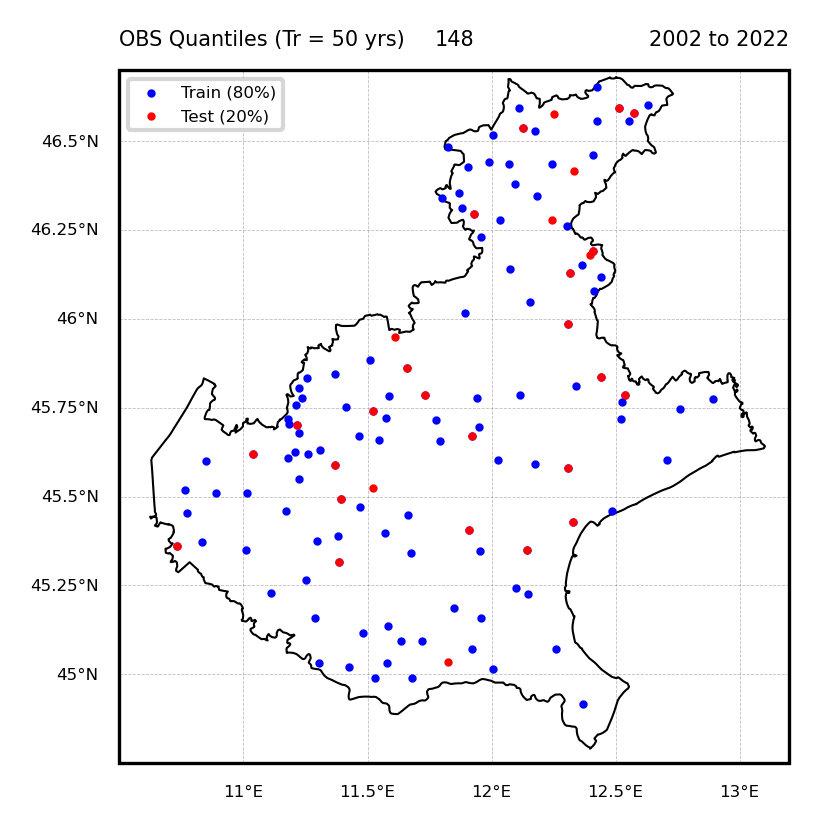

In [12]:
wa_inside_rect_norm = (wa_inside_rect['Q50']-wa_inside_rect['Q50'].min())/(wa_inside_rect['Q50'].max()-wa_inside_rect['Q50'].min())

levels_obs = np.arange(50,510,10)
norm_obs = mcolors.BoundaryNorm(boundaries=levels_obs, ncolors=256)

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,3),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.75, 46.7],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)

a1 = ax1.scatter(
                Q_80['Lon'].values, 
                Q_80['Lat'].values, 
                s=1, 
                c='b', 
                zorder=20, label='Train (80%)')

a1 = ax1.scatter(
                Q_20['Lon'].values, 
                Q_20['Lat'].values, 
                s=1, 
                c='r', 
                zorder=20, label='Test (20%)')

# rect_gdf.plot(ax=ax1, edgecolor='r', facecolor='none', linewidth=0.5, zorder=15)

plt.legend(fontsize=4, loc=2)

# cbar = plt.colorbar(a1, ticks= None, orientation='vertical', pad=0.01)
# cbar.ax.tick_params(labelsize=5)
# cbar.set_label("Acf-MAR (mm)", fontsize=6)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels =True
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

ax1.set_title(f'OBS Quantiles (Tr = 50 yrs)', fontsize=5, loc='left')
ax1.set_title(f'{len(wa_inside_rect)}', fontsize=5, loc='center')
ax1.set_title(f'{yy_s} to {yy_e}', fontsize=5, loc='right')

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

salida = os.path.join('/','home','arturo','Pictures','ERRORS',f'RE_sedd_{seed}_MAP.png')
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

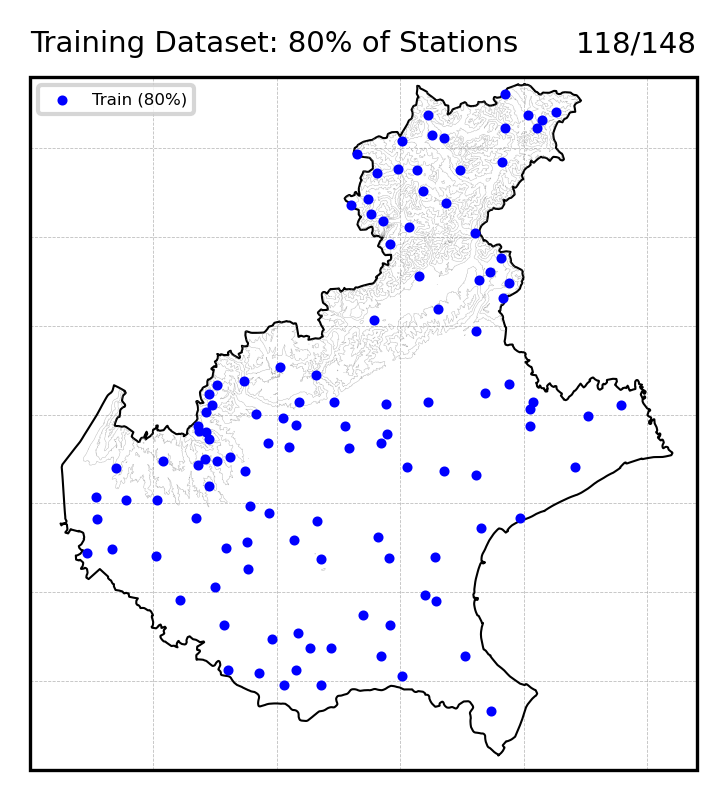

In [13]:
wa_inside_rect_norm = (wa_inside_rect['Q50']-wa_inside_rect['Q50'].min())/(wa_inside_rect['Q50'].max()-wa_inside_rect['Q50'].min())

levels_obs = np.arange(50,510,10)
norm_obs = mcolors.BoundaryNorm(boundaries=levels_obs, ncolors=256)

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,3),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.75, 46.7],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
DEM.plot(facecolor='None',color='grey',alpha=0.6, ax=ax1, linewidth=0.1, zorder=10)

a1 = ax1.scatter(
                Q_80['Lon'].values, 
                Q_80['Lat'].values, 
                s=2, 
                c='b', 
                zorder=20, label='Train (80%)')

plt.legend(fontsize=4, loc=2)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels =False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

ax1.set_title(f'Training Dataset: 80% of Stations', fontsize=7, loc='left')
ax1.set_title(f'{len(Q_80['Lon'])}/{len(wa_inside_rect)}', fontsize=7, loc='right')

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

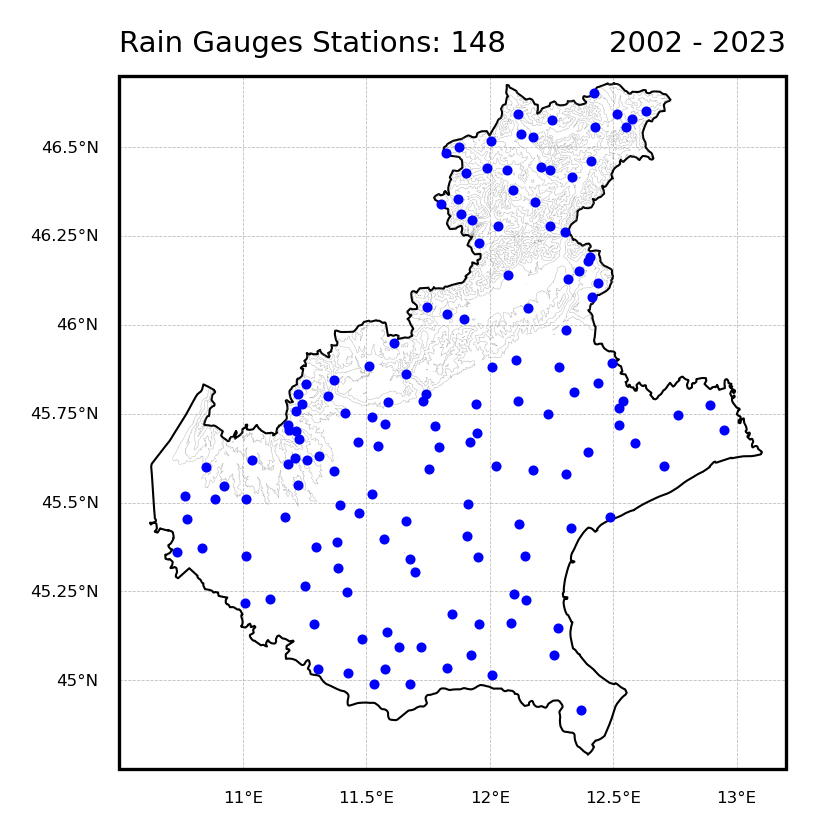

In [14]:
wa_inside_rect_norm = (wa_inside_rect['Q50']-wa_inside_rect['Q50'].min())/(wa_inside_rect['Q50'].max()-wa_inside_rect['Q50'].min())

levels_obs = np.arange(50,510,10)
norm_obs = mcolors.BoundaryNorm(boundaries=levels_obs, ncolors=256)

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,3),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.75, 46.7],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
DEM.plot(facecolor='None',color='grey',alpha=0.6, ax=ax1, linewidth=0.1, zorder=10)

a1 = ax1.scatter(
                wa_inside_rect['Lon'].values, 
                wa_inside_rect['Lat'].values, 
                s=2, 
                c='b', 
                zorder=20, label='Test (20%)')

# plt.legend(fontsize=4, loc=2)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels =True
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

ax1.set_title(f'Rain Gauges Stations: {len(wa_inside_rect['Lon'])}', fontsize=7, loc='left')
ax1.set_title(f'2002 - 2023', fontsize=7, loc='right')

ax1.set_facecolor('white')
fig.patch.set_alpha(0)
# ax1.axis('off')

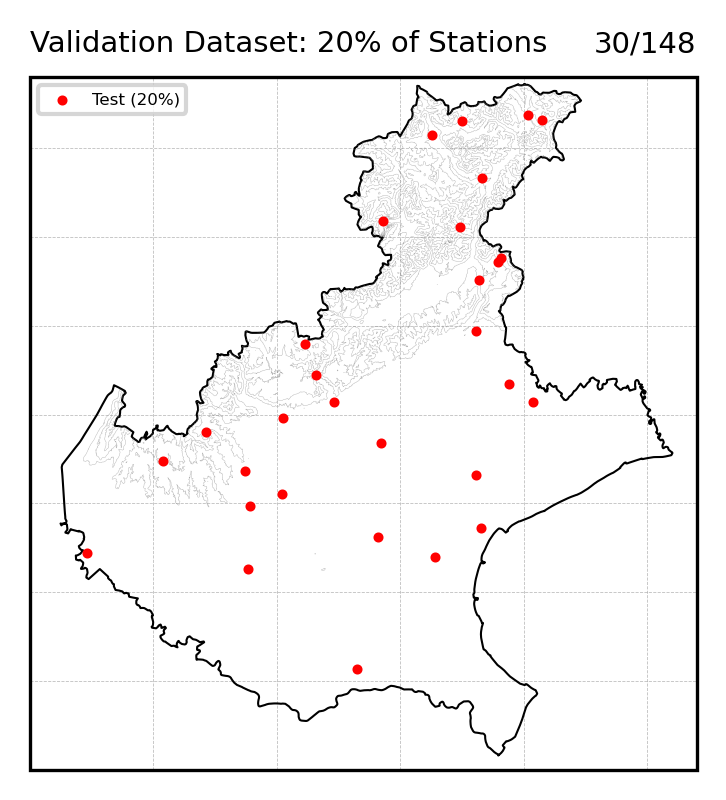

In [15]:
wa_inside_rect_norm = (wa_inside_rect['Q50']-wa_inside_rect['Q50'].min())/(wa_inside_rect['Q50'].max()-wa_inside_rect['Q50'].min())

levels_obs = np.arange(50,510,10)
norm_obs = mcolors.BoundaryNorm(boundaries=levels_obs, ncolors=256)

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,3),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.75, 46.7],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
DEM.plot(facecolor='None',color='grey',alpha=0.6, ax=ax1, linewidth=0.1, zorder=10)

a1 = ax1.scatter(
                Q_20['Lon'].values, 
                Q_20['Lat'].values, 
                s=2, 
                c='r', 
                zorder=20, label='Test (20%)')

plt.legend(fontsize=4, loc=2)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels =False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

ax1.set_title(f'Validation Dataset: 20% of Stations', fontsize=7, loc='left')
ax1.set_title(f'{len(Q_20['Lon'])}/{len(wa_inside_rect)}', fontsize=7, loc='right')

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

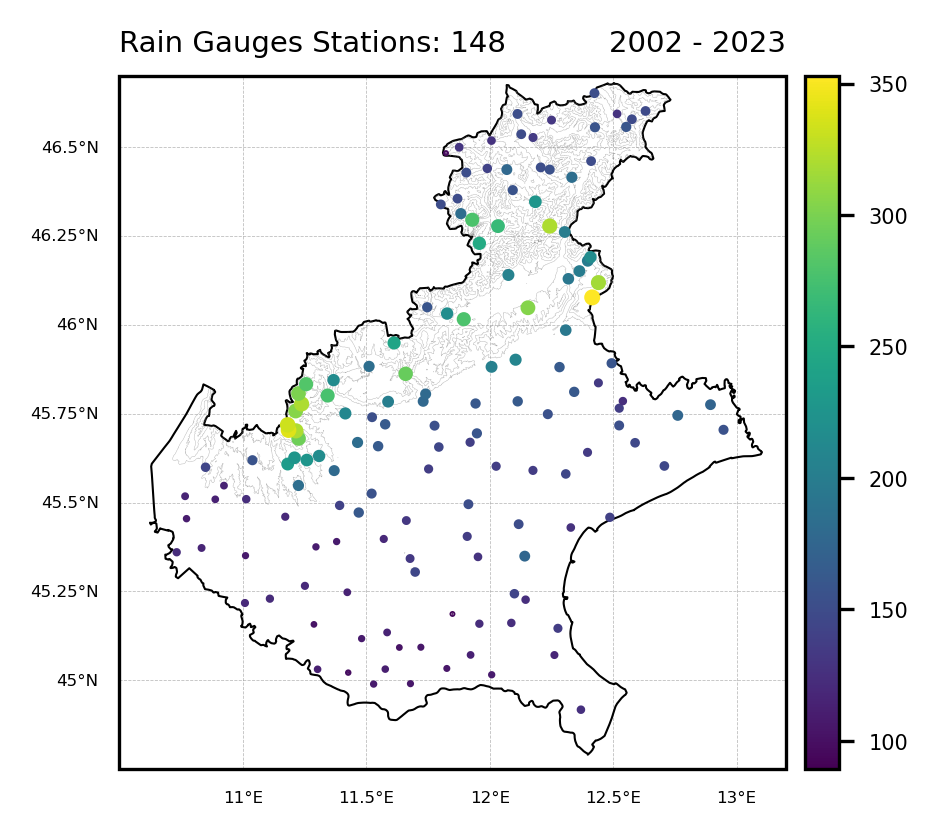

In [25]:
wa_inside_rect_norm = (wa_inside_rect['Q50']-wa_inside_rect['Q50'].min())/(wa_inside_rect['Q50'].max()-wa_inside_rect['Q50'].min())

levels_obs = np.arange(50,510,10)
norm_obs = mcolors.BoundaryNorm(boundaries=levels_obs, ncolors=256)

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,3),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.75, 46.7],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
DEM.plot(facecolor='None',color='grey',alpha=0.6, ax=ax1, linewidth=0.1, zorder=10)

a1 = ax1.scatter(
                wa_inside_rect['Lon'].values, 
                wa_inside_rect['Lat'].values, 
                s=wa_inside_rect_norm*8, 
                c=wa_inside_rect['Q50'], 
                zorder=20, label='Test (20%)')

# plt.legend(fontsize=4, loc=2)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels =True
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

ax1.set_title(f'Rain Gauges Stations: {len(wa_inside_rect['Lon'])}', fontsize=7, loc='left')
ax1.set_title(f'2002 - 2023', fontsize=7, loc='right')

cbar = plt.colorbar(a1, ticks= None, orientation='vertical', pad=0.02, fraction=0.0485)
cbar.ax.tick_params(labelsize=5)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [16]:
def convert_lat_lon_point(lon_in, lat_in):
    lon2d, lat2d = np.meshgrid(lon_in, lat_in)
    points = [Point(lon, lat) for lon, lat in zip(lon2d.ravel(), lat2d.ravel())]
    points_gdf = gpd.GeoDataFrame(geometry=points, crs="EPSG:4326")
    
    points_in_rect = gpd.sjoin(points_gdf, rect_gdf, how="inner", predicate="within")
    
    lon_inside = points_in_rect.geometry.x.values  # Longitudes dentro del rectángulo
    lat_inside = points_in_rect.geometry.y.values  # Latitudes dentro del rectángulo
    
    lon_indices = [np.argmin(np.abs(lon_in - lon)) for lon in lon_inside]
    lat_indices = [np.argmin(np.abs(lat_in - lat)) for lat in lat_inside]
    
    lon_indices = np.unique(lon_indices)
    lat_indices = np.unique(lat_indices)
    
    lon2d, lat2d = np.meshgrid(lon_in[lon_indices],lat_in[lat_indices])
    
    return lon_indices, lat_indices, lon2d, lat2d

Text(1.0, 1.0, '30')

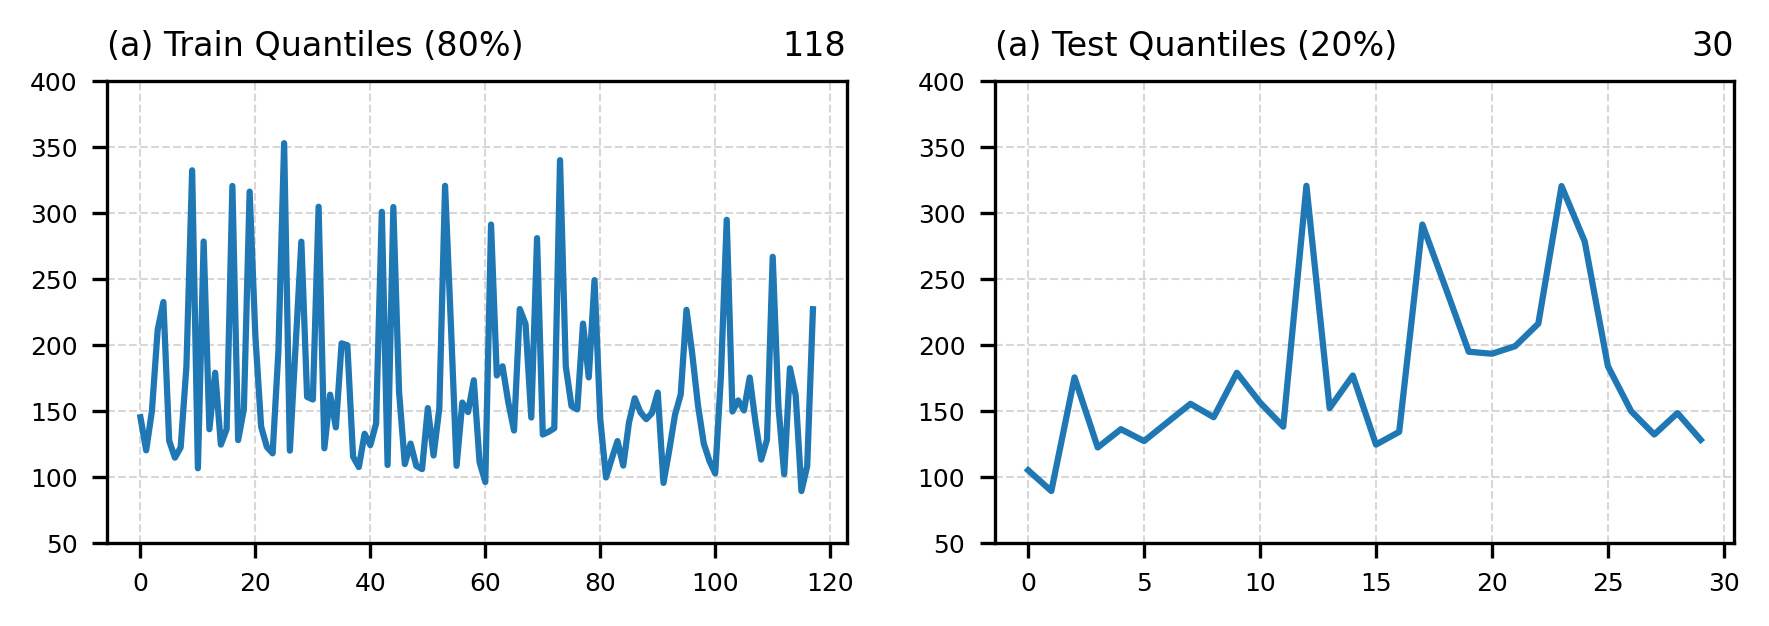

In [17]:
fig = plt.figure(figsize=(7,2),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(Q_80['Q50'])
ax1.set_ylim(50, 400)
ax1.grid(linestyle='--', linewidth=0.5, alpha=0.5)
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_title('(a) Train Quantiles (80%)', fontsize=8, loc='left')
ax1.set_title(len(Q_80), fontsize=8, loc='right')

# ==================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.plot(Q_20['Q50'])
ax1.set_ylim(50, 400)
ax1.grid(linestyle='--', linewidth=0.5, alpha=0.5)
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_title('(a) Test Quantiles (20%)', fontsize=8, loc='left')
ax1.set_title(len(Q_20), fontsize=8, loc='right')

## Satellite

In [18]:
npix = 2

area = 'VENETO'

method = 'mar'
opt = 'genetic'

NEIBHR = 2*npix+1

In [19]:
data_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')

## IMERG

In [20]:
yy_s, yy_e+1

(2002, 2023)

In [21]:
data_dir = os.path.join(data_base,'5_DOWN',f'{area}_DOWN_IMERG_1dy_{yy_s}_{yy_e+1}_npix_{npix}_thr_1_acf_{method}_{opt}_pearson.nc')
DATA = xr.open_dataset(data_dir)
DATA = DATA.sel(year=slice(2002, 2022))

lon2d_IMERG, lat2d_IMERG  = np.meshgrid(DATA.lon.values, DATA.lat.values)
lons_IMERG, lats_IMERG = DATA.lon.values, DATA.lat.values

Tr = DATA['Tr'].values

NIMERG = DATA['NYs'].values
CIMERG = DATA['CYs'].values
WIMERG = DATA['WYs'].values

NdIMERG = DATA['NYd'].values
CdIMERG = DATA['CYd'].values
WdIMERG = DATA['WYd'].values

QIMERG = DATA.Mev_s.values
QdIMERG = DATA.Mev_d.values
del DATA
NIMERG.shape

(21, 25, 30)

## MSWEP

In [22]:
data_dir = os.path.join(data_base,'5_DOWN',f'{area}_DOWN_MSWEP_3h_{yy_s}_{yy_e+1}_npix_{npix}_thr_1_acf_{method}_{opt}_pearson.nc')

DATA = xr.open_dataset(data_dir)
DATA = DATA.sel(year=slice(2002, 2022))

lon2d_MSWEP, lat2d_MSWEP  = np.meshgrid(DATA.lon.values, DATA.lat.values)
lons_MSWEP, lats_MSWEP = DATA.lon.values, DATA.lat.values

NMSWEP = DATA['NYs'].values
CMSWEP = DATA['CYs'].values
WMSWEP = DATA['WYs'].values

NdMSWEP = DATA['NYd'].values
CdMSWEP = DATA['CYd'].values
WdMSWEP = DATA['WYd'].values

QMSWEP = DATA.Mev_s.values
QdMSWEP = DATA.Mev_d.values
del DATA
NMSWEP.shape

(21, 25, 30)

## CMORPH

In [23]:
data_dir = os.path.join(data_base,'5_DOWN',f'{area}_DOWN_CMORPH_3h_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{method}_{opt}_pearson.nc')

DATA = xr.open_dataset(data_dir)
DATA = DATA.sel(year=slice(2002, 2022))

lon2d_CMORPH, lat2d_CMORPH  = np.meshgrid(DATA.lon.values, DATA.lat.values)
lons_CMORPH, lats_CMORPH = DATA.lon.values, DATA.lat.values

NCMORPH = DATA['NYs'].values
CCMORPH = DATA['CYs'].values
WCMORPH = DATA['WYs'].values

NdCMORPH = DATA['NYd'].values
CdCMORPH = DATA['CYd'].values
WdCMORPH = DATA['WYd'].values

QCMORPH = DATA.Mev_s.values
QdCMORPH = DATA.Mev_d.values
del DATA
NCMORPH.shape

(21, 10, 12)

## ERA5

In [24]:
data_dir = os.path.join(data_base,'5_DOWN',f'{area}_DOWN_ERA5_3h_{yy_s}_{yy_e+1}_npix_{npix}_thr_1_acf_{method}_{opt}_pearson.nc')

DATA = xr.open_dataset(data_dir)
DATA = DATA.sel(year=slice(2002, 2022))

lon2d_ERA5, lat2d_ERA5  = np.meshgrid(DATA.lon.values, DATA.lat.values)
lons_ERA5, lats_ERA5 = DATA.lon.values, DATA.lat.values

NERA5 = DATA['NYs'].values
CERA5 = DATA['CYs'].values
WERA5 = DATA['WYs'].values

NdERA5 = DATA['NYd'].values
CdERA5 = DATA['CYd'].values
WdERA5 = DATA['WYd'].values

QERA5 = DATA.Mev_s.values
QdERA5 = DATA.Mev_d.values
# del DATA
NERA5.shape

(21, 11, 13)

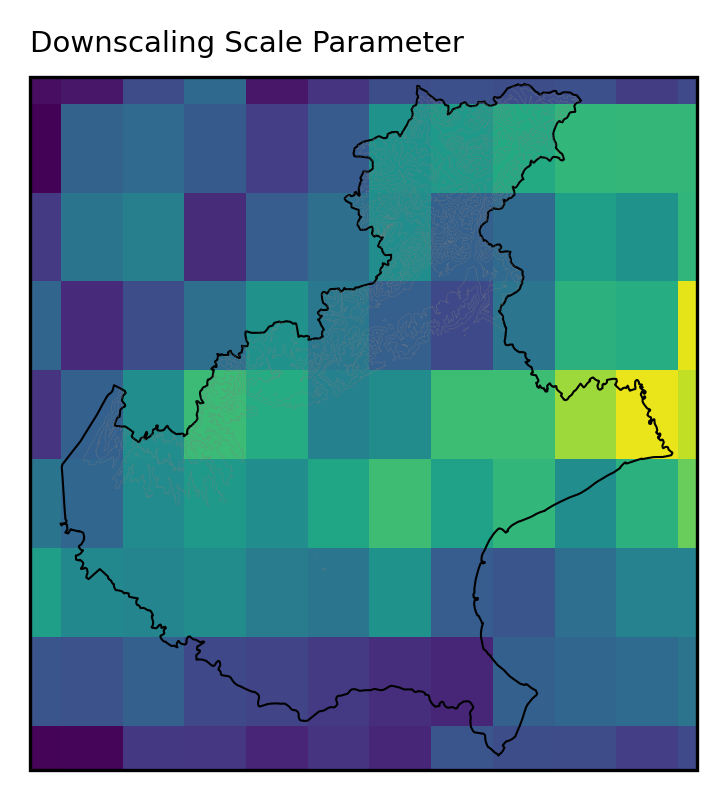

In [25]:
levels_obs = np.arange(50,510,10)
norm_obs = mcolors.BoundaryNorm(boundaries=levels_obs, ncolors=256)

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,3),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.75, 46.7],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
DEM.plot(facecolor='None',color='grey',alpha=0.6, ax=ax1, linewidth=0.1, zorder=10)

a1 = ax1.pcolormesh(lon2d_ERA5, lat2d_ERA5, np.nanmax(CdERA5,axis=0))

ax1.set_title(f'Downscaling Scale Parameter', fontsize=7, loc='left')

# cbar = plt.colorbar(a1, ticks=None, fraction=0.053,pad=0.02)
# cbar.ax.tick_params(labelsize=6)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

## GSMaP

In [26]:
data_dir = os.path.join(data_base,'5_DOWN',f'{area}_DOWN_GSMaP_3h_{yy_s}_{yy_e+1}_npix_{npix}_thr_1_acf_{method}_{opt}_pearson.nc')

DATA = xr.open_dataset(data_dir)
DATA = DATA.sel(year=slice(2002, 2022))

lon2d_GSMaP, lat2d_GSMaP  = np.meshgrid(DATA.lon.values, DATA.lat.values)
lons_GSMaP, lats_GSMaP = DATA.lon.values, DATA.lat.values

NGSMAP = DATA['NYs'].values
CGSMAP = DATA['CYs'].values
WGSMAP = DATA['WYs'].values

NdGSMAP = DATA['NYd'].values
CdGSMAP = DATA['CYd'].values
WdGSMAP = DATA['WYd'].values

QGSMaP = DATA.Mev_s.values
QdGSMaP = DATA.Mev_d.values
del DATA
NGSMAP.shape

(21, 25, 30)

## PERSIANN

In [27]:
data_dir = os.path.join(data_base,'5_DOWN',f'{area}_DOWN_PERSIANN_1dy_{yy_s}_{yy_e+1}_npix_{npix}_thr_1_acf_{method}_{opt}_pearson.nc')

DATA = xr.open_dataset(data_dir)
DATA = DATA.sel(year=slice(2002, 2022))

lon2d_PERSIANN, lat2d_PERSIANN  = np.meshgrid(DATA.lon.values, DATA.lat.values)
lons_PERSIANN, lats_PERSIANN = DATA.lon.values, DATA.lat.values

NPERSIANN = DATA['NYs'].values
CPERSIANN = DATA['CYs'].values
WPERSIANN = DATA['WYs'].values

NdPERSIANN = DATA['NYd'].values
CdPERSIANN = DATA['CYd'].values
WdPERSIANN = DATA['WYd'].values

QPERSIANN = DATA.Mev_s.values
QdPERSIANN = DATA.Mev_d.values
# del DATA
NPERSIANN.shape

(21, 10, 12)

## CHIRPS

In [28]:
data_dir = os.path.join(data_base,'5_DOWN',f'{area}_DOWN_CHIRPS_1dy_{yy_s}_{yy_e+1}_npix_{npix}_thr_1_acf_{method}_{opt}_pearson.nc')

DATA = xr.open_dataset(data_dir)
DATA = DATA.sel(year=slice(2002, 2022))

lon2d_CHIRPS, lat2d_CHIRPS  = np.meshgrid(DATA.lon.values, DATA.lat.values)
lons_CHIRPS, lats_CHIRPS = DATA.lon.values, DATA.lat.values

NCHIRPS = DATA['NYs'].values
CCHIRPS = DATA['CYs'].values
WCHIRPS = DATA['WYs'].values

NdCHIRPS = DATA['NYd'].values
CdCHIRPS = DATA['CYd'].values
WdCHIRPS = DATA['WYd'].values

QCHIRPS = DATA.Mev_s.values
QdCHIRPS = DATA.Mev_d.values
# del DATA
NCHIRPS.shape

(21, 50, 60)

In [29]:
# Tr_index, Q_index = 0, 'Q5'
# Tr_index, Q_index = 1, 'Q10'
# Tr_index, Q_index = 2, 'Q20'
Tr_index, Q_index = 3, 'Q50'
# Tr_index, Q_index = 4, 'Q100'
# Tr_index, Q_index = 5, 'Q200'

colors = ['royalblue','r', 'g', 'c', 'y', 'purple', 'orange']

## QUANTILES ERROR

In [30]:
# Tr_index, Q_index = 0, 'Q5'
# Tr_index, Q_index = 1, 'Q10'
# Tr_index, Q_index = 2, 'Q20'
Tr_index, Q_index = 3, 'Q50'
# Tr_index, Q_index = 4, 'Q100'
# Tr_index, Q_index = 5, 'Q200'

colors = ['royalblue','r', 'g', 'c', 'y', 'purple', 'orange', 'cyan']

In [31]:
IMERG_Qs, IMERG_Qd, IMERG_QEs, IMERG_QEd = [], [], [], []
CMORPH_Qs, CMORPH_Qd, CMORPH_QEs, CMORPH_QEd = [], [], [], []
MSWEP_Qs, MSWEP_Qd, MSWEP_QEs, MSWEP_QEd = [], [], [], []
ERA5_Qs, ERA5_Qd, ERA5_QEs, ERA5_QEd = [], [], [], []
GSMaP_Qs, GSMaP_Qd, GSMaP_QEs, GSMaP_QEd = [], [], [], []
PERSIANN_Qs, PERSIANN_Qd, PERSIANN_QEs,PERSIANN_QEd = [], [], [], []
# SM2RAIN_Qs, SM2RAIN_Qd = [], [], [], []
CHIRPS_Qs, CHIRPS_Qd, CHIRPS_QEs, CHIRPS_QEd = [], [], [], []

ENSEMBLE_QEs, ENSEMBLE_QEd = [], []
Q_SAT_list = []

for nn in range(len(Q_80)):
    Q_OBS = Q_80[Q_index].values[nn]
    lat_obs = Q_80['Lat'].values[nn]
    lon_obs = Q_80['Lon'].values[nn]
    elv_obs = Q_80['Elv'].values[nn]

    # ==============================================================================
    # IMERG
    distances = ART_pre.haversine(lat2d_IMERG, lon2d_IMERG, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    
    IMERG_Qs = QIMERG[Tr_index,min_index[0],min_index[1]]
    EQ = (IMERG_Qs - Q_OBS)/Q_OBS
    IMERG_QEs.append(float(EQ))
    
    IMERG_Qd = QdIMERG[Tr_index,min_index[0],min_index[1]]
    EQ = (IMERG_Qd - Q_OBS)/Q_OBS
    IMERG_QEd.append(float(EQ))

    # ==============================================================================
    # CMORPH
    distances = ART_pre.haversine(lat2d_CMORPH, lon2d_CMORPH, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    
    CMORPH_Qs = QCMORPH[Tr_index,min_index[0],min_index[1]]
    EQ = (CMORPH_Qs - Q_OBS)/Q_OBS
    CMORPH_QEs.append(float(EQ))

    CMORPH_Qd = QdCMORPH[Tr_index,min_index[0],min_index[1]]
    EQ = (CMORPH_Qd - Q_OBS)/Q_OBS
    CMORPH_QEd.append(float(EQ))

    # ==============================================================================
    # MSWEP
    distances = ART_pre.haversine(lat2d_MSWEP, lon2d_MSWEP, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    
    MSWEP_Qs = QMSWEP[Tr_index,min_index[0],min_index[1]]
    EQ = (MSWEP_Qs - Q_OBS)/Q_OBS
    MSWEP_QEs.append(float(EQ))
    
    MSWEP_Qd = QdMSWEP[Tr_index,min_index[0],min_index[1]]
    EQ = (MSWEP_Qd - Q_OBS)/Q_OBS
    MSWEP_QEd.append(float(EQ))

    # ==============================================================================
    # ERA5
    distances = ART_pre.haversine(lat2d_ERA5, lon2d_ERA5, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    
    ERA5_Qs = QERA5[Tr_index,min_index[0],min_index[1]]
    EQ = (ERA5_Qs - Q_OBS)/Q_OBS
    ERA5_QEs.append(float(EQ))
    
    ERA5_Qd = QdERA5[Tr_index,min_index[0],min_index[1]]
    EQ = (ERA5_Qd - Q_OBS)/Q_OBS
    ERA5_QEd.append(float(EQ))

    # ==============================================================================
    # GSMaP
    distances = ART_pre.haversine(lat2d_GSMaP, lon2d_GSMaP, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    
    GSMaP_Qs = QGSMaP[Tr_index,min_index[0],min_index[1]]
    EQ = (GSMaP_Qs - Q_OBS)/Q_OBS
    GSMaP_QEs.append(float(EQ))
    
    GSMaP_Qd = QdGSMaP[Tr_index,min_index[0],min_index[1]]
    EQ = (GSMaP_Qd - Q_OBS)/Q_OBS
    GSMaP_QEd.append(float(EQ))

    # # ==============================================================================
    # # SM2RAIN
    # distances = ART_pre.haversine(lat_SM2RAIN, lon_SM2RAIN, lat_obs, lon_obs)
    # min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    
    # SM2RAIN_Q = QSM2RAIN[Tr_index,min_index[0],min_index[1]]
    # EQ = (SM2RAIN_Q - Q_OBS)/Q_OBS
    # EQ_SM2RAIN.append(float(EQ))
    
    # SM2RAIN_Qd = QdSM2RAIN[Tr_index,min_index[0],min_index[1]]
    # EQ = (SM2RAIN_Qd - Q_OBS)/Q_OBS
    # EQd_SM2RAIN.append(float(EQ))

    # ==============================================================================
    # PERSIANN
    distances = ART_pre.haversine(lat2d_PERSIANN, lon2d_PERSIANN, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    
    PERSIANN_Qs = QPERSIANN[Tr_index,min_index[0],min_index[1]]
    EQ = (PERSIANN_Qs - Q_OBS)/Q_OBS
    PERSIANN_QEs.append(float(EQ))
    
    PERSIANN_Qd = QdPERSIANN[Tr_index,min_index[0],min_index[1]]
    EQ = (PERSIANN_Qd - Q_OBS)/Q_OBS
    PERSIANN_QEd.append(float(EQ))

    # ==============================================================================
    # CHIRPS
    distances = ART_pre.haversine(lat2d_CHIRPS, lon2d_CHIRPS, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    
    CHIRPS_Qs = QCHIRPS[Tr_index,min_index[0],min_index[1]]
    EQ = (CHIRPS_Qs - Q_OBS)/Q_OBS
    CHIRPS_QEs.append(float(EQ))
    
    CHIRPS_Qd = QdCHIRPS[Tr_index,min_index[0],min_index[1]]
    EQ = (CHIRPS_Qd - Q_OBS)/Q_OBS
    CHIRPS_QEd.append(float(EQ))

    # ==============================================================================
    SAT_ENSEMBLE_Qs = np.nanmean(
                        [
                        IMERG_Qs,
                        MSWEP_Qs,
                        CMORPH_Qs,
                        ERA5_Qs,
                        GSMaP_Qs,
                        # PERSIANN_Qs,
                        # SM2RAIN_Qs,
                        CHIRPS_Qs
                        ],axis=0)
    EQ_ESEMBLE_ = (SAT_ENSEMBLE_Qs - Q_OBS)/Q_OBS
    ENSEMBLE_QEs.append(EQ_ESEMBLE_)
    
    SAT_ENSEMBLE_Qd = np.nanmean(
                        [
                        IMERG_Qd,
                        CMORPH_Qd,
                        MSWEP_Qd,
                        ERA5_Qd,
                        GSMaP_Qd,
                        # SM2RAIN_Qd,
                        # PERSIANN_Qd
                        CHIRPS_Qd
                        ],axis=0)
    EQd_ESEMBLE_ = (SAT_ENSEMBLE_Qd - Q_OBS)/Q_OBS
    ENSEMBLE_QEd.append(EQd_ESEMBLE_)

    Q_SAT_list.append({
        'Lat': lat_obs,
        'Lon': lon_obs,
        'Elv':elv_obs,
        'OBS': Q_OBS,
        'IMERG': IMERG_Qs,
        'IMERGd': IMERG_Qd,
        'CMORPH': CMORPH_Qs,
        'CMORPHd': CMORPH_Qd,
        'MSWEP': MSWEP_Qs,
        'MSWEPd': MSWEP_Qd,
        'ERA5': ERA5_Qs,
        'ERA5d': ERA5_Qd,
        'GSMaP': GSMaP_Qs,
        'GSMaPd': GSMaP_Qd,
        # 'SM2RAIN': SM2RAIN_Q,
        # 'SM2RAINd': SM2RAIN_Qd,
        'PERSIANN':PERSIANN_Qs,
        'PERSIANNd':PERSIANN_Qd,
        'CHIRPS':CHIRPS_Qs,
        'CHIRPSd':CHIRPS_Qd,
        'ENSEMBLE': SAT_ENSEMBLE_Qs,
        'ENSEMBLEd': SAT_ENSEMBLE_Qd
    })

SATELLITE_pd = pd.DataFrame(Q_SAT_list)

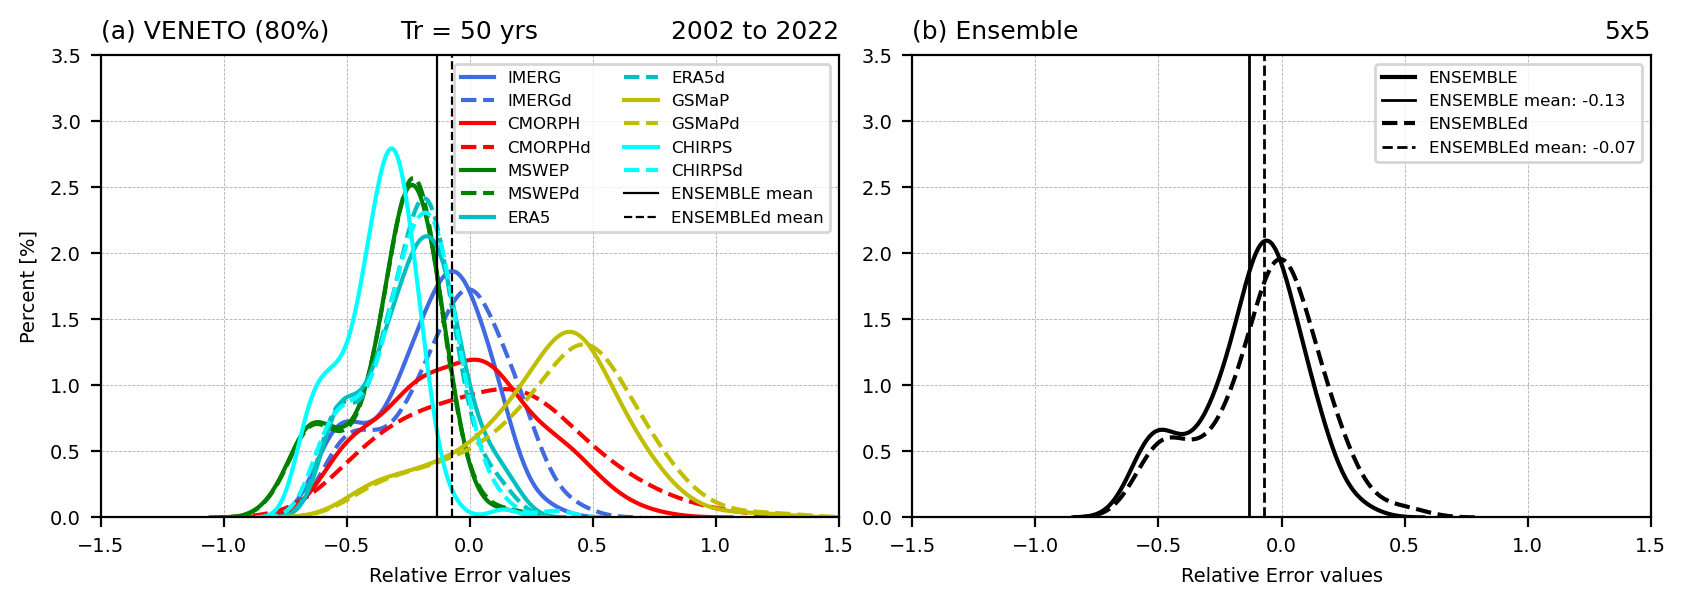

In [32]:
fig = plt.figure(figsize=(10,3),dpi=200)
gs = gridspec.GridSpec(1,2)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])

sns.kdeplot(IMERG_QEs,color=colors[0],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'IMERG')
sns.kdeplot(IMERG_QEd,color=colors[0], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'IMERGd')

sns.kdeplot(CMORPH_QEs,color=colors[1],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CMORPH')
sns.kdeplot(CMORPH_QEd,color=colors[1], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CMORPHd')

sns.kdeplot(MSWEP_QEs,color=colors[2],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'MSWEP')
sns.kdeplot(MSWEP_QEd,color=colors[2], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'MSWEPd')

sns.kdeplot(ERA5_QEs,color=colors[3],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ERA5')
sns.kdeplot(ERA5_QEd,color=colors[3], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ERA5d')

sns.kdeplot(GSMaP_QEs,color=colors[4],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'GSMaP')
sns.kdeplot(GSMaP_QEd,color=colors[4], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'GSMaPd')

# sns.kdeplot(PERSIANN_QEs,color=colors[5],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'PERSIANN')
# sns.kdeplot(PERSIANN_QEd,color=colors[5], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'PERSIANNd')

# sns.kdeplot(SM2RAIN_QEs,color=colors[6],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'SM2RAIN')
# sns.kdeplot(SM2RAIN_QEd,color=colors[6], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'SM2RAINd')

sns.kdeplot(CHIRPS_QEs,color=colors[7],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CHIRPS')
sns.kdeplot(CHIRPS_QEd,color=colors[7], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CHIRPSd')

ax1.axvline(np.mean(ENSEMBLE_QEs),color='k',linestyle='-',linewidth=0.8, label='ENSEMBLE mean')
ax1.axvline(np.mean(ENSEMBLE_QEd),color='k',linestyle='--',linewidth=0.8, label='ENSEMBLEd mean')

ax1.set_ylabel('Percent [%]',fontsize=7)
ax1.set_xlabel('Relative Error values',fontsize=7)
ax1.legend(fontsize=6, loc=0, ncol=2)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,3.5)
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_title(f'(a) {area} (80%)', fontsize=9, loc='left')
ax1.set_title(f'Tr = 50 yrs',fontsize=9, loc='Center')
ax1.set_title(f'{yy_s} to {yy_e}',fontsize=9, loc='right')

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 1])

sns.kdeplot(ENSEMBLE_QEs,color='k',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLE')
ax1.axvline(np.mean(ENSEMBLE_QEs),color='k',linestyle='-',linewidth=1, label=f'ENSEMBLE mean: {np.round(np.nanmean(np.mean(ENSEMBLE_QEs)),2)}')

sns.kdeplot(ENSEMBLE_QEd,color='k', linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLEd')
ax1.axvline(np.mean(ENSEMBLE_QEd),color='k',linestyle='--',linewidth=1, label=f'ENSEMBLEd mean: {np.round(np.nanmean(np.mean(ENSEMBLE_QEd)),2)}')

ax1.legend(fontsize=6, loc=0, ncol=1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,3.5)
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_ylabel('')
ax1.set_xlabel('Relative Error values',fontsize=7) 
ax1.set_title(f'(b) Ensemble', fontsize=9, loc='left')
# ax1.set_title(f'ACF: {method}', fontsize=9, loc='center')
ax1.set_title(f'{NEIBHR}x{NEIBHR}', fontsize=9, loc='right')

# =========================================================================================================================
plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

# =========================================================================================================================
salida = os.path.join('/','home','arturo','Pictures','ERRORS',f'RE_sedd_{seed}_TRA_80.png')
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

In [33]:
# Export Quantiles to verify the difference with differents seeds
Qdf_80 = pd.DataFrame({
                    'IMERG80Qs':IMERG_QEs, 'IMERG80Qd':IMERG_QEd,
                    'CMORPH80Qs':CMORPH_QEs, 'CMORPH80Qd':CMORPH_QEd,
                    'MSWEP80Qs':MSWEP_QEs, 'MSWEP80Qd':MSWEP_QEd,
                    'ERA580Qs':ERA5_QEs, 'ERA580Qd':ERA5_QEd,
                    'GSMaP80Qs':GSMaP_QEs, 'GSMaP80Qd':GSMaP_QEd,
                    'CHIRPS80Qs':CHIRPS_QEs, 'CHIRPS80Qd':CHIRPS_QEd,
                    'ENSEMBLE80Qs':ENSEMBLE_QEs, 'ENSEMBLE80Qd':ENSEMBLE_QEd})
salida = os.path.join('/','home','arturo','Pictures','ERRORS','csv',f'Q80_seed_{seed}.csv')
Qdf_80.to_csv(salida,header=True)

In [34]:
# Stop Notebook
# sys.exit("🛑 The execution of the cell was stopped")

## BIAS CORRECTION

In [35]:
def CDFt(obs, sat):
    """
    Aplica la corrección de sesgo usando CDFt.
    Si se proporciona 'sat_future', también ajusta datos futuros.
    """
    # CDF empírica de los datos observados y satelitales
    obs_sorted = np.sort(obs)
    
    # Transformación de cuantiles
    sat_percentiles = stats.rankdata(sat, method='average') / len(sat)
    corrected_sat = np.interp(sat_percentiles, np.linspace(0,1,len(obs_sorted)), obs_sorted)
    
    return corrected_sat

def ISIMIP_QM(obs, sat):
    """
    Aplica la corrección de sesgo usando ISIMIP QM (Quantile Mapping).
    """
    # Cuantiles de los datos
    quantiles = np.linspace(0, 1, len(obs))
    
    # Ajuste de cuantiles
    obs_quantiles = np.nanquantile(obs, quantiles)
    sat_quantiles = np.nanquantile(sat, quantiles)
    
    # Aplicar ajuste a los datos satelitales
    corrected_sat = np.interp(sat, sat_quantiles, obs_quantiles)
    
    return corrected_sat

def vector_slope_intercept(OBS,SAT):
    OBS = np.array(OBS)
    SAT = np.array(SAT)
    vmin = np.nanmin([OBS.min(), SAT.min()])
    vmax = np.nanmax([OBS.max(), SAT.max()])
    xx = np.arange(vmin,vmax+1,1)
    slope, intercept, _, _, _ = stats.linregress(OBS,SAT)
    y_pred = slope * xx + intercept
    return xx, y_pred

In [36]:
N_80 = N_df[N_df['filename'].isin(Q_80['File_Name'])]
C_80 = C_df[C_df['filename'].isin(Q_80['File_Name'])]
W_80 = W_df[W_df['filename'].isin(Q_80['File_Name'])]

OBS_N_vals = N_80.iloc[:,4:].values.flatten()
OBS_C_vals = C_80.iloc[:,4:].values.flatten()
OBS_W_vals = W_80.iloc[:,4:].values.flatten()

In [37]:
count, NOBS_bcount = np.histogram(OBS_N_vals, bins=50, density=True)
NOBS_cdf = np.cumsum(count) * np.diff(NOBS_bcount)[0]

count, NdIMERG_bcount = np.histogram(NdIMERG.flatten(), bins=50, density=True)
NdIMERG_cdf = np.cumsum(count) * np.diff(NdIMERG_bcount)[0]

count, NdMSWEP_bcount = np.histogram(NdMSWEP.flatten(), bins=50, density=True)
NdMSWEP_cdf = np.cumsum(count) * np.diff(NdMSWEP_bcount)[0]

count, NdERA5_bcount = np.histogram(NdERA5.flatten(), bins=50, density=True)
NdERA5_cdf = np.cumsum(count) * np.diff(NdERA5_bcount)[0]

count, NdGSMaP_bcount = np.histogram(NdGSMAP.flatten(), bins=50, density=True)
NdGSMaP_cdf = np.cumsum(count) * np.diff(NdGSMaP_bcount)[0]

count, NdPERSIANN_bcount = np.histogram(NdPERSIANN.flatten(), bins=50, density=True)
NdPERSIANN_cdf = np.cumsum(count) * np.diff(NdPERSIANN_bcount)[0]

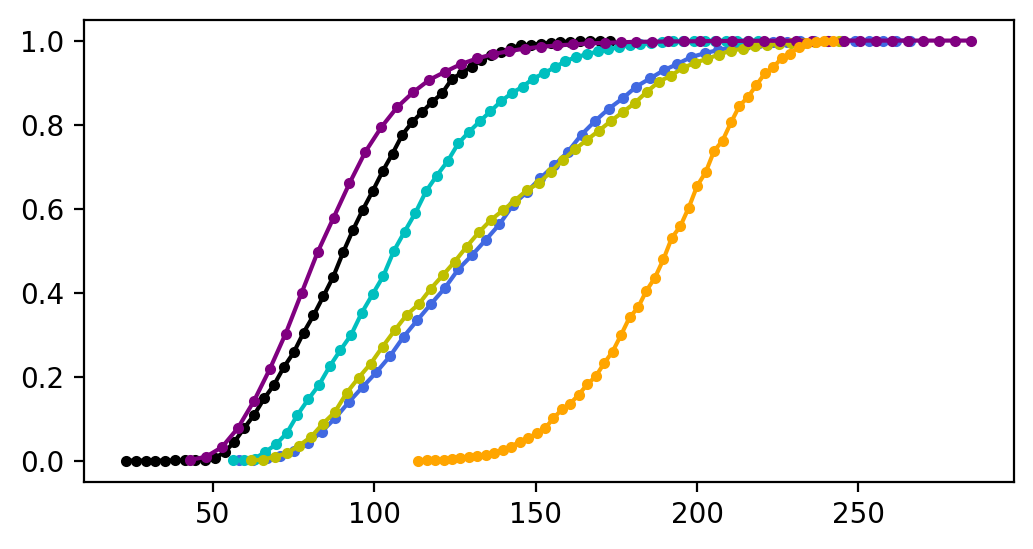

In [38]:
fig = plt.figure(figsize=(6,3),dpi=200)
gs = gridspec.GridSpec(1,1)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(NOBS_bcount[1:], NOBS_cdf, marker='.', linestyle='-', color='k')

ax1.plot(NdIMERG_bcount[1:], NdIMERG_cdf, marker='.', linestyle='-', color=colors[0], label='IMERG')
ax1.plot(NdMSWEP_bcount[1:], NdMSWEP_cdf, marker='.', linestyle='-', color=colors[3], label='MSWEP')
ax1.plot(NdERA5_bcount[1:], NdERA5_cdf, marker='.', linestyle='-', color=colors[4], label='ERA5')
ax1.plot(NdGSMaP_bcount[1:], NdGSMaP_cdf, marker='.', linestyle='-', color=colors[5], label='GSMaP')
ax1.plot(NdPERSIANN_bcount[1:], NdPERSIANN_cdf, marker='.', linestyle='-', color=colors[6], label='PERSIANN')

In [39]:
## IMERG BIAS CORRECTION
IMERG_NYd_CDFt = ISIMIP_QM(OBS_N_vals, NdIMERG.flatten())
IMERG_CYd_CDFt = ISIMIP_QM(OBS_C_vals, CdIMERG.flatten())
IMERG_WYd_CDFt = ISIMIP_QM(OBS_W_vals, WdIMERG.flatten())

IMERG_NYd_CDFt = IMERG_NYd_CDFt.reshape(NdIMERG.shape[0],NdIMERG.shape[1],NdIMERG.shape[2])
IMERG_CYd_CDFt = IMERG_CYd_CDFt.reshape(CdIMERG.shape[0],CdIMERG.shape[1],CdIMERG.shape[2])
IMERG_WYd_CDFt = IMERG_WYd_CDFt.reshape(WdIMERG.shape[0],WdIMERG.shape[1],WdIMERG.shape[2])

IMERG_QYd_CDFt = ART_down.pre_quantiles_array(
                        IMERG_NYd_CDFt, 
                        IMERG_CYd_CDFt, 
                        IMERG_WYd_CDFt, 
                        Tr, 
                        lats_IMERG, lons_IMERG, 
                        1)

In [40]:
## MSWEP BIAS CORRECTION
MSWEP_NYd_CDFt = ISIMIP_QM(OBS_N_vals, NdMSWEP.flatten())
MSWEP_CYd_CDFt = ISIMIP_QM(OBS_C_vals, CdMSWEP.flatten())
MSWEP_WYd_CDFt = ISIMIP_QM(OBS_W_vals, WdMSWEP.flatten())

MSWEP_NYd_CDFt = MSWEP_NYd_CDFt.reshape(NdMSWEP.shape[0],NdMSWEP.shape[1],NdMSWEP.shape[2])
MSWEP_CYd_CDFt = MSWEP_CYd_CDFt.reshape(CdMSWEP.shape[0],CdMSWEP.shape[1],CdMSWEP.shape[2])
MSWEP_WYd_CDFt = MSWEP_WYd_CDFt.reshape(WdMSWEP.shape[0],WdMSWEP.shape[1],WdMSWEP.shape[2])

MSWEP_QYd_CDFt = ART_down.pre_quantiles_array(
                        MSWEP_NYd_CDFt, 
                        MSWEP_CYd_CDFt, 
                        MSWEP_WYd_CDFt, 
                        Tr, 
                        lats_MSWEP, lons_MSWEP, 
                        1)

In [41]:
## CMORPH BIAS CORRECTION
## ISIMIP_QM dont work with CMORPH, because CMORPH has NaN values
CMORPH_NYd_CDFt = ISIMIP_QM(OBS_N_vals, NdCMORPH.flatten())
CMORPH_CYd_CDFt = ISIMIP_QM(OBS_C_vals, CdCMORPH.flatten())
CMORPH_WYd_CDFt = ISIMIP_QM(OBS_W_vals, WdCMORPH.flatten())

CMORPH_NYd_CDFt = CMORPH_NYd_CDFt.reshape(NdCMORPH.shape[0],NdCMORPH.shape[1],NdCMORPH.shape[2])
CMORPH_CYd_CDFt = CMORPH_CYd_CDFt.reshape(CdCMORPH.shape[0],CdCMORPH.shape[1],CdCMORPH.shape[2])
CMORPH_WYd_CDFt = CMORPH_WYd_CDFt.reshape(WdCMORPH.shape[0],WdCMORPH.shape[1],WdCMORPH.shape[2])

CMORPH_QYd_CDFt = ART_down.pre_quantiles_array(
                        CMORPH_NYd_CDFt, 
                        CMORPH_CYd_CDFt, 
                        CMORPH_WYd_CDFt, 
                        Tr, 
                        lats_CMORPH, lons_CMORPH, 
                        1)

In [42]:
## ERA5 BIAS CORRECTION
ERA5_NYd_CDFt = ISIMIP_QM(OBS_N_vals, NdERA5.flatten())
ERA5_CYd_CDFt = ISIMIP_QM(OBS_C_vals, CdERA5.flatten())
ERA5_WYd_CDFt = ISIMIP_QM(OBS_W_vals, WdERA5.flatten())

ERA5_NYd_CDFt = ERA5_NYd_CDFt.reshape(NdERA5.shape[0],NdERA5.shape[1],NdERA5.shape[2])
ERA5_CYd_CDFt = ERA5_CYd_CDFt.reshape(CdERA5.shape[0],CdERA5.shape[1],CdERA5.shape[2])
ERA5_WYd_CDFt = ERA5_WYd_CDFt.reshape(WdERA5.shape[0],WdERA5.shape[1],WdERA5.shape[2])

ERA5_QYd_CDFt = ART_down.pre_quantiles_array(
                        ERA5_NYd_CDFt, 
                        ERA5_CYd_CDFt, 
                        ERA5_WYd_CDFt, 
                        Tr, 
                        lats_ERA5, lons_ERA5, 
                        1)

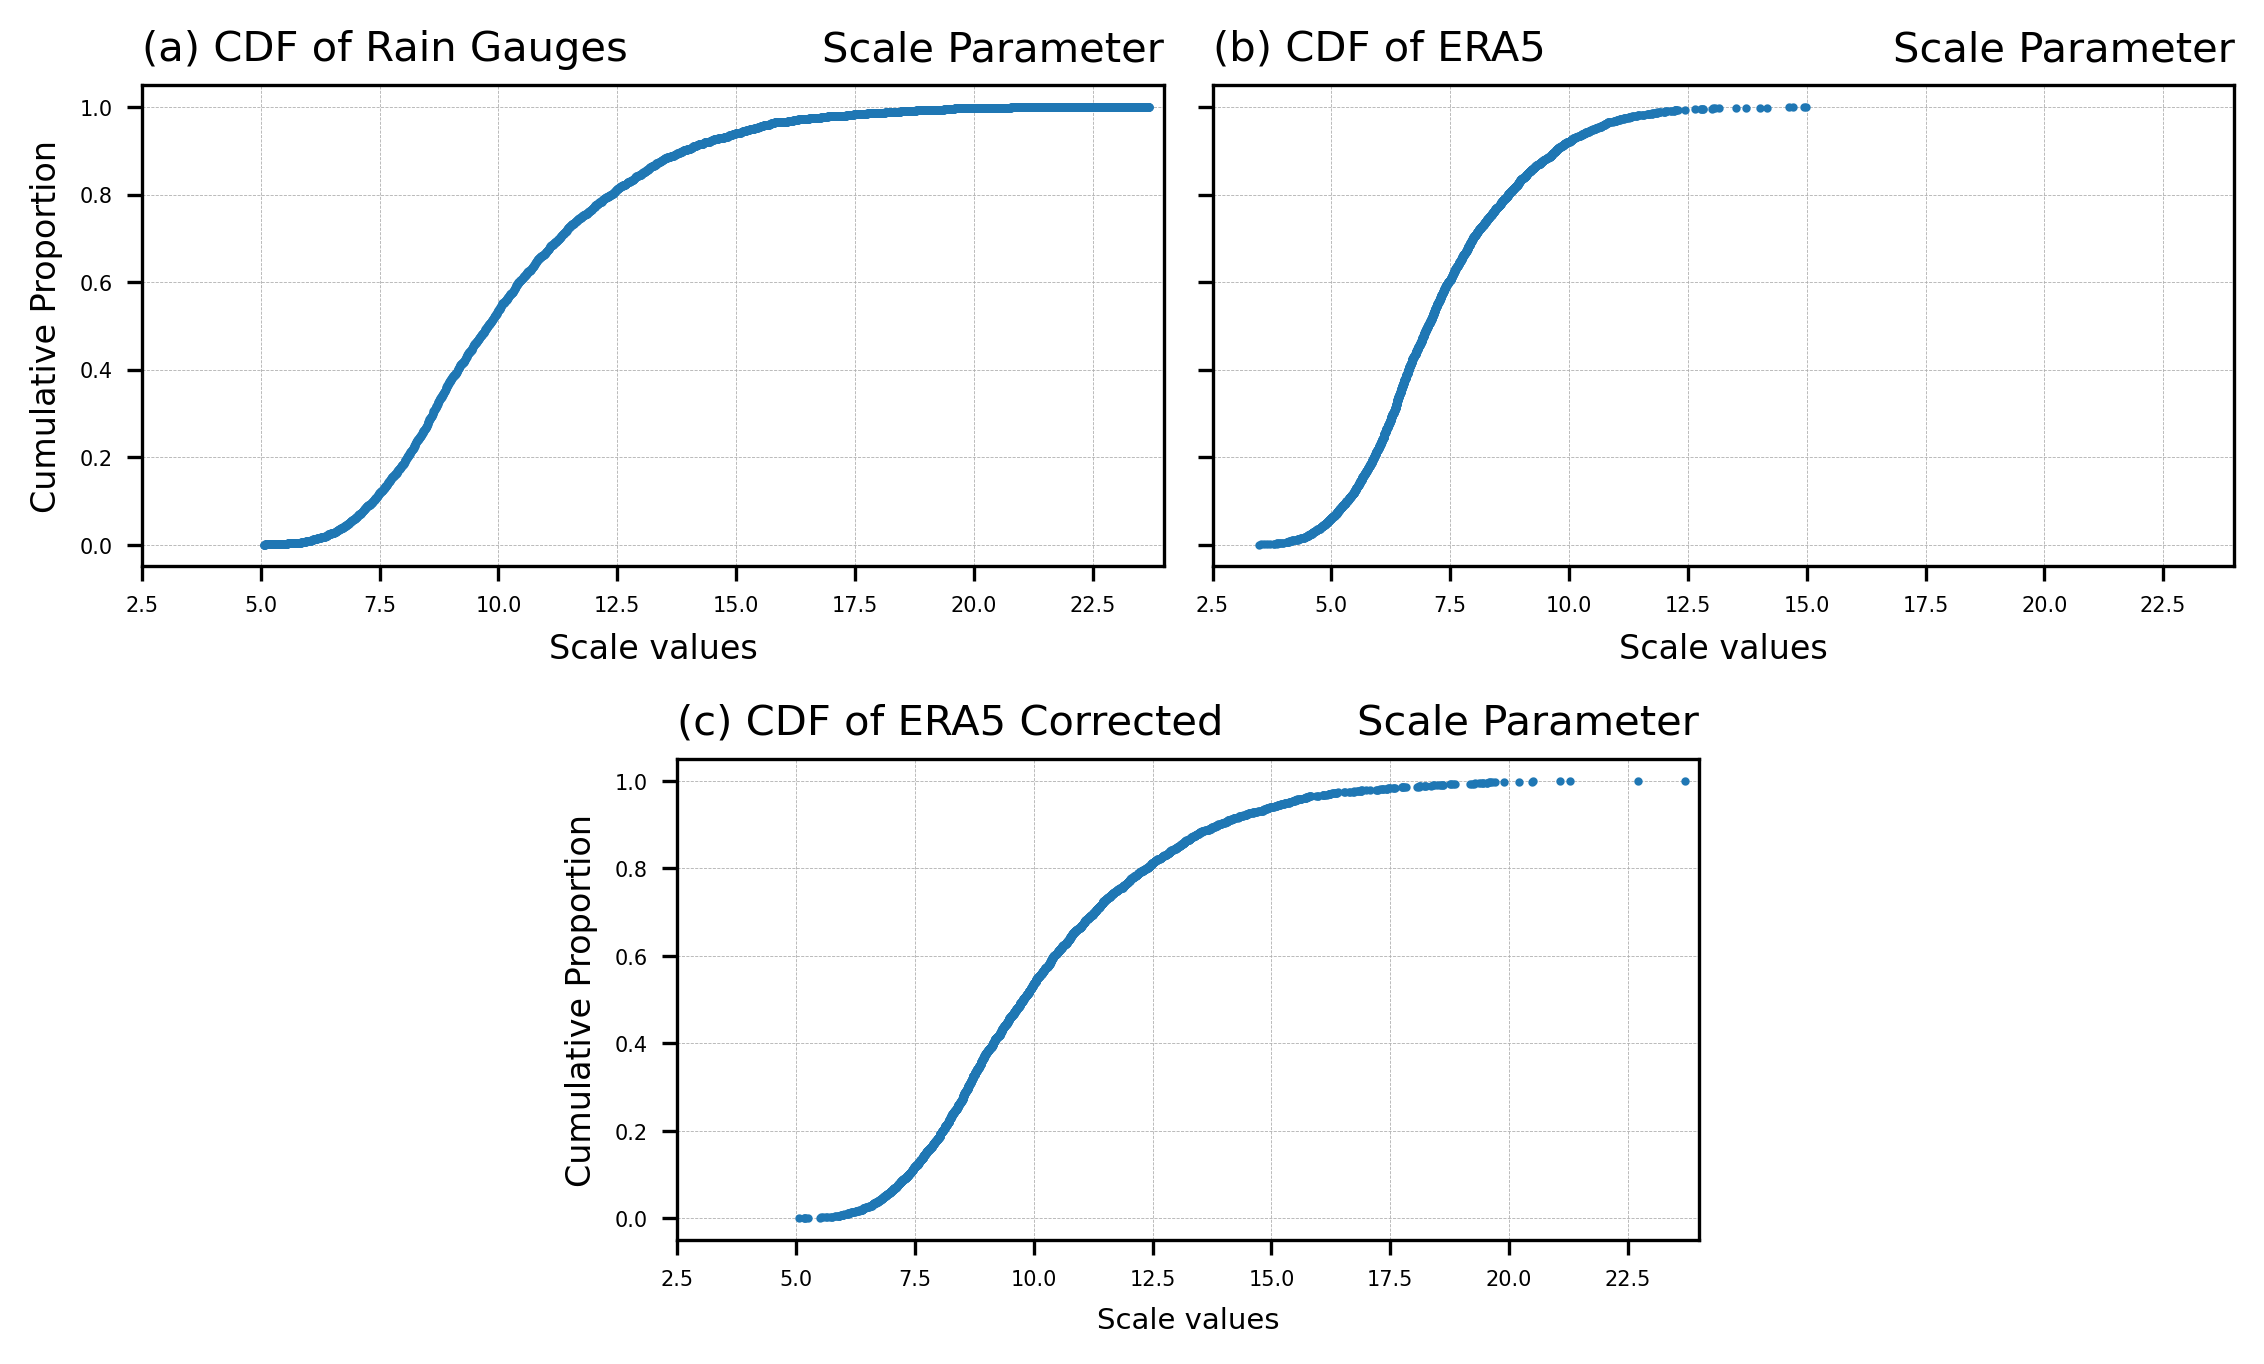

In [43]:
fig = plt.figure(figsize=(9,5),dpi=300)
gs = gridspec.GridSpec(2,4)

# =================================================================
ax1 = plt.subplot(gs[0, 0:2])

OBS_sorted_data = np.sort(OBS_C_vals)
original_cdf = np.arange(1, len(OBS_sorted_data)+1) / len(OBS_sorted_data)
OBS_cdf = np.arange(1, len(OBS_sorted_data)+1) / len(OBS_sorted_data)
x_interp = np.linspace(OBS_sorted_data.min(), OBS_sorted_data.max(), len(CdERA5.flatten()))
cdf_interp = np.interp(x_interp, OBS_sorted_data, original_cdf)

ax1.plot(x_interp, cdf_interp, marker='.', markersize=2, linestyle='none')
ax1.set_title('(a) CDF of Rain Gauges',fontsize=10,loc='left')
ax1.set_title('Scale Parameter',fontsize=10,loc='right')
ax1.set_xlabel('Scale values',fontsize=8)
ax1.set_ylabel('Cumulative Proportion',fontsize=8)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.2,linestyle='--')
ax1.set_xlim(2.5,24)

# =================================================================
ax1 = plt.subplot(gs[0, 2:])

ERA5_sorted_data = np.sort(CdERA5.flatten())
# ERA5_sorted_data = np.sort(ERA5_Q50d_CDFt.flatten())
ERA5_cdf = np.arange(1, len(ERA5_sorted_data)+1) / len(ERA5_sorted_data)

ax1.plot(ERA5_sorted_data, ERA5_cdf, marker='.', markersize=2, linestyle='none')
ax1.set_xlabel('Scale values',fontsize=8)
ax1.set_title('(b) CDF of ERA5',fontsize=10,loc='left')
ax1.set_title('Scale Parameter',fontsize=10,loc='right')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.2,linestyle='--')
ax1.set_xlim(2.5,24)
ax1.set_yticklabels([])

# =================================================================
ax1 = plt.subplot(gs[1, 1:3])

ERA5_sorted_data = np.sort(ERA5_CYd_CDFt.flatten())
ERA5_cdf = np.arange(1, len(ERA5_sorted_data)+1) / len(ERA5_sorted_data)

ax1.plot(ERA5_sorted_data, ERA5_cdf, marker='.', markersize=2, linestyle='none')
ax1.set_xlabel('Scale values',fontsize=7)
ax1.set_title('(c) CDF of ERA5 Corrected',fontsize=10,loc='left')
ax1.set_title('Scale Parameter',fontsize=10,loc='right')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.2,linestyle='--')
ax1.set_xlim(2.5,24)
ax1.set_ylabel('Cumulative Proportion',fontsize=8)

# =================================================================
plt.subplots_adjust(wspace=0.1, hspace=0.4)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [44]:
print(np.nanmin(np.nanmean(WdERA5,axis=0)),np.nanmin(np.nanmean(ERA5_WYd_CDFt,axis=0)))
print(np.nanmax(np.nanmean(WdERA5,axis=0)),np.nanmax(np.nanmean(ERA5_WYd_CDFt,axis=0)))

0.6915236756501537 0.6663919045363382
0.997660094996911 0.973244750649067


In [45]:
N_level = np.arange(60,230,10)
N_norm = mcolors.BoundaryNorm(boundaries=N_level, ncolors=256)

C_level = np.arange(5,18,1)
C_norm = mcolors.BoundaryNorm(boundaries=C_level, ncolors=256)

W_level = np.arange(0.6,1.05,0.05)
W_norm = mcolors.BoundaryNorm(boundaries=W_level, ncolors=256)

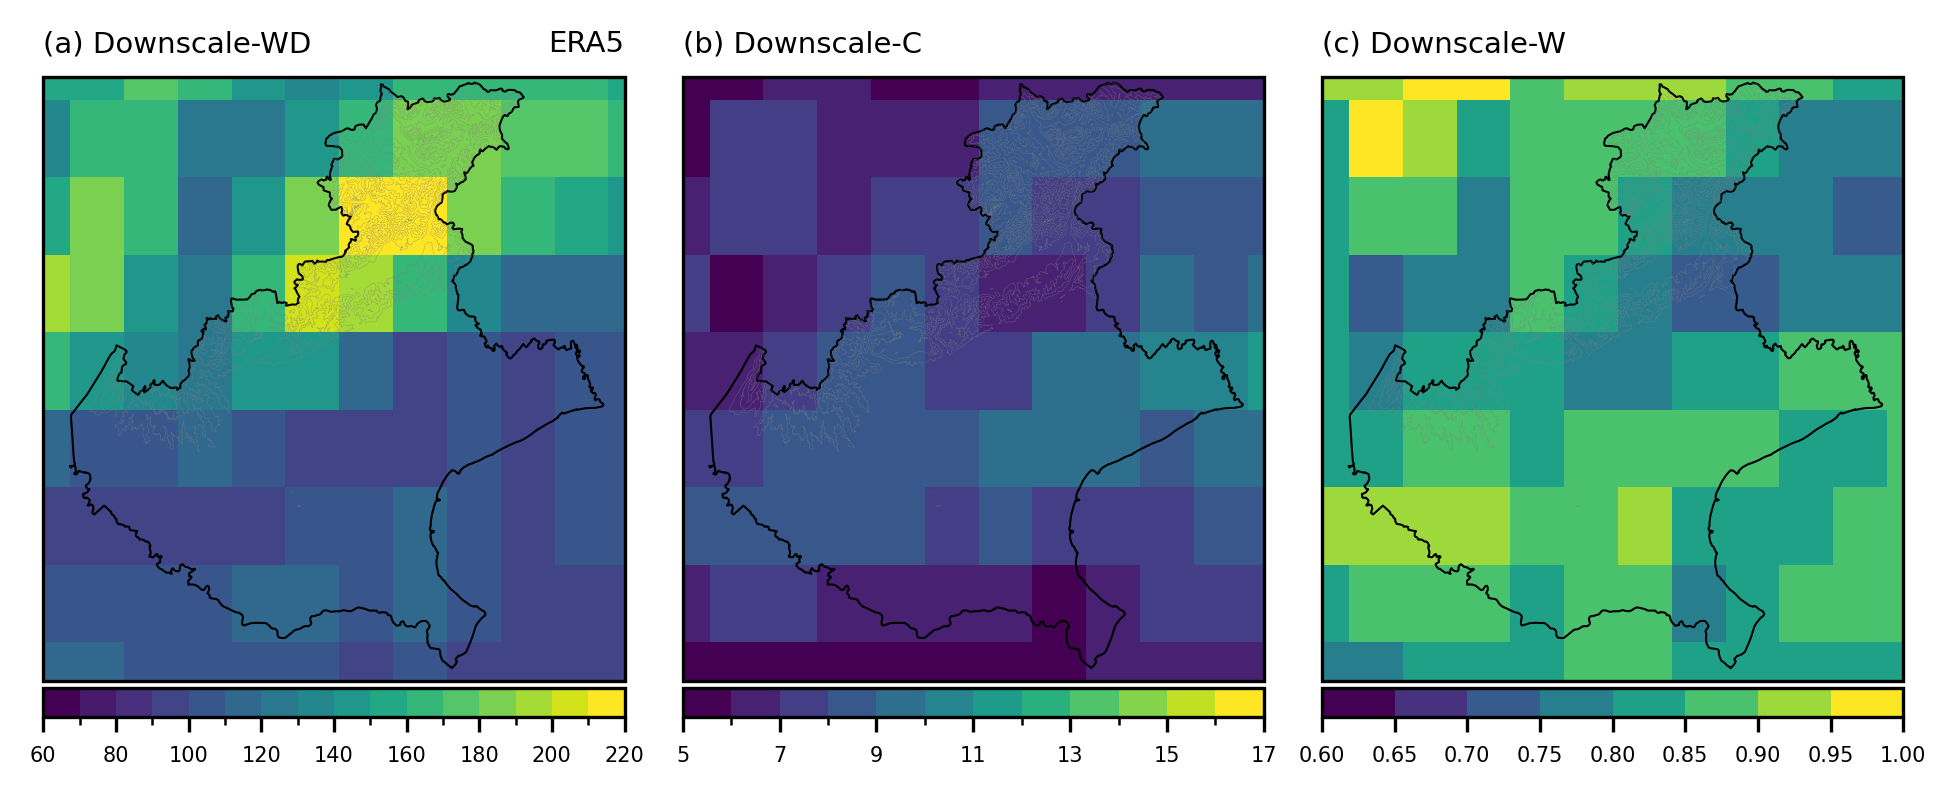

In [46]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,3),dpi=300)
gs = gridspec.GridSpec(1,3)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.75, 46.7],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
DEM.plot(facecolor='None',color='grey',alpha=0.6, ax=ax1, linewidth=0.1, zorder=10)

a1 = ax1.pcolormesh(lon2d_ERA5, lat2d_ERA5, np.nanmean(NdERA5,axis=0), norm=N_norm)

ax1.set_title(f'(a) Downscale-WD', fontsize=7, loc='left')
ax1.set_title(f'ERA5', fontsize=7, loc='right')

cbar = plt.colorbar(a1, ticks= None, orientation='horizontal', pad=0.01, fraction=0.045)
cbar.ax.tick_params(labelsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([10.5, 13.2, 44.75, 46.7],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
DEM.plot(facecolor='None',color='grey',alpha=0.6, ax=ax1, linewidth=0.1, zorder=10)

a1 = ax1.pcolormesh(lon2d_ERA5, lat2d_ERA5, np.nanmean(CdERA5,axis=0), norm=C_norm)

ax1.set_title(f'(b) Downscale-C', fontsize=7, loc='left')

cbar = plt.colorbar(a1, ticks= None, orientation='horizontal', pad=0.01, fraction=0.045)
cbar.ax.tick_params(labelsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([10.5, 13.2, 44.75, 46.7],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
DEM.plot(facecolor='None',color='grey',alpha=0.6, ax=ax1, linewidth=0.1, zorder=10)

a1 = ax1.pcolormesh(lon2d_ERA5, lat2d_ERA5, np.nanmean(WdERA5,axis=0), norm=W_norm)

ax1.set_title(f'(c) Downscale-W', fontsize=7, loc='left')

cbar = plt.colorbar(a1, ticks= None, orientation='horizontal', pad=0.01, fraction=0.045)
cbar.ax.tick_params(labelsize=5)

# ============================================================================================================================
plt.subplots_adjust(wspace=0.1, hspace=0.1)


ax1.set_facecolor('white')
fig.patch.set_alpha(0)

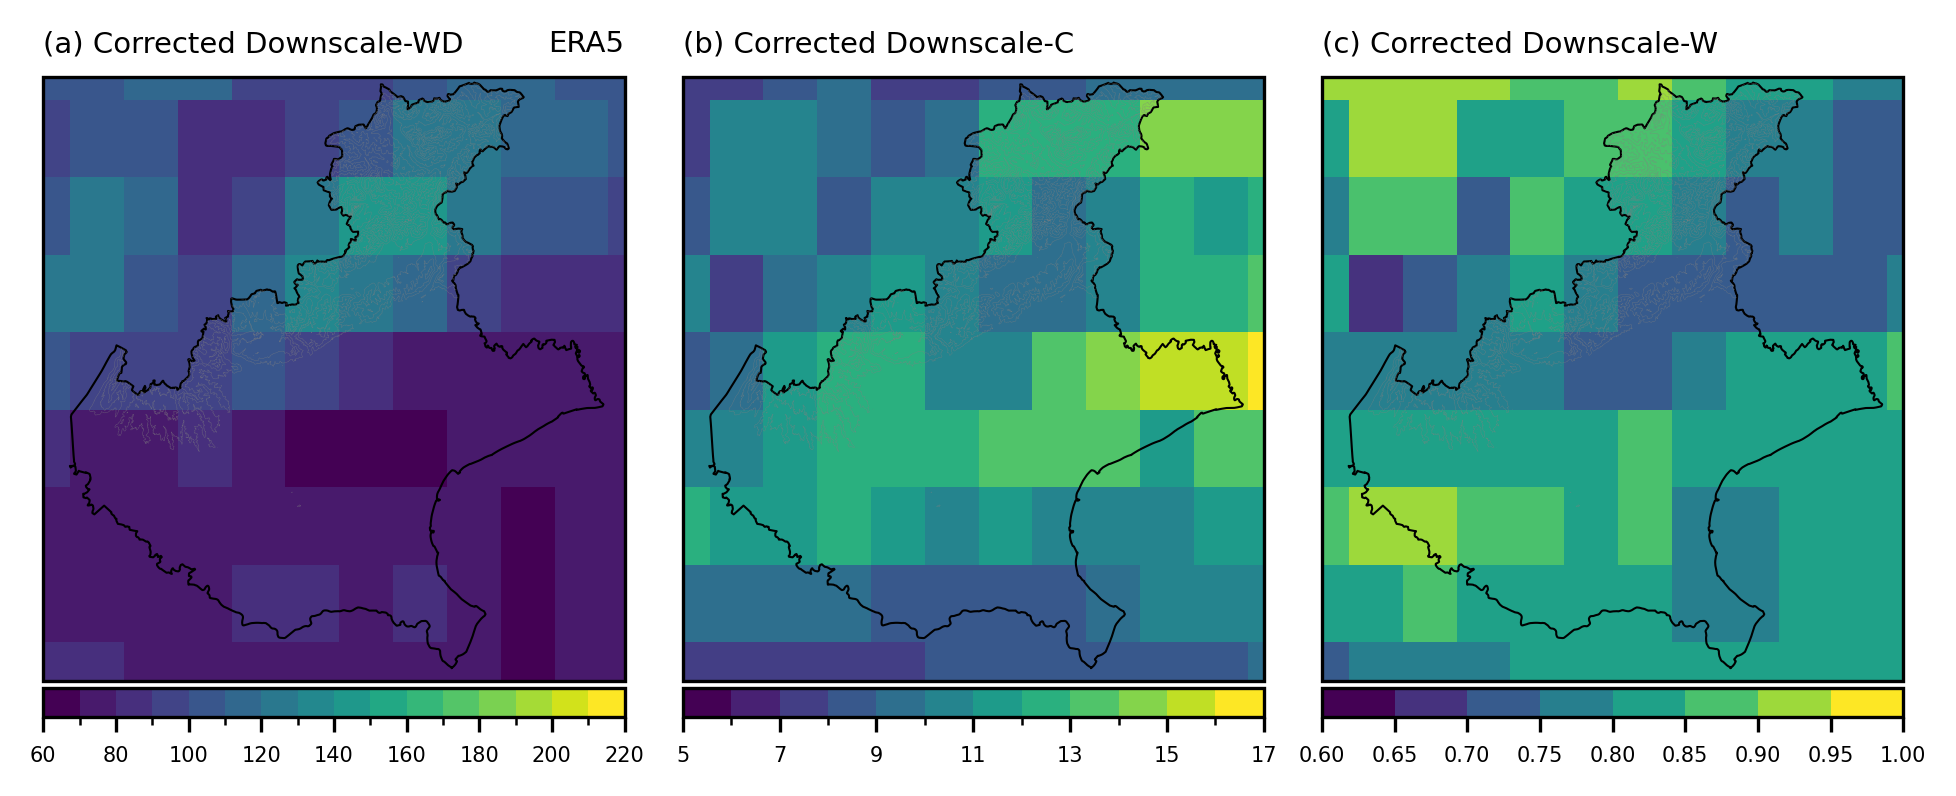

In [47]:
levels_obs = np.arange(50,510,10)
norm_obs = mcolors.BoundaryNorm(boundaries=levels_obs, ncolors=256)

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,3),dpi=300)
gs = gridspec.GridSpec(1,3)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.75, 46.7],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
DEM.plot(facecolor='None',color='grey',alpha=0.6, ax=ax1, linewidth=0.1, zorder=10)

a1 = ax1.pcolormesh(lon2d_ERA5, lat2d_ERA5, np.nanmean(ERA5_NYd_CDFt,axis=0), norm=N_norm)

ax1.set_title(f'(a) Corrected Downscale-WD', fontsize=7, loc='left')
ax1.set_title(f'ERA5', fontsize=7, loc='right')

cbar = plt.colorbar(a1, ticks= None, orientation='horizontal', pad=0.01, fraction=0.045)
cbar.ax.tick_params(labelsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([10.5, 13.2, 44.75, 46.7],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
DEM.plot(facecolor='None',color='grey',alpha=0.6, ax=ax1, linewidth=0.1, zorder=10)

a1 = ax1.pcolormesh(lon2d_ERA5, lat2d_ERA5, np.nanmean(ERA5_CYd_CDFt,axis=0), norm=C_norm)

ax1.set_title(f'(b) Corrected Downscale-C', fontsize=7, loc='left')

cbar = plt.colorbar(a1, ticks= None, orientation='horizontal', pad=0.01, fraction=0.045)
cbar.ax.tick_params(labelsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([10.5, 13.2, 44.75, 46.7],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
DEM.plot(facecolor='None',color='grey',alpha=0.6, ax=ax1, linewidth=0.1, zorder=10)

a1 = ax1.pcolormesh(lon2d_ERA5, lat2d_ERA5, np.nanmean(ERA5_WYd_CDFt,axis=0), norm=W_norm)

ax1.set_title(f'(c) Corrected Downscale-W', fontsize=7, loc='left')

cbar = plt.colorbar(a1, ticks= None, orientation='horizontal', pad=0.01, fraction=0.045)
cbar.ax.tick_params(labelsize=5)

# ============================================================================================================================
plt.subplots_adjust(wspace=0.1, hspace=0.1)


ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [48]:
## GSMaP BIAS CORRECTION
GSMaP_NYd_CDFt = ISIMIP_QM(OBS_N_vals, NdGSMAP.flatten())
GSMaP_CYd_CDFt = ISIMIP_QM(OBS_C_vals, CdGSMAP.flatten())
GSMaP_WYd_CDFt = ISIMIP_QM(OBS_W_vals, WdGSMAP.flatten())

GSMaP_NYd_CDFt = GSMaP_NYd_CDFt.reshape(NdGSMAP.shape[0],NdGSMAP.shape[1],NdGSMAP.shape[2])
GSMaP_CYd_CDFt = GSMaP_CYd_CDFt.reshape(CdGSMAP.shape[0],CdGSMAP.shape[1],CdGSMAP.shape[2])
GSMaP_WYd_CDFt = GSMaP_WYd_CDFt.reshape(WdGSMAP.shape[0],WdGSMAP.shape[1],WdGSMAP.shape[2])

GSMaP_QYd_CDFt = ART_down.pre_quantiles_array(
                        GSMaP_NYd_CDFt, 
                        GSMaP_CYd_CDFt, 
                        GSMaP_WYd_CDFt, 
                        Tr, 
                        lats_GSMaP, lons_GSMaP, 
                        1)

In [49]:
## PERSIANN BIAS CORRECTION
PERSIANN_NYd_CDFt = ISIMIP_QM(OBS_N_vals, NdPERSIANN.flatten())
PERSIANN_CYd_CDFt = ISIMIP_QM(OBS_C_vals, CdPERSIANN.flatten())
PERSIANN_WYd_CDFt = ISIMIP_QM(OBS_W_vals, WdPERSIANN.flatten())

PERSIANN_NYd_CDFt = PERSIANN_NYd_CDFt.reshape(NdPERSIANN.shape[0],NdPERSIANN.shape[1],NdPERSIANN.shape[2])
PERSIANN_CYd_CDFt = PERSIANN_CYd_CDFt.reshape(CdPERSIANN.shape[0],CdPERSIANN.shape[1],CdPERSIANN.shape[2])
PERSIANN_WYd_CDFt = PERSIANN_WYd_CDFt.reshape(WdPERSIANN.shape[0],WdPERSIANN.shape[1],WdPERSIANN.shape[2])

PERSIANN_QYd_CDFt = ART_down.pre_quantiles_array(
                        PERSIANN_NYd_CDFt, 
                        PERSIANN_CYd_CDFt, 
                        PERSIANN_WYd_CDFt, 
                        Tr, 
                        lats_PERSIANN, lons_PERSIANN, 
                        1)

In [50]:
## CHIRPS BIAS CORRECTION
CHIRPS_NYd_CDFt = ISIMIP_QM(OBS_N_vals, NdCHIRPS.flatten())
CHIRPS_CYd_CDFt = ISIMIP_QM(OBS_C_vals, CdCHIRPS.flatten())
CHIRPS_WYd_CDFt = ISIMIP_QM(OBS_W_vals, WdCHIRPS.flatten())

CHIRPS_NYd_CDFt = CHIRPS_NYd_CDFt.reshape(NdCHIRPS.shape[0],NdCHIRPS.shape[1],NdCHIRPS.shape[2])
CHIRPS_CYd_CDFt = CHIRPS_CYd_CDFt.reshape(CdCHIRPS.shape[0],CdCHIRPS.shape[1],CdCHIRPS.shape[2])
CHIRPS_WYd_CDFt = CHIRPS_WYd_CDFt.reshape(WdCHIRPS.shape[0],WdCHIRPS.shape[1],WdCHIRPS.shape[2])

CHIRPS_QYd_CDFt = ART_down.pre_quantiles_array(
                        CHIRPS_NYd_CDFt, 
                        CHIRPS_CYd_CDFt, 
                        CHIRPS_WYd_CDFt, 
                        Tr, 
                        lats_CHIRPS, lons_CHIRPS, 
                        1)

In [51]:
ERA5_NYd_list, ERA5_NYd_CDFt_list = [], []
ERA5_CYd_list, ERA5_CYd_CDFt_list = [], []
ERA5_WYd_list, ERA5_WYd_CDFt_list = [], []
ERA5_QYd_CDFt_list = []

IMERG_NYd_list, IMERG_NYd_CDFt_list = [], []
IMERG_CYd_list, IMERG_CYd_CDFt_list = [], []
IMERG_WYd_list, IMERG_WYd_CDFt_list = [], []
IMERG_QYd_CDFt_list = []

CMORPH_NYd_list, CMORPH_NYd_CDFt_list = [], []
CMORPH_CYd_list, CMORPH_CYd_CDFt_list = [], []
CMORPH_WYd_list, CMORPH_WYd_CDFt_list = [], []
CMORPH_QYd_CDFt_list = []

MSWEP_NYd_list, MSWEP_NYd_CDFt_list = [], []
MSWEP_CYd_list, MSWEP_CYd_CDFt_list = [], []
MSWEP_WYd_list, MSWEP_WYd_CDFt_list = [], []
MSWEP_QYd_CDFt_list = []

GSMaP_NYd_list, GSMaP_NYd_CDFt_list = [], []
GSMaP_CYd_list, GSMaP_CYd_CDFt_list = [], []
GSMaP_WYd_list, GSMaP_WYd_CDFt_list = [], []
GSMaP_QYd_CDFt_list = []

PERSIANN_NYd_list, PERSIANN_NYd_CDFt_list = [], []
PERSIANN_CYd_list, PERSIANN_CYd_CDFt_list = [], []
PERSIANN_WYd_list, PERSIANN_WYd_CDFt_list = [], []
PERSIANN_QYd_CDFt_list = []

CHIRPS_NYd_list, CHIRPS_NYd_CDFt_list = [], []
CHIRPS_CYd_list, CHIRPS_CYd_CDFt_list = [], []
CHIRPS_WYd_list, CHIRPS_WYd_CDFt_list = [], []
CHIRPS_QYd_CDFt_list = []

for nn in range(len(Q_80)):
    Q_OBS = Q_80['Q50'].values[nn]
    lat_obs = Q_80['Lat'].values[nn]
    lon_obs = Q_80['Lon'].values[nn]

    # =======================================================================
    # IMERG
    distances = ART_pre.haversine(lat2d_IMERG, lon2d_IMERG, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    # print(min_index[0],min_index[1])

    # Weibull Parameters for Non-Corrected and Corrected
    IMERG_NYd_list.extend(NdIMERG[:,min_index[0],min_index[1]])
    IMERG_CYd_list.extend(CdIMERG[:,min_index[0],min_index[1]])
    IMERG_WYd_list.extend(WdIMERG[:,min_index[0],min_index[1]])

    IMERG_NYd_CDFt_list.extend(IMERG_NYd_CDFt[:,min_index[0],min_index[1]])
    IMERG_CYd_CDFt_list.extend(IMERG_CYd_CDFt[:,min_index[0],min_index[1]])
    IMERG_WYd_CDFt_list.extend(IMERG_WYd_CDFt[:,min_index[0],min_index[1]])

    # Quantiles
    # print(IMERG_QYd_CDFt[3,min_index[0],min_index[1]])
    IMERG_QYd_CDFt_list.append(IMERG_QYd_CDFt[3,min_index[0],min_index[1]])

    # =======================================================================
    # MSWEP
    distances = ART_pre.haversine(lat2d_MSWEP, lon2d_MSWEP, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

    # Weibull Parameters for Non-Corrected and Corrected
    MSWEP_NYd_list.extend(NdMSWEP[:,min_index[0],min_index[1]])
    MSWEP_CYd_list.extend(CdMSWEP[:,min_index[0],min_index[1]])
    MSWEP_WYd_list.extend(WdMSWEP[:,min_index[0],min_index[1]])

    MSWEP_NYd_CDFt_list.extend(MSWEP_NYd_CDFt[:,min_index[0],min_index[1]])
    MSWEP_CYd_CDFt_list.extend(MSWEP_CYd_CDFt[:,min_index[0],min_index[1]])
    MSWEP_WYd_CDFt_list.extend(MSWEP_WYd_CDFt[:,min_index[0],min_index[1]])

    # Quantiles
    MSWEP_QYd_CDFt_list.append(MSWEP_QYd_CDFt[3,min_index[0],min_index[1]])

    # =======================================================================
    # CMORPH
    distances = ART_pre.haversine(lat2d_CMORPH, lon2d_CMORPH , lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

    # Weibull Parameters for Non-Corrected and Corrected
    CMORPH_NYd_list.extend(NdCMORPH[:,min_index[0],min_index[1]])
    CMORPH_CYd_list.extend(CdCMORPH[:,min_index[0],min_index[1]])
    CMORPH_WYd_list.extend(WdCMORPH[:,min_index[0],min_index[1]])

    CMORPH_NYd_CDFt_list.extend(CMORPH_NYd_CDFt[:,min_index[0],min_index[1]])
    CMORPH_CYd_CDFt_list.extend(CMORPH_CYd_CDFt[:,min_index[0],min_index[1]])
    CMORPH_WYd_CDFt_list.extend(CMORPH_WYd_CDFt[:,min_index[0],min_index[1]])

    # Quantiles
    CMORPH_QYd_CDFt_list.append(CMORPH_QYd_CDFt[3,min_index[0],min_index[1]])

    # =======================================================================
    # ERA5
    distances = ART_pre.haversine(lat2d_ERA5, lon2d_ERA5, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

    # Weibull Parameters for Non-Corrected and Corrected
    ERA5_NYd_list.extend(NdERA5[:,min_index[0],min_index[1]])
    ERA5_CYd_list.extend(CdERA5[:,min_index[0],min_index[1]])
    ERA5_WYd_list.extend(WdERA5[:,min_index[0],min_index[1]])

    ERA5_NYd_CDFt_list.extend(ERA5_NYd_CDFt[:,min_index[0],min_index[1]])
    ERA5_CYd_CDFt_list.extend(ERA5_CYd_CDFt[:,min_index[0],min_index[1]])
    ERA5_WYd_CDFt_list.extend(ERA5_WYd_CDFt[:,min_index[0],min_index[1]])

    # Quantiles
    ERA5_QYd_CDFt_list.append(ERA5_QYd_CDFt[3,min_index[0],min_index[1]])

    # =======================================================================
    # GSMaP
    distances = ART_pre.haversine(lat2d_GSMaP, lon2d_GSMaP, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

    # Weibull Parameters for Non-Corrected and Corrected
    GSMaP_NYd_list.extend(NdGSMAP[:,min_index[0],min_index[1]])
    GSMaP_CYd_list.extend(CdGSMAP[:,min_index[0],min_index[1]])
    GSMaP_WYd_list.extend(WdGSMAP[:,min_index[0],min_index[1]])

    GSMaP_NYd_CDFt_list.extend(GSMaP_NYd_CDFt[:,min_index[0],min_index[1]])
    GSMaP_CYd_CDFt_list.extend(GSMaP_CYd_CDFt[:,min_index[0],min_index[1]])
    GSMaP_WYd_CDFt_list.extend(GSMaP_WYd_CDFt[:,min_index[0],min_index[1]])

    # Quantiles
    GSMaP_QYd_CDFt_list.append(GSMaP_QYd_CDFt[3,min_index[0],min_index[1]])

    # =======================================================================
    # PERSIANN
    distances = ART_pre.haversine(lat2d_PERSIANN, lon2d_PERSIANN, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

    # Weibull Parameters for Non-Corrected and Corrected
    PERSIANN_NYd_list.extend(NdPERSIANN[:,min_index[0],min_index[1]])
    PERSIANN_CYd_list.extend(CdPERSIANN[:,min_index[0],min_index[1]])
    PERSIANN_WYd_list.extend(WdPERSIANN[:,min_index[0],min_index[1]])

    PERSIANN_NYd_CDFt_list.extend(PERSIANN_NYd_CDFt[:,min_index[0],min_index[1]])
    PERSIANN_CYd_CDFt_list.extend(PERSIANN_CYd_CDFt[:,min_index[0],min_index[1]])
    PERSIANN_WYd_CDFt_list.extend(PERSIANN_WYd_CDFt[:,min_index[0],min_index[1]])

    # Quantiles
    PERSIANN_QYd_CDFt_list.append(PERSIANN_QYd_CDFt[3,min_index[0],min_index[1]])
    
    # =======================================================================
    # CHIRPS
    distances = ART_pre.haversine(lat2d_CHIRPS, lon2d_CHIRPS, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

    # Weibull Parameters for Non-Corrected and Corrected
    CHIRPS_NYd_list.extend(NdCHIRPS[:,min_index[0],min_index[1]])
    CHIRPS_CYd_list.extend(CdCHIRPS[:,min_index[0],min_index[1]])
    CHIRPS_WYd_list.extend(WdCHIRPS[:,min_index[0],min_index[1]])

    CHIRPS_NYd_CDFt_list.extend(CHIRPS_NYd_CDFt[:,min_index[0],min_index[1]])
    CHIRPS_CYd_CDFt_list.extend(CHIRPS_CYd_CDFt[:,min_index[0],min_index[1]])
    CHIRPS_WYd_CDFt_list.extend(CHIRPS_WYd_CDFt[:,min_index[0],min_index[1]])

    # Quantiles
    CHIRPS_QYd_CDFt_list.append(CHIRPS_QYd_CDFt[3,min_index[0],min_index[1]])

In [52]:
SATELLITE_pd['ERA5_Q50d_CDFt'] = ERA5_QYd_CDFt_list
SATELLITE_pd['IMERG_Q50d_CDFt'] = IMERG_QYd_CDFt_list
SATELLITE_pd['CMORPH_Q50d_CDFt'] = CMORPH_QYd_CDFt_list
SATELLITE_pd['MSWEP_Q50d_CDFt'] = MSWEP_QYd_CDFt_list
SATELLITE_pd['GSMaP_Q50d_CDFt'] = GSMaP_QYd_CDFt_list
SATELLITE_pd['PERSIANN_Q50d_CDFt'] = PERSIANN_QYd_CDFt_list
SATELLITE_pd['CHIRPS_Q50d_CDFt'] = CHIRPS_QYd_CDFt_list

## ERA5

In [53]:
REG_ERA5_N = vector_slope_intercept(OBS_N_vals, ERA5_NYd_list)
REG_ERA5_N_CDFt = vector_slope_intercept(OBS_N_vals, ERA5_NYd_CDFt_list)

REG_ERA5_C = vector_slope_intercept(OBS_C_vals, ERA5_CYd_list)
REG_ERA5_C_CDFt = vector_slope_intercept(OBS_C_vals, ERA5_CYd_CDFt_list)

REG_ERA5_W = vector_slope_intercept(OBS_W_vals, ERA5_WYd_list)
REG_ERA5_W_CDFt = vector_slope_intercept(OBS_W_vals, ERA5_WYd_CDFt_list)

ERA5_QEd_CDFt = (SATELLITE_pd['ERA5_Q50d_CDFt']-SATELLITE_pd['OBS'])/SATELLITE_pd['OBS']

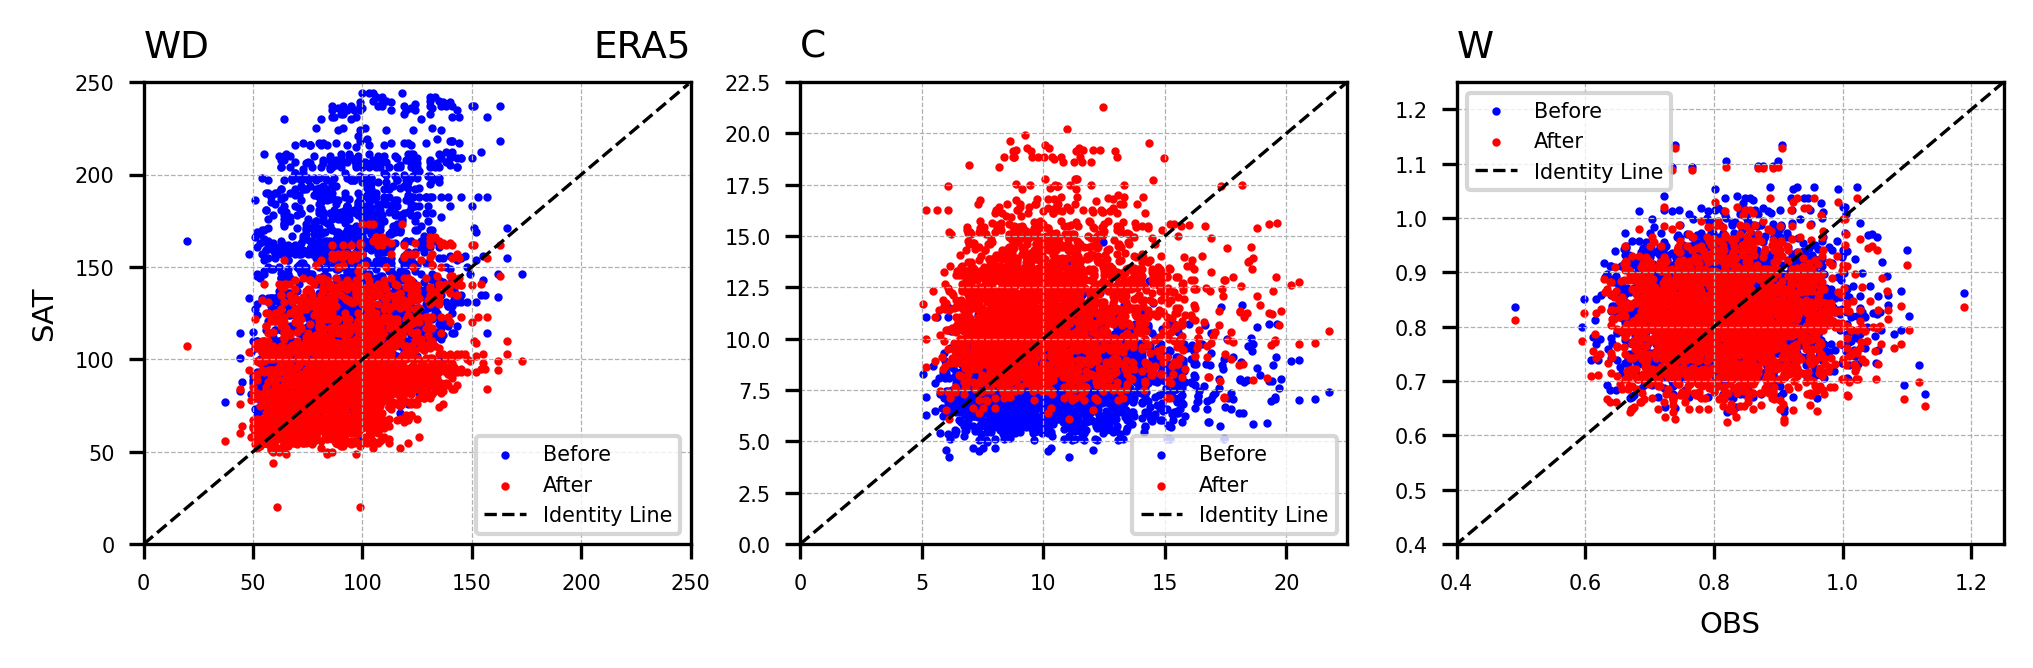

In [54]:
fig = plt.figure(figsize=(8,2),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(OBS_N_vals, ERA5_NYd_list,c='b',s=1,label='Before')
ax1.scatter(OBS_N_vals, ERA5_NYd_CDFt_list,c='r',s=1,label='After')

# ax1.plot(REG_ERA5_N[0],REG_ERA5_N[1],color='b',linewidth=0.8,linestyle='--',zorder=10)
# ax1.plot(REG_ERA5_N_CDFt[0],REG_ERA5_N_CDFt[1],color='r',linewidth=0.8,linestyle='--',zorder=10)

ax1.plot(np.arange(250),np.arange(250),'--k',linewidth=0.8,label='Identity Line')

plt.legend(fontsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('WD',fontsize=9,loc='left')
ax1.set_title('ERA5',fontsize=9,loc='right')
ax1.set_ylabel('SAT',fontsize=7)
ax1.set_xlim(0,250)
ax1.set_ylim(0,250)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.scatter(OBS_C_vals, ERA5_CYd_list,c='b',s=1,label='Before')
ax1.scatter(OBS_C_vals, ERA5_CYd_CDFt_list,c='r',s=1,label='After')


ax1.plot(np.arange(0,24),np.arange(0,24),'--k',linewidth=0.8,label='Identity Line')

plt.legend(fontsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('C',fontsize=9,loc='left')
ax1.set_xlim(0,22.5)
ax1.set_ylim(0,22.5)

# ==============================================================================
ax1 = plt.subplot(gs[0, 2])
ax1.scatter(OBS_W_vals, ERA5_WYd_list,c='b',s=1,label='Before')
ax1.scatter(OBS_W_vals, ERA5_WYd_CDFt_list,c='r',s=1,label='After')

ax1.plot(np.arange(0.25,1.7),np.arange(0.25,1.7),'--k',linewidth=0.8,label='Identity Line')

plt.legend(fontsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('W',fontsize=9,loc='left')
ax1.set_xlabel('OBS',fontsize=7)
ax1.set_xlim(0.4,1.25)
ax1.set_ylim(0.4,1.25)

# ==============================================================================
ax1.set_facecolor('white')
fig.patch.set_alpha(0)

Text(0.5, 0, 'Relative Error')

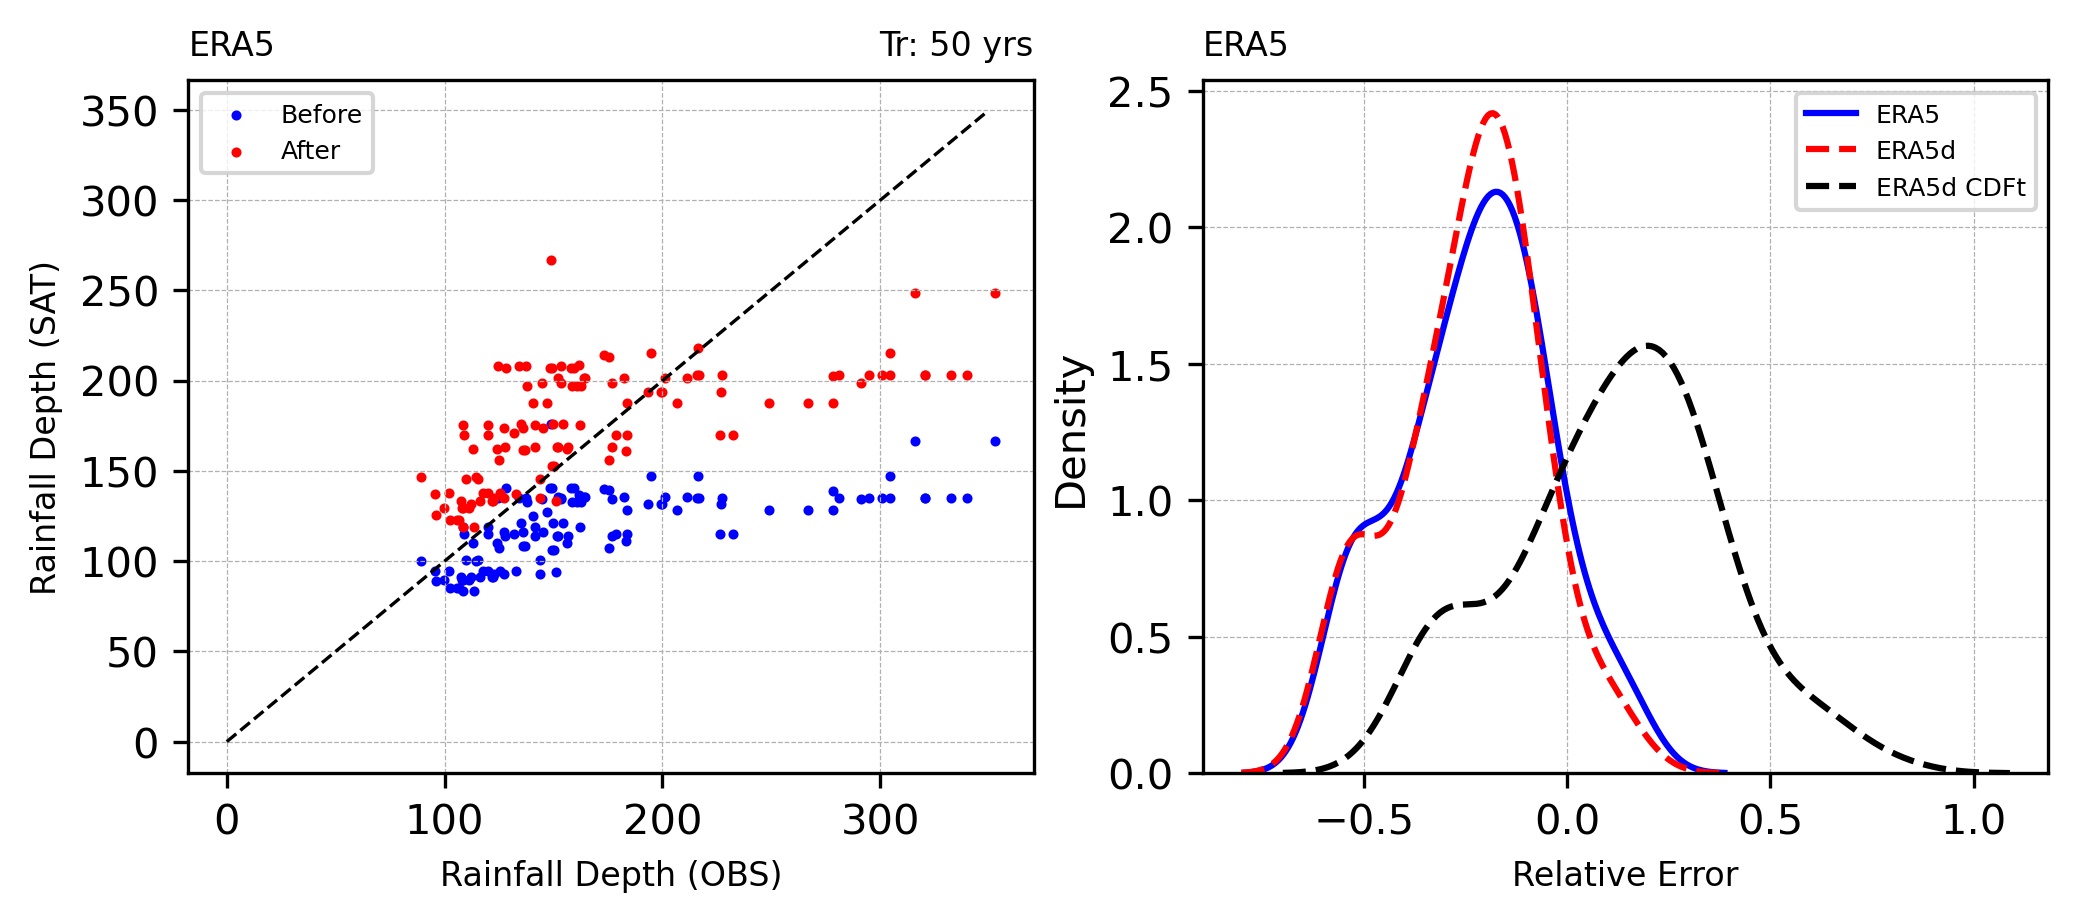

In [55]:
fig = plt.figure(figsize=(8,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(SATELLITE_pd['OBS'],SATELLITE_pd['ERA5d'],c='b',s=2,label='Before')
ax1.scatter(SATELLITE_pd['OBS'],SATELLITE_pd['ERA5_Q50d_CDFt'],c='r',s=2,label='After')
ax1.plot(np.arange(350),np.arange(350),'--k',linewidth=0.8)

plt.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('ERA5',fontsize=8,loc='left')
ax1.set_title('Tr: 50 yrs',fontsize=8,loc='right')
ax1.set_xlabel('Rainfall Depth (OBS)',fontsize=8)
ax1.set_ylabel('Rainfall Depth (SAT)',fontsize=8)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
sns.kdeplot(ERA5_QEs,color='b',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ERA5')
sns.kdeplot(ERA5_QEd,color='r',linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ERA5d')
sns.kdeplot(ERA5_QEd_CDFt,color='k',linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ERA5d CDFt')

ax1.set_title('ERA5',fontsize=8,loc='left')
ax1.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlabel('Relative Error',fontsize=8)

## IMERG

In [56]:
REG_IMERG_N = vector_slope_intercept(OBS_N_vals, IMERG_NYd_list)
REG_IMERG_N_CDFt = vector_slope_intercept(OBS_N_vals, IMERG_NYd_CDFt_list)

REG_IMERG_C = vector_slope_intercept(OBS_C_vals, IMERG_CYd_list)
REG_IMERG_C_CDFt = vector_slope_intercept(OBS_N_vals, IMERG_CYd_CDFt_list)

REG_IMERG_W = vector_slope_intercept(OBS_W_vals, IMERG_WYd_list)
REG_IMERG_W_CDFt = vector_slope_intercept(OBS_N_vals, IMERG_WYd_CDFt_list)

IMERG_QEd_CDFt = (SATELLITE_pd['IMERG_Q50d_CDFt']-SATELLITE_pd['OBS'])/SATELLITE_pd['OBS']

Text(0.5, 0, 'OBS')

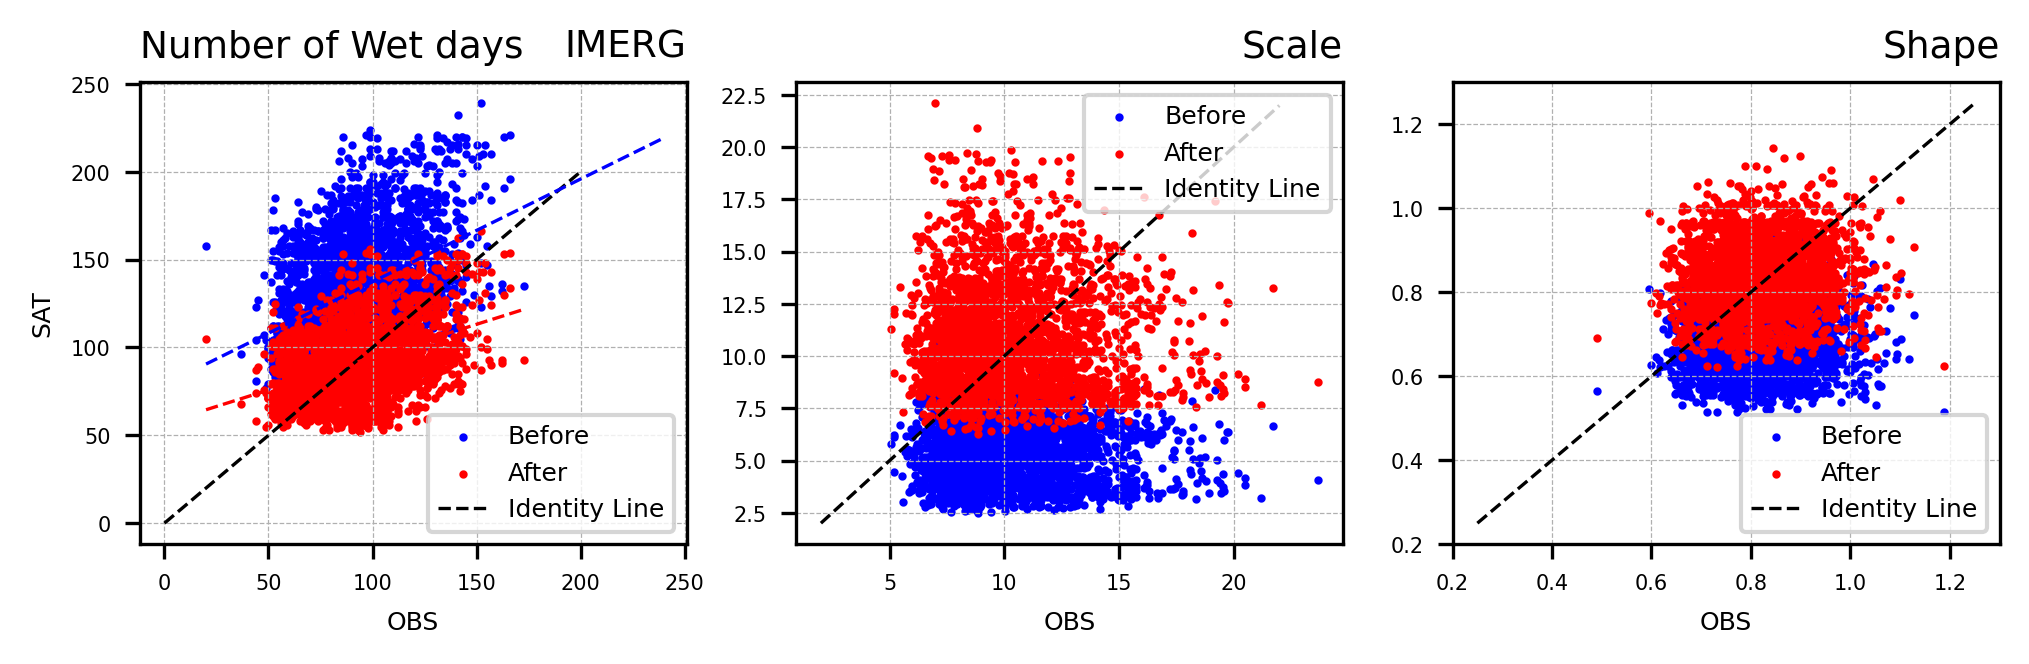

In [57]:
fig = plt.figure(figsize=(8,2),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(OBS_N_vals, IMERG_NYd_list,c='b',s=1,label='Before')
ax1.scatter(OBS_N_vals, IMERG_NYd_CDFt_list,c='r',s=1,label='After')

ax1.plot(REG_IMERG_N[0],REG_IMERG_N[1],color='b',linewidth=0.8,linestyle='--',zorder=10)
ax1.plot(REG_IMERG_N_CDFt[0],REG_IMERG_N_CDFt[1],color='r',linewidth=0.8,linestyle='--',zorder=10)

ax1.plot(np.arange(200),np.arange(200),'--k',linewidth=0.8,label='Identity Line')

plt.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('Number of Wet days',fontsize=9,loc='left')
ax1.set_title('IMERG',fontsize=9,loc='right')
ax1.set_ylabel('SAT',fontsize=6)
ax1.set_xlabel('OBS',fontsize=6)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.scatter(OBS_C_vals, IMERG_CYd_list,c='b',s=1,label='Before')
ax1.scatter(OBS_C_vals, IMERG_CYd_CDFt_list,c='r',s=1,label='After')


ax1.plot(np.arange(2,23),np.arange(2,23),'--k',linewidth=0.8,label='Identity Line')

plt.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('Scale',fontsize=9,loc='right')
ax1.set_xlabel('OBS',fontsize=6)

# ==============================================================================
ax1 = plt.subplot(gs[0, 2])
ax1.scatter(OBS_W_vals, IMERG_WYd_list,c='b',s=1,label='Before')
ax1.scatter(OBS_W_vals, IMERG_WYd_CDFt_list,c='r',s=1,label='After')

ax1.plot(np.arange(0.25,1.7),np.arange(0.25,1.7),'--k',linewidth=0.8,label='Identity Line')

plt.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('Shape',fontsize=9,loc='right')
ax1.set_xlabel('OBS',fontsize=6)

Text(0.5, 0, 'Relative Error')

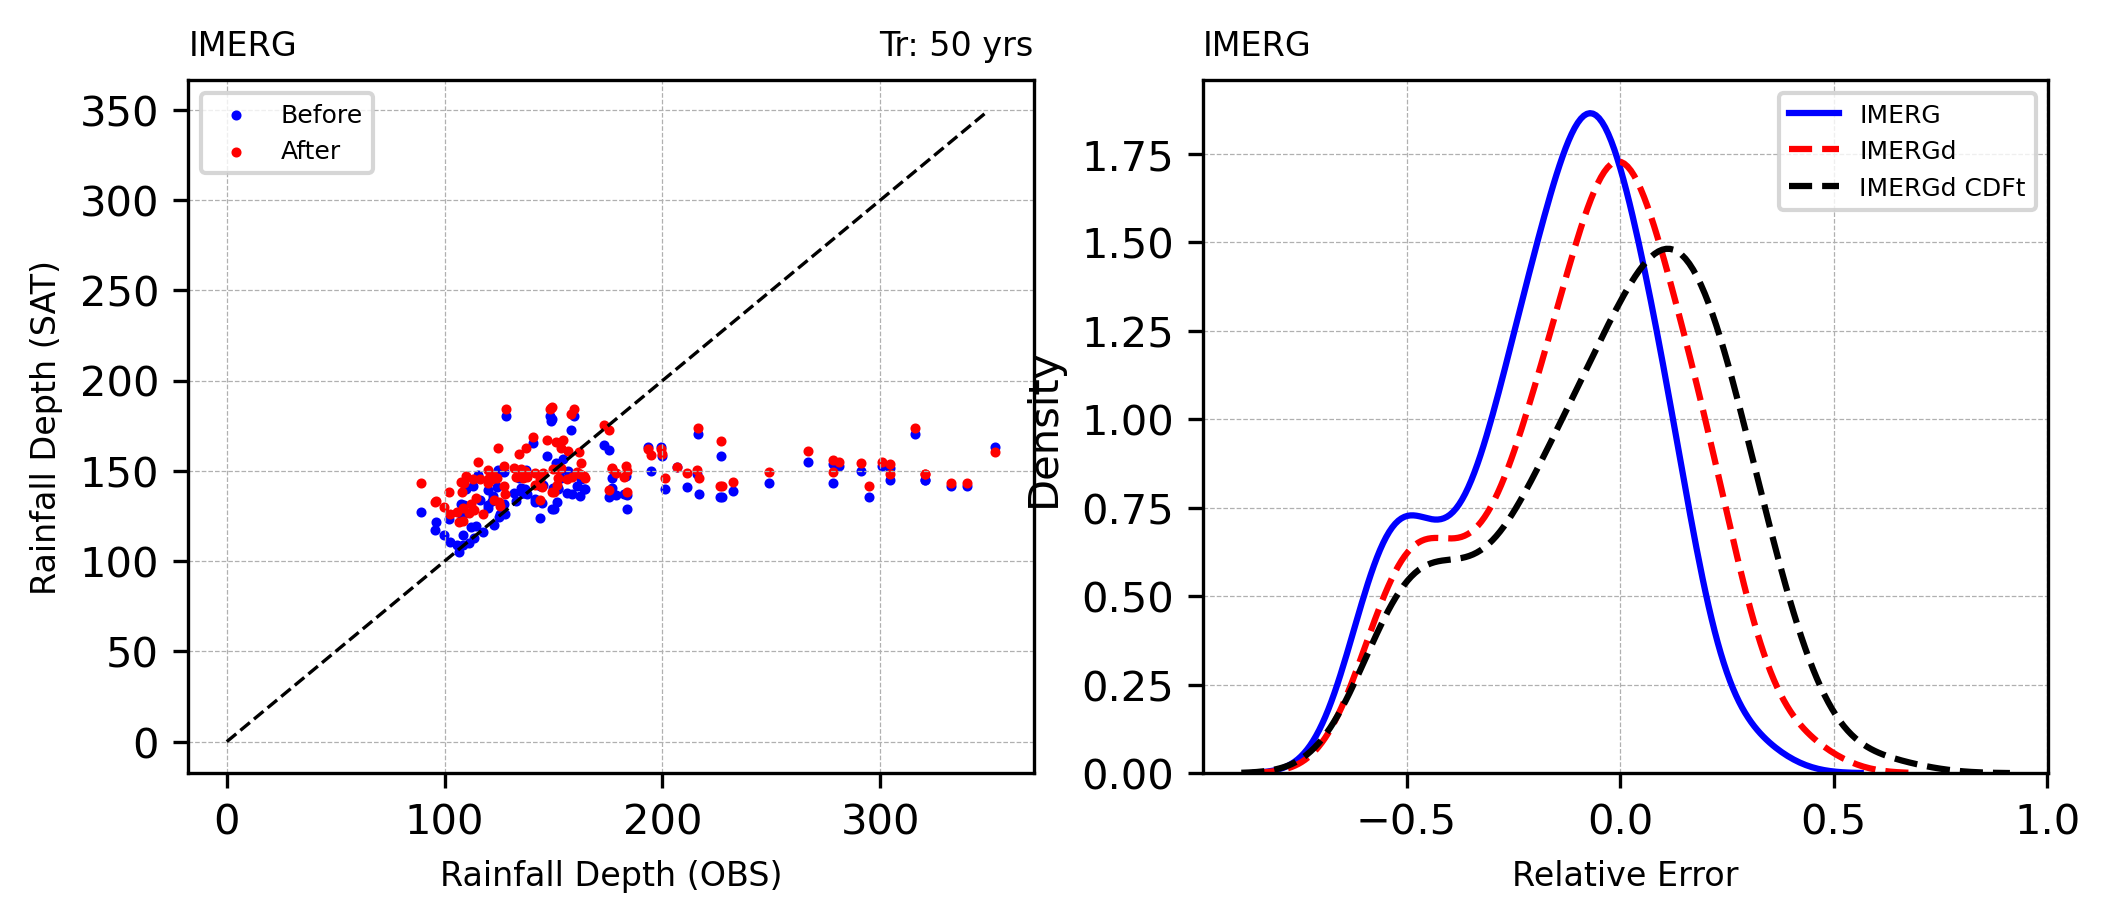

In [58]:
fig = plt.figure(figsize=(8,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(SATELLITE_pd['OBS'],SATELLITE_pd['IMERGd'],c='b',s=2,label='Before')
ax1.scatter(SATELLITE_pd['OBS'],SATELLITE_pd['IMERG_Q50d_CDFt'],c='r',s=2,label='After')
ax1.plot(np.arange(350),np.arange(350),'--k',linewidth=0.8)

plt.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('IMERG',fontsize=8,loc='left')
ax1.set_title('Tr: 50 yrs',fontsize=8,loc='right')
ax1.set_xlabel('Rainfall Depth (OBS)',fontsize=8)
ax1.set_ylabel('Rainfall Depth (SAT)',fontsize=8)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
sns.kdeplot(IMERG_QEs,color='b',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'IMERG')
sns.kdeplot(IMERG_QEd,color='r',linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'IMERGd')
sns.kdeplot(IMERG_QEd_CDFt,color='k',linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'IMERGd CDFt')

ax1.set_title('IMERG',fontsize=8,loc='left')
ax1.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlabel('Relative Error',fontsize=8)

## CMORPH

In [59]:
REG_CMORPH_N = vector_slope_intercept(OBS_N_vals, CMORPH_NYd_list)
REG_CMORPH_N_CDFt = vector_slope_intercept(OBS_N_vals, CMORPH_NYd_CDFt_list)

REG_CMORPH_C = vector_slope_intercept(OBS_C_vals, CMORPH_CYd_list)
REG_CMORPH_C_CDFt = vector_slope_intercept(OBS_N_vals, CMORPH_CYd_CDFt_list)

REG_CMORPH_W = vector_slope_intercept(OBS_W_vals, CMORPH_WYd_list)
REG_CMORPH_W_CDFt = vector_slope_intercept(OBS_N_vals, CMORPH_WYd_CDFt_list)

CMORPH_QEd_CDFt = (SATELLITE_pd['CMORPH_Q50d_CDFt']-SATELLITE_pd['OBS'])/SATELLITE_pd['OBS']

Text(0.5, 0, 'OBS')

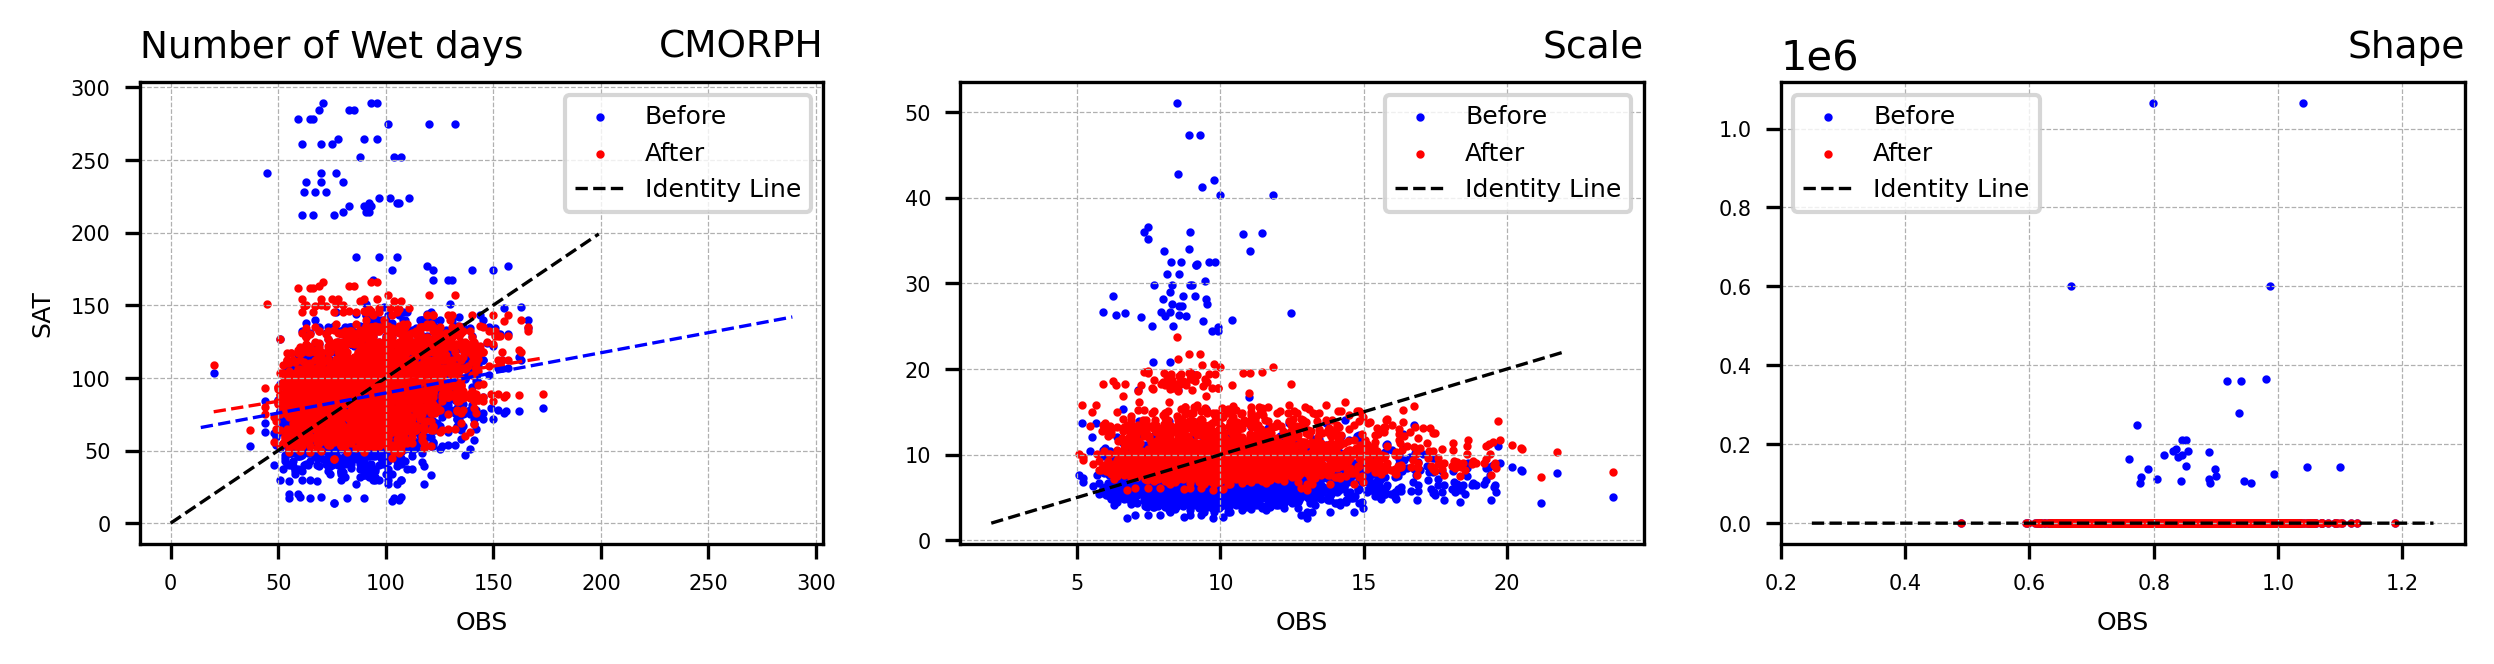

In [60]:
fig = plt.figure(figsize=(10,2),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(OBS_N_vals, CMORPH_NYd_list,c='b',s=1,label='Before')
ax1.scatter(OBS_N_vals, CMORPH_NYd_CDFt_list,c='r',s=1,label='After')

ax1.plot(REG_CMORPH_N[0],REG_CMORPH_N[1],color='b',linewidth=0.8,linestyle='--',zorder=10)
ax1.plot(REG_CMORPH_N_CDFt[0],REG_CMORPH_N_CDFt[1],color='r',linewidth=0.8,linestyle='--',zorder=10)

ax1.plot(np.arange(200),np.arange(200),'--k',linewidth=0.8,label='Identity Line')

plt.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('Number of Wet days',fontsize=9,loc='left')
ax1.set_title('CMORPH',fontsize=9,loc='right')
ax1.set_ylabel('SAT',fontsize=6)
ax1.set_xlabel('OBS',fontsize=6)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.scatter(OBS_C_vals, CMORPH_CYd_list,c='b',s=1,label='Before')
ax1.scatter(OBS_C_vals, CMORPH_CYd_CDFt_list,c='r',s=1,label='After')

ax1.plot(np.arange(2,23),np.arange(2,23),'--k',linewidth=0.8,label='Identity Line')

plt.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('Scale',fontsize=9,loc='right')
ax1.set_xlabel('OBS',fontsize=6)

# ==============================================================================
ax1 = plt.subplot(gs[0, 2])
ax1.scatter(OBS_W_vals, CMORPH_WYd_list,c='b',s=1,label='Before')
ax1.scatter(OBS_W_vals, CMORPH_WYd_CDFt_list,c='r',s=1,label='After')

ax1.plot(np.arange(0.25,1.7),np.arange(0.25,1.7),'--k',linewidth=0.8,label='Identity Line')

plt.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('Shape',fontsize=9,loc='right')
ax1.set_xlabel('OBS',fontsize=6)

Text(0.5, 0, 'Relative Error')

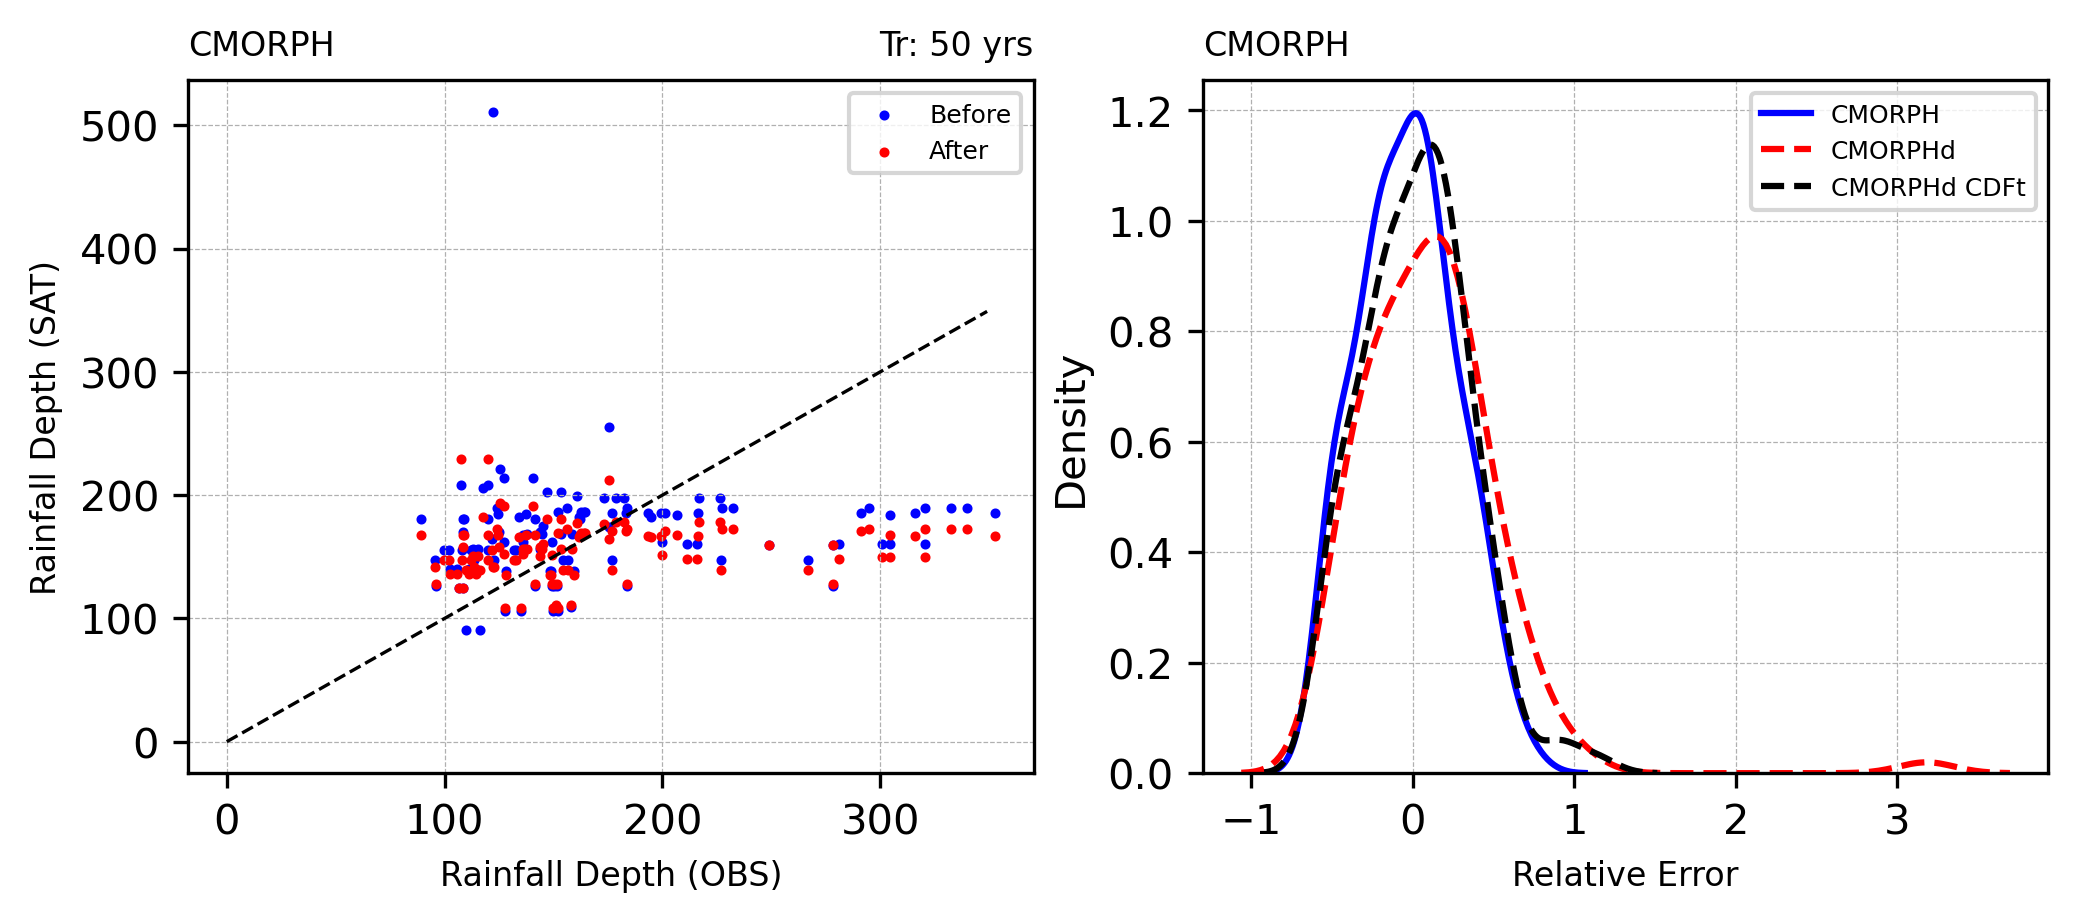

In [61]:
fig = plt.figure(figsize=(8,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(SATELLITE_pd['OBS'],SATELLITE_pd['CMORPHd'],c='b',s=2,label='Before')
ax1.scatter(SATELLITE_pd['OBS'],SATELLITE_pd['CMORPH_Q50d_CDFt'],c='r',s=2,label='After')
ax1.plot(np.arange(350),np.arange(350),'--k',linewidth=0.8)

plt.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('CMORPH',fontsize=8,loc='left')
ax1.set_title('Tr: 50 yrs',fontsize=8,loc='right')
ax1.set_xlabel('Rainfall Depth (OBS)',fontsize=8)
ax1.set_ylabel('Rainfall Depth (SAT)',fontsize=8)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
sns.kdeplot(CMORPH_QEs,color='b',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CMORPH')
sns.kdeplot(CMORPH_QEd,color='r',linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CMORPHd')
sns.kdeplot(CMORPH_QEd_CDFt,color='k',linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CMORPHd CDFt')

ax1.set_title('CMORPH',fontsize=8,loc='left')
ax1.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlabel('Relative Error',fontsize=8)

## MSWEP

In [62]:
REG_MSWEP_N = vector_slope_intercept(OBS_N_vals, MSWEP_NYd_list)
REG_MSWEP_N_CDFt = vector_slope_intercept(OBS_N_vals, MSWEP_NYd_CDFt_list)

REG_MSWEP_C = vector_slope_intercept(OBS_C_vals, MSWEP_CYd_list)
REG_MSWEP_C_CDFt = vector_slope_intercept(OBS_N_vals, MSWEP_CYd_CDFt_list)

REG_MSWEP_W = vector_slope_intercept(OBS_W_vals, MSWEP_WYd_list)
REG_MSWEP_W_CDFt = vector_slope_intercept(OBS_N_vals, MSWEP_WYd_CDFt_list)

MSWEP_QEd_CDFt = (SATELLITE_pd['MSWEP_Q50d_CDFt']-SATELLITE_pd['OBS'])/SATELLITE_pd['OBS']

Text(0.5, 0, 'OBS')

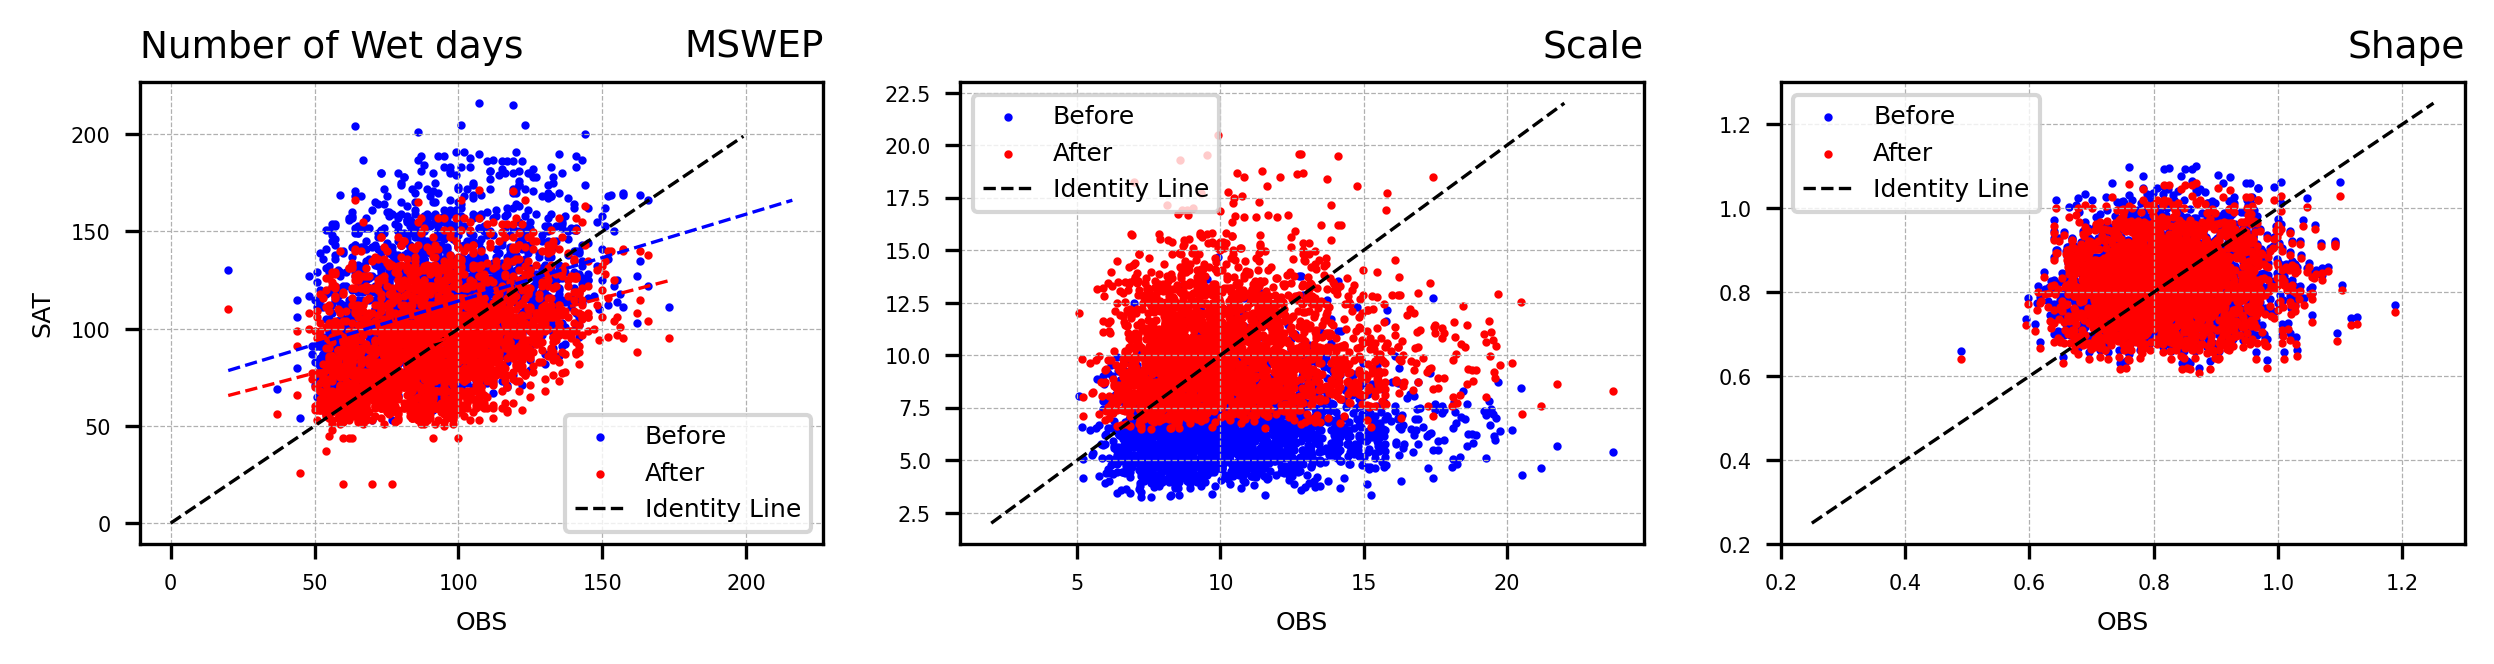

In [63]:
fig = plt.figure(figsize=(10,2),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(OBS_N_vals, MSWEP_NYd_list,c='b',s=1,label='Before')
ax1.scatter(OBS_N_vals, MSWEP_NYd_CDFt_list,c='r',s=1,label='After')

ax1.plot(REG_MSWEP_N[0],REG_MSWEP_N[1],color='b',linewidth=0.8,linestyle='--',zorder=10)
ax1.plot(REG_MSWEP_N_CDFt[0],REG_MSWEP_N_CDFt[1],color='r',linewidth=0.8,linestyle='--',zorder=10)

ax1.plot(np.arange(200),np.arange(200),'--k',linewidth=0.8,label='Identity Line')

plt.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('Number of Wet days',fontsize=9,loc='left')
ax1.set_title('MSWEP',fontsize=9,loc='right')
ax1.set_ylabel('SAT',fontsize=6)
ax1.set_xlabel('OBS',fontsize=6)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.scatter(OBS_C_vals, MSWEP_CYd_list,c='b',s=1,label='Before')
ax1.scatter(OBS_C_vals, MSWEP_CYd_CDFt_list,c='r',s=1,label='After')

ax1.plot(np.arange(2,23),np.arange(2,23),'--k',linewidth=0.8,label='Identity Line')

plt.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('Scale',fontsize=9,loc='right')
ax1.set_xlabel('OBS',fontsize=6)

# ==============================================================================
ax1 = plt.subplot(gs[0, 2])
ax1.scatter(OBS_W_vals, MSWEP_WYd_list,c='b',s=1,label='Before')
ax1.scatter(OBS_W_vals, MSWEP_WYd_CDFt_list,c='r',s=1,label='After')

ax1.plot(np.arange(0.25,1.7),np.arange(0.25,1.7),'--k',linewidth=0.8,label='Identity Line')

plt.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('Shape',fontsize=9,loc='right')
ax1.set_xlabel('OBS',fontsize=6)

Text(0.5, 0, 'Relative Error')

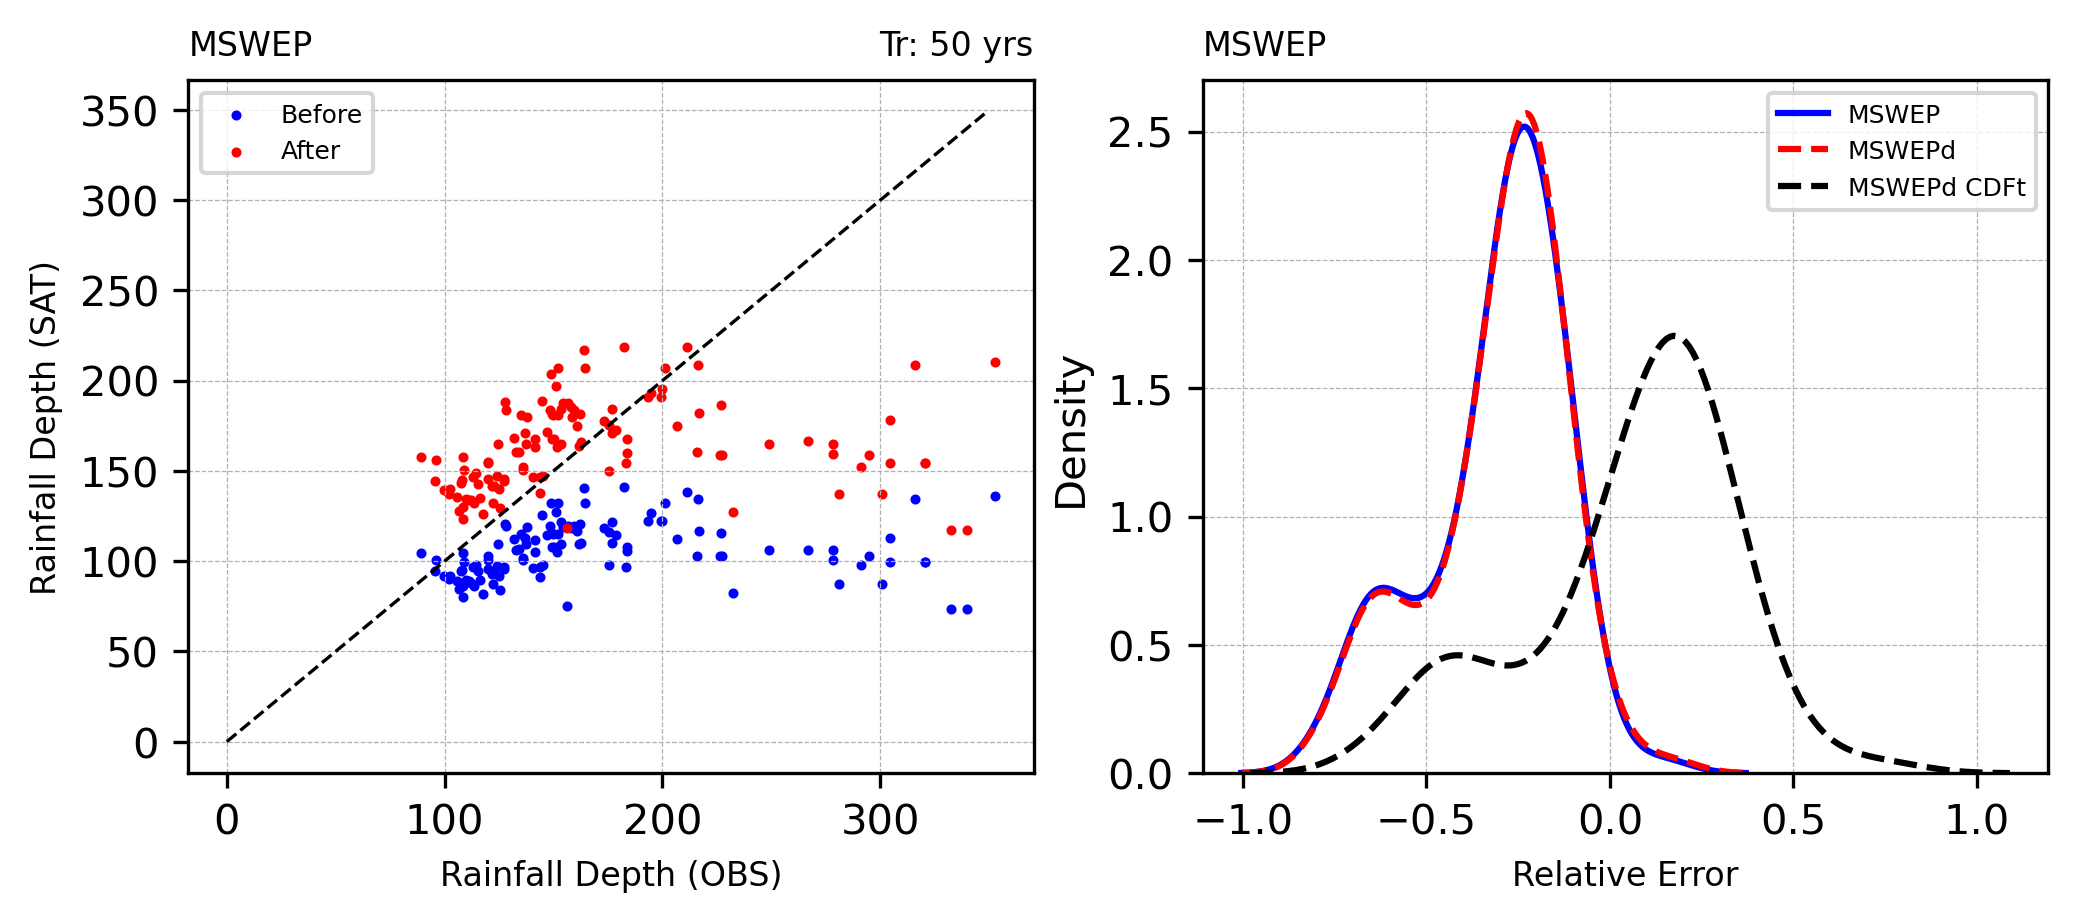

In [64]:
fig = plt.figure(figsize=(8,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(SATELLITE_pd['OBS'],SATELLITE_pd['MSWEPd'],c='b',s=2,label='Before')
ax1.scatter(SATELLITE_pd['OBS'],SATELLITE_pd['MSWEP_Q50d_CDFt'],c='r',s=2,label='After')
ax1.plot(np.arange(350),np.arange(350),'--k',linewidth=0.8)

plt.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('MSWEP',fontsize=8,loc='left')
ax1.set_title('Tr: 50 yrs',fontsize=8,loc='right')
ax1.set_xlabel('Rainfall Depth (OBS)',fontsize=8)
ax1.set_ylabel('Rainfall Depth (SAT)',fontsize=8)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
sns.kdeplot(MSWEP_QEs,color='b',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'MSWEP')
sns.kdeplot(MSWEP_QEd,color='r',linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'MSWEPd')
sns.kdeplot(MSWEP_QEd_CDFt,color='k',linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'MSWEPd CDFt')

ax1.set_title('MSWEP',fontsize=8,loc='left')
ax1.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlabel('Relative Error',fontsize=8)

## GSMaP

In [65]:
REG_GSMaP_N = vector_slope_intercept(OBS_N_vals, GSMaP_NYd_list)
REG_GSMaP_N_CDFt = vector_slope_intercept(OBS_N_vals, GSMaP_NYd_CDFt_list)

REG_GSMaP_C = vector_slope_intercept(OBS_C_vals, GSMaP_CYd_list)
REG_GSMaP_C_CDFt = vector_slope_intercept(OBS_N_vals, GSMaP_CYd_CDFt_list)

REG_GSMaP_W = vector_slope_intercept(OBS_W_vals, GSMaP_WYd_list)
REG_GSMaP_W_CDFt = vector_slope_intercept(OBS_N_vals, GSMaP_WYd_CDFt_list)

GSMaP_QEd_CDFt = (SATELLITE_pd['GSMaP_Q50d_CDFt']-SATELLITE_pd['OBS'])/SATELLITE_pd['OBS']

Text(0.5, 0, 'OBS')

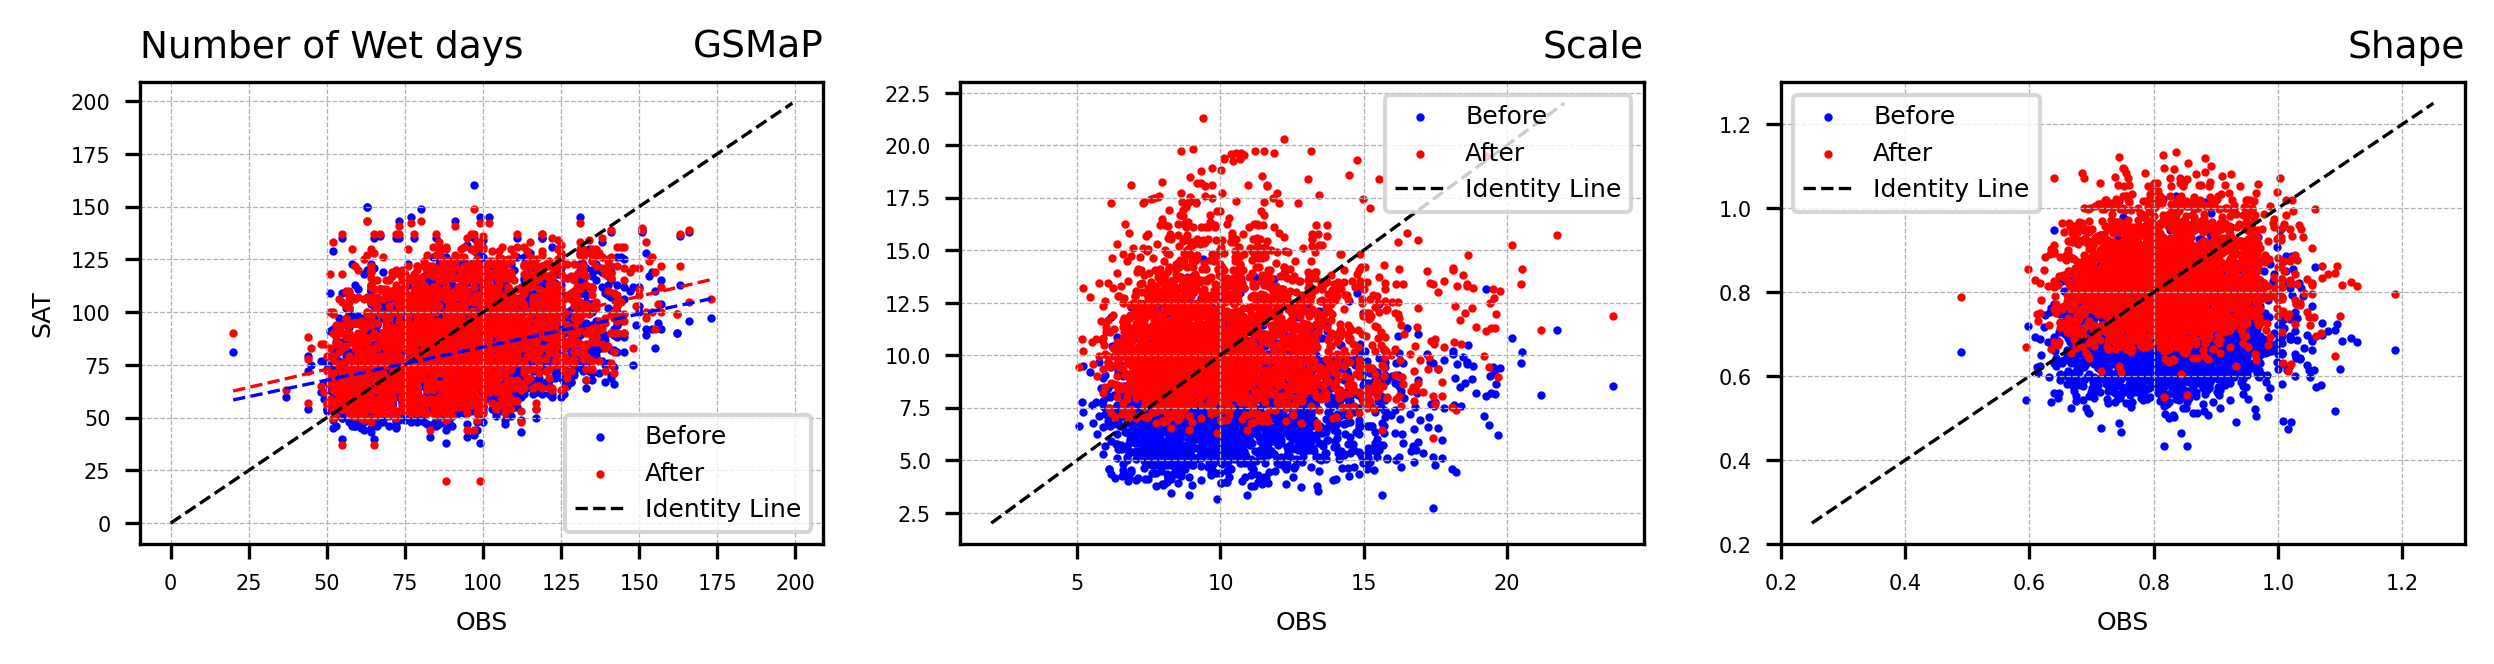

In [66]:
fig = plt.figure(figsize=(10,2),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(OBS_N_vals, GSMaP_NYd_list,c='b',s=1,label='Before')
ax1.scatter(OBS_N_vals, GSMaP_NYd_CDFt_list,c='r',s=1,label='After')

ax1.plot(REG_GSMaP_N[0],REG_GSMaP_N[1],color='b',linewidth=0.8,linestyle='--',zorder=10)
ax1.plot(REG_GSMaP_N_CDFt[0],REG_GSMaP_N_CDFt[1],color='r',linewidth=0.8,linestyle='--',zorder=10)

ax1.plot(np.arange(200),np.arange(200),'--k',linewidth=0.8,label='Identity Line')

plt.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('Number of Wet days',fontsize=9,loc='left')
ax1.set_title('GSMaP',fontsize=9,loc='right')
ax1.set_ylabel('SAT',fontsize=6)
ax1.set_xlabel('OBS',fontsize=6)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.scatter(OBS_C_vals, GSMaP_CYd_list,c='b',s=1,label='Before')
ax1.scatter(OBS_C_vals, GSMaP_CYd_CDFt_list,c='r',s=1,label='After')

ax1.plot(np.arange(2,23),np.arange(2,23),'--k',linewidth=0.8,label='Identity Line')

plt.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('Scale',fontsize=9,loc='right')
ax1.set_xlabel('OBS',fontsize=6)

# ==============================================================================
ax1 = plt.subplot(gs[0, 2])
ax1.scatter(OBS_W_vals, GSMaP_WYd_list,c='b',s=1,label='Before')
ax1.scatter(OBS_W_vals, GSMaP_WYd_CDFt_list,c='r',s=1,label='After')

ax1.plot(np.arange(0.25,1.7),np.arange(0.25,1.7),'--k',linewidth=0.8,label='Identity Line')

plt.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('Shape',fontsize=9,loc='right')
ax1.set_xlabel('OBS',fontsize=6)

Text(0.5, 0, 'Relative Error')

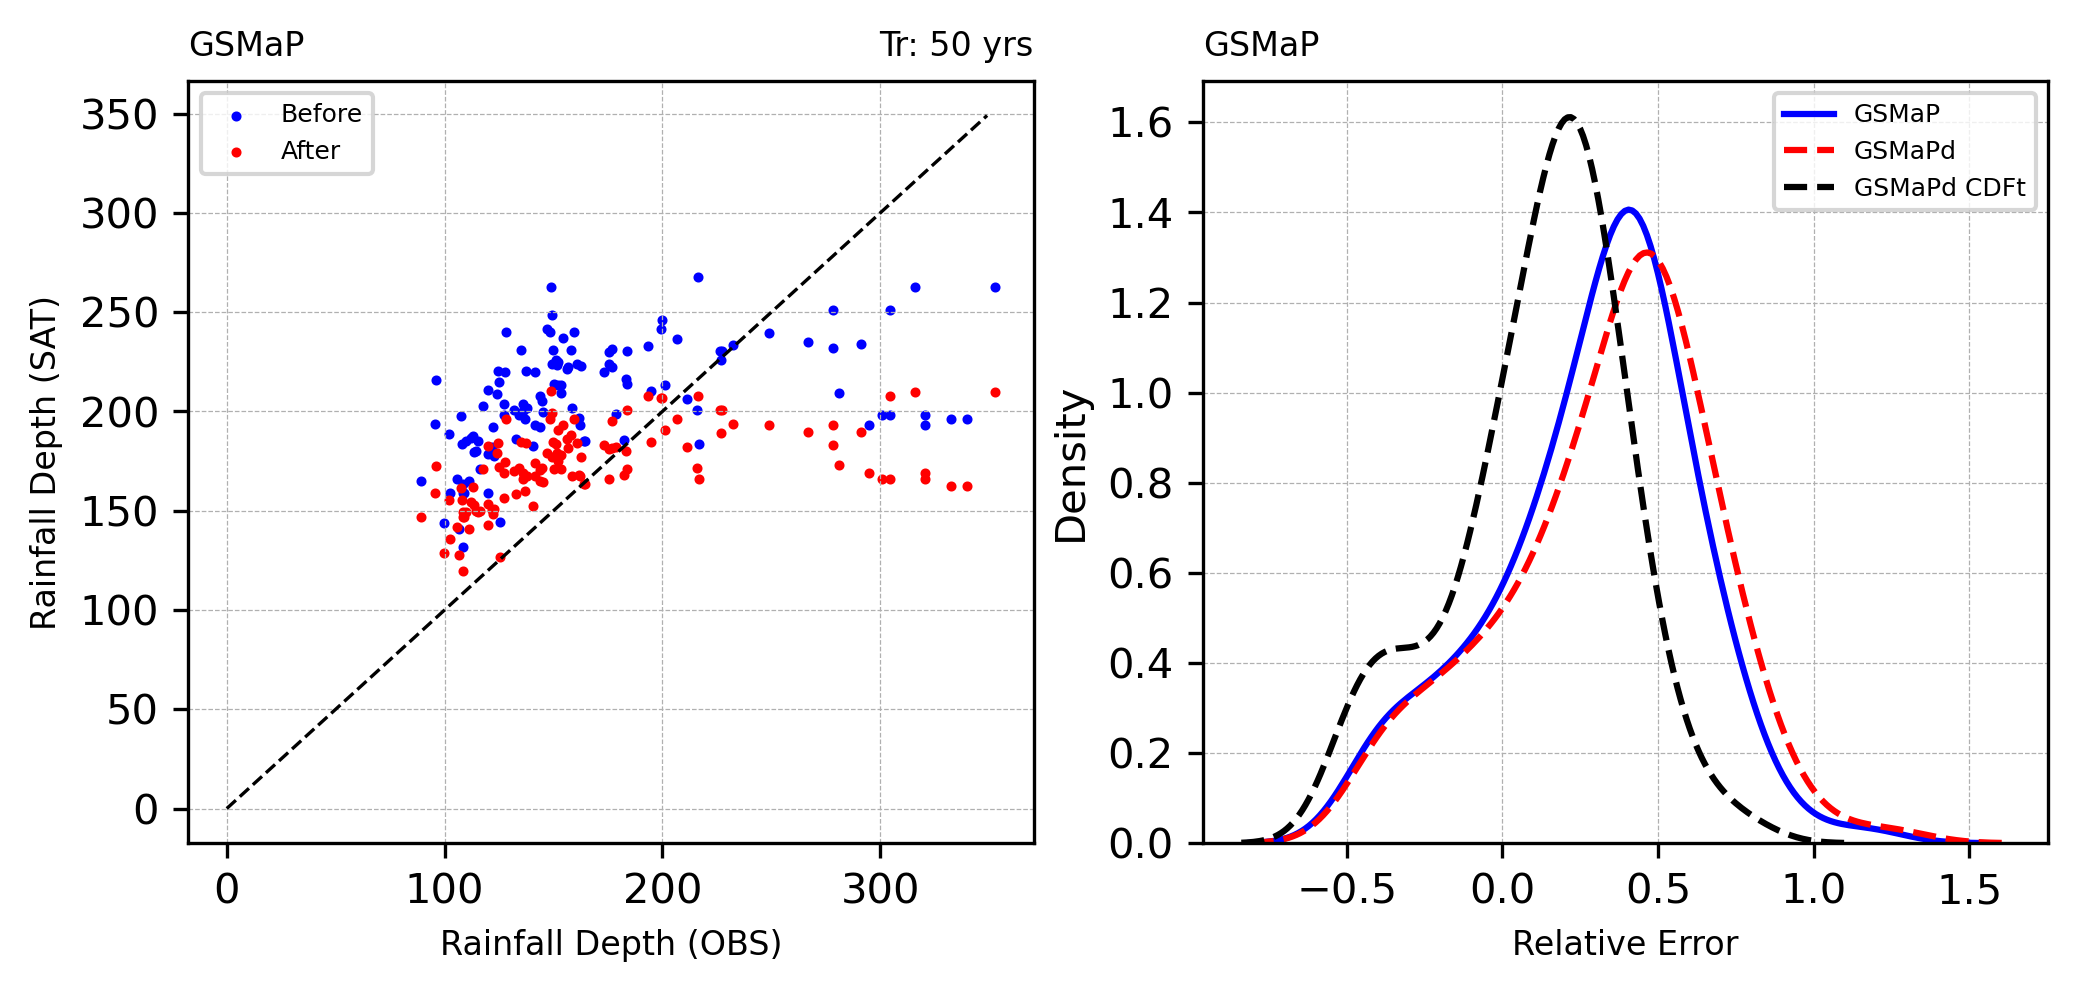

In [67]:
fig = plt.figure(figsize=(8,3.3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(SATELLITE_pd['OBS'],SATELLITE_pd['GSMaPd'],c='b',s=2,label='Before')
ax1.scatter(SATELLITE_pd['OBS'],SATELLITE_pd['GSMaP_Q50d_CDFt'],c='r',s=2,label='After')
ax1.plot(np.arange(350),np.arange(350),'--k',linewidth=0.8)

plt.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('GSMaP',fontsize=8,loc='left')
ax1.set_title('Tr: 50 yrs',fontsize=8,loc='right')
ax1.set_xlabel('Rainfall Depth (OBS)',fontsize=8)
ax1.set_ylabel('Rainfall Depth (SAT)',fontsize=8)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
sns.kdeplot(GSMaP_QEs,color='b',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'GSMaP')
sns.kdeplot(GSMaP_QEd,color='r',linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'GSMaPd')
sns.kdeplot(GSMaP_QEd_CDFt,color='k',linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'GSMaPd CDFt')

ax1.set_title('GSMaP',fontsize=8,loc='left')
ax1.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlabel('Relative Error',fontsize=8)

## PERSIAN

In [68]:
REG_PERSIANN_N = vector_slope_intercept(OBS_N_vals, PERSIANN_NYd_list)
REG_PERSIANN_N_CDFt = vector_slope_intercept(OBS_N_vals, PERSIANN_NYd_CDFt_list)

REG_PERSIANN_C = vector_slope_intercept(OBS_C_vals, PERSIANN_CYd_list)
REG_PERSIANN_C_CDFt = vector_slope_intercept(OBS_N_vals, PERSIANN_CYd_CDFt_list)

REG_PERSIANN_W = vector_slope_intercept(OBS_W_vals, PERSIANN_WYd_list)
REG_PERSIANN_W_CDFt = vector_slope_intercept(OBS_N_vals, PERSIANN_WYd_CDFt_list)

PERSIANN_QEd_CDFt = (SATELLITE_pd['PERSIANN_Q50d_CDFt']-SATELLITE_pd['OBS'])/SATELLITE_pd['OBS']

Text(0.5, 0, 'OBS')

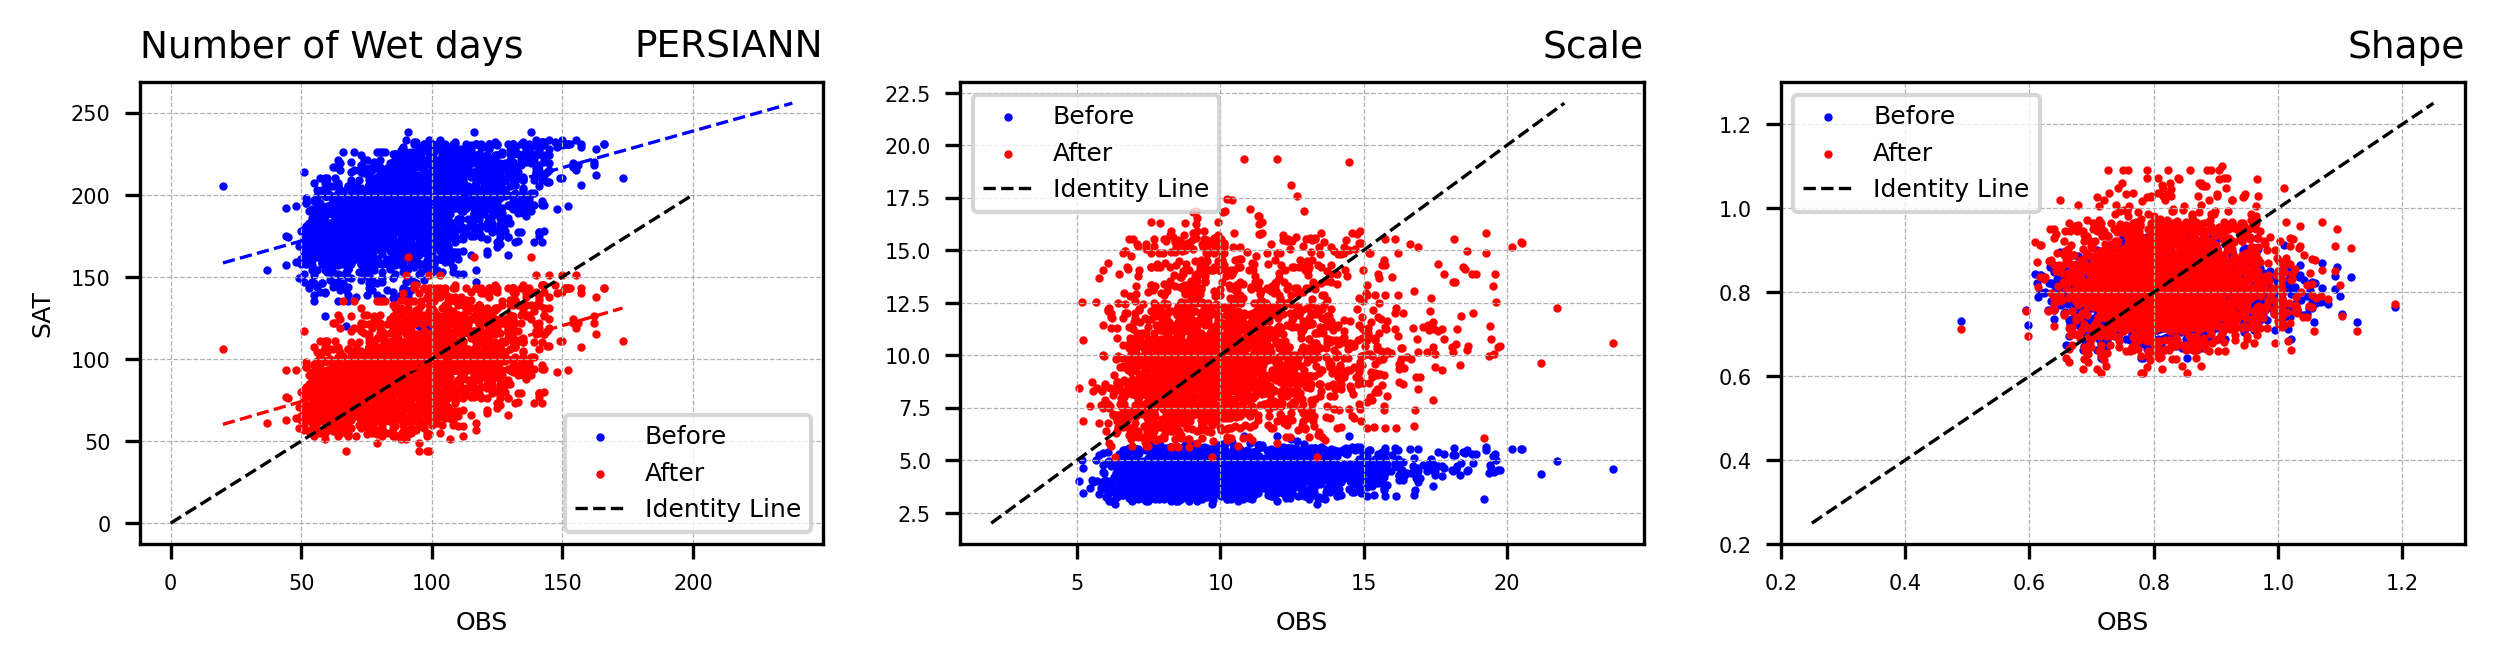

In [69]:
fig = plt.figure(figsize=(10,2),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(OBS_N_vals, PERSIANN_NYd_list,c='b',s=1,label='Before')
ax1.scatter(OBS_N_vals, PERSIANN_NYd_CDFt_list,c='r',s=1,label='After')

ax1.plot(REG_PERSIANN_N[0],REG_PERSIANN_N[1],color='b',linewidth=0.8,linestyle='--',zorder=10)
ax1.plot(REG_PERSIANN_N_CDFt[0],REG_PERSIANN_N_CDFt[1],color='r',linewidth=0.8,linestyle='--',zorder=10)

ax1.plot(np.arange(200),np.arange(200),'--k',linewidth=0.8,label='Identity Line')

plt.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('Number of Wet days',fontsize=9,loc='left')
ax1.set_title('PERSIANN',fontsize=9,loc='right')
ax1.set_ylabel('SAT',fontsize=6)
ax1.set_xlabel('OBS',fontsize=6)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.scatter(OBS_C_vals, PERSIANN_CYd_list,c='b',s=1,label='Before')
ax1.scatter(OBS_C_vals, PERSIANN_CYd_CDFt_list,c='r',s=1,label='After')

ax1.plot(np.arange(2,23),np.arange(2,23),'--k',linewidth=0.8,label='Identity Line')

plt.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('Scale',fontsize=9,loc='right')
ax1.set_xlabel('OBS',fontsize=6)

# ==============================================================================
ax1 = plt.subplot(gs[0, 2])
ax1.scatter(OBS_W_vals, PERSIANN_WYd_list,c='b',s=1,label='Before')
ax1.scatter(OBS_W_vals, PERSIANN_WYd_CDFt_list,c='r',s=1,label='After')

ax1.plot(np.arange(0.25,1.7),np.arange(0.25,1.7),'--k',linewidth=0.8,label='Identity Line')

plt.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('Shape',fontsize=9,loc='right')
ax1.set_xlabel('OBS',fontsize=6)

Text(0.5, 0, 'Relative Error')

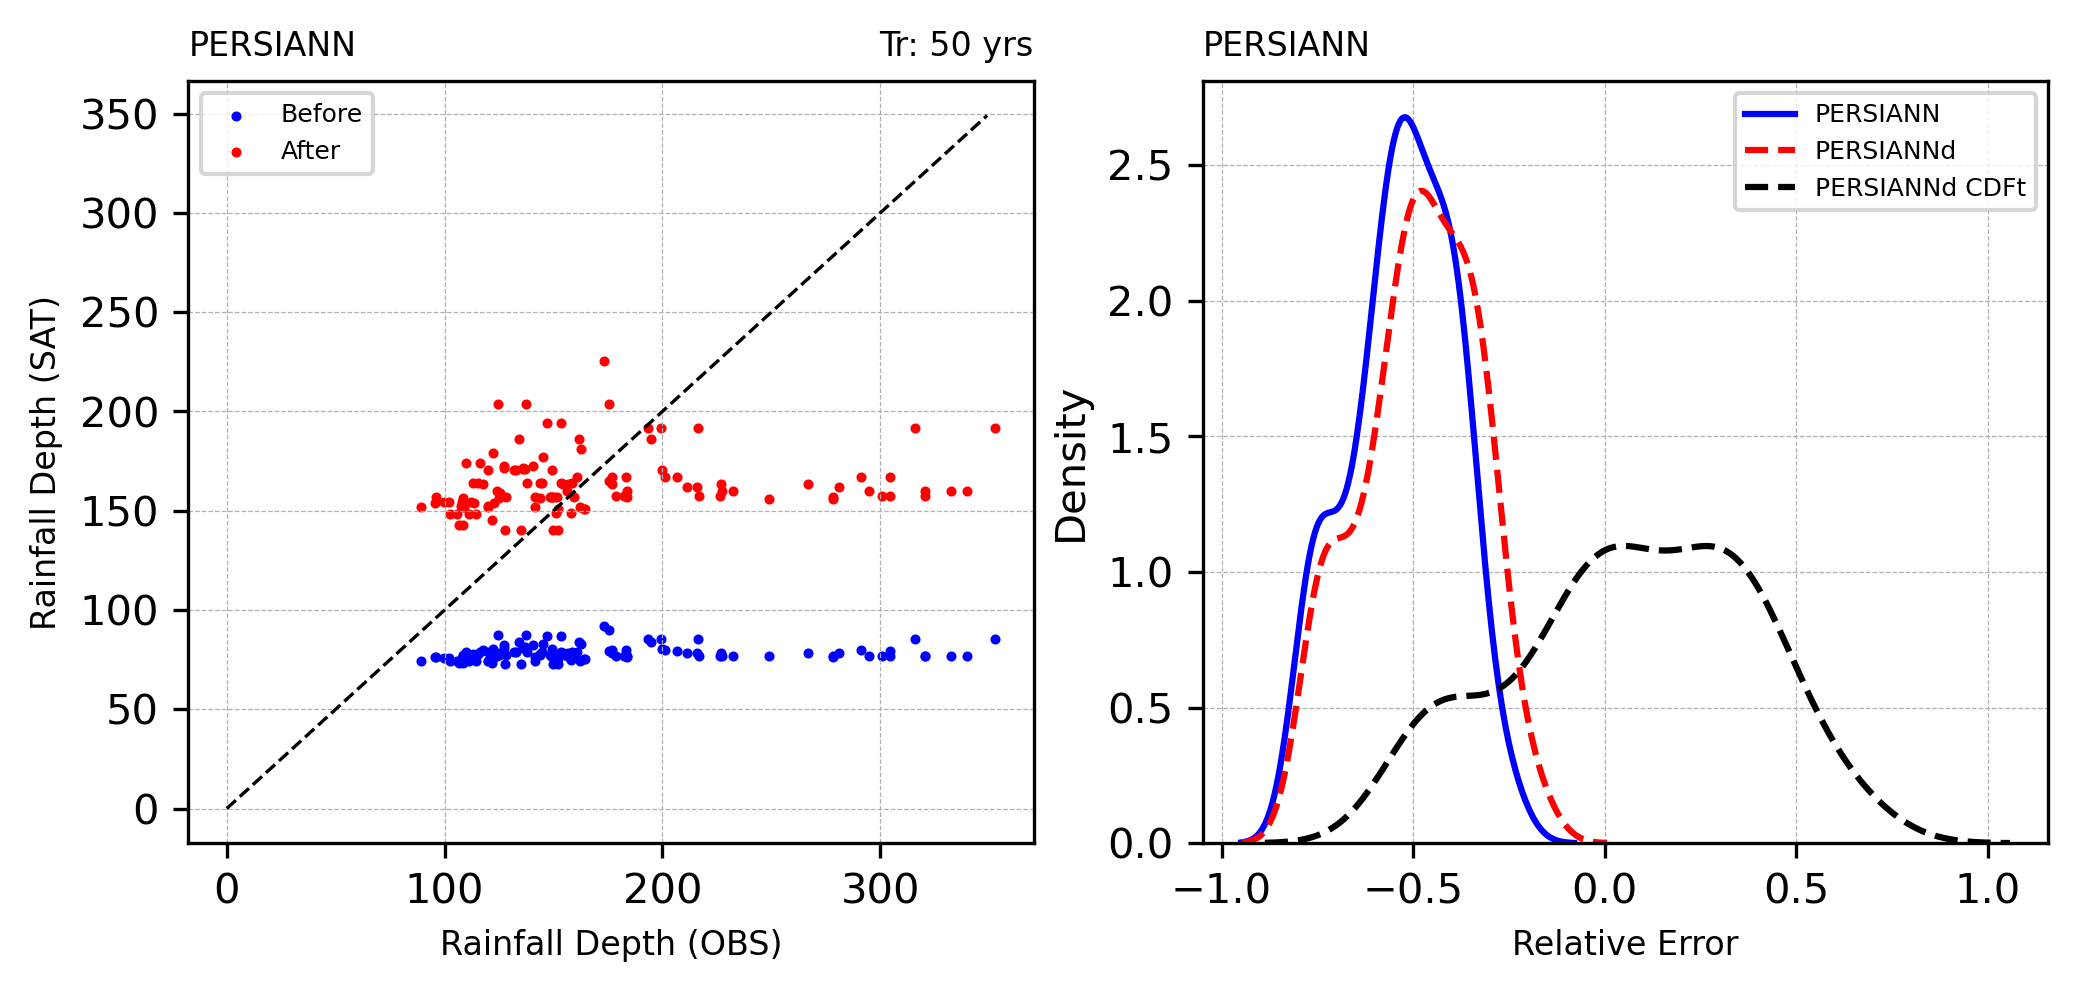

In [70]:
fig = plt.figure(figsize=(8,3.3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(SATELLITE_pd['OBS'],SATELLITE_pd['PERSIANNd'],c='b',s=2,label='Before')
ax1.scatter(SATELLITE_pd['OBS'],SATELLITE_pd['PERSIANN_Q50d_CDFt'],c='r',s=2,label='After')
ax1.plot(np.arange(350),np.arange(350),'--k',linewidth=0.8)

plt.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('PERSIANN',fontsize=8,loc='left')
ax1.set_title('Tr: 50 yrs',fontsize=8,loc='right')
ax1.set_xlabel('Rainfall Depth (OBS)',fontsize=8)
ax1.set_ylabel('Rainfall Depth (SAT)',fontsize=8)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
sns.kdeplot(PERSIANN_QEs,color='b',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'PERSIANN')
sns.kdeplot(PERSIANN_QEd,color='r',linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'PERSIANNd')
sns.kdeplot(PERSIANN_QEd_CDFt,color='k',linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'PERSIANNd CDFt')

ax1.set_title('PERSIANN',fontsize=8,loc='left')
ax1.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlabel('Relative Error',fontsize=8)

## CHIRPS

In [71]:
REG_CHIRPS_N = vector_slope_intercept(OBS_N_vals, CHIRPS_NYd_list)
REG_CHIRPS_N_CDFt = vector_slope_intercept(OBS_N_vals, CHIRPS_NYd_CDFt_list)

REG_CHIRPS_C = vector_slope_intercept(OBS_C_vals, CHIRPS_CYd_list)
REG_CHIRPS_C_CDFt = vector_slope_intercept(OBS_N_vals, CHIRPS_CYd_CDFt_list)

REG_CHIRPS_W = vector_slope_intercept(OBS_W_vals, CHIRPS_WYd_list)
REG_CHIRPS_W_CDFt = vector_slope_intercept(OBS_N_vals, CHIRPS_WYd_CDFt_list)

CHIRPS_QEd_CDFt = (SATELLITE_pd['CHIRPS_Q50d_CDFt']-SATELLITE_pd['OBS'])/SATELLITE_pd['OBS']

Text(0.5, 0, 'OBS')

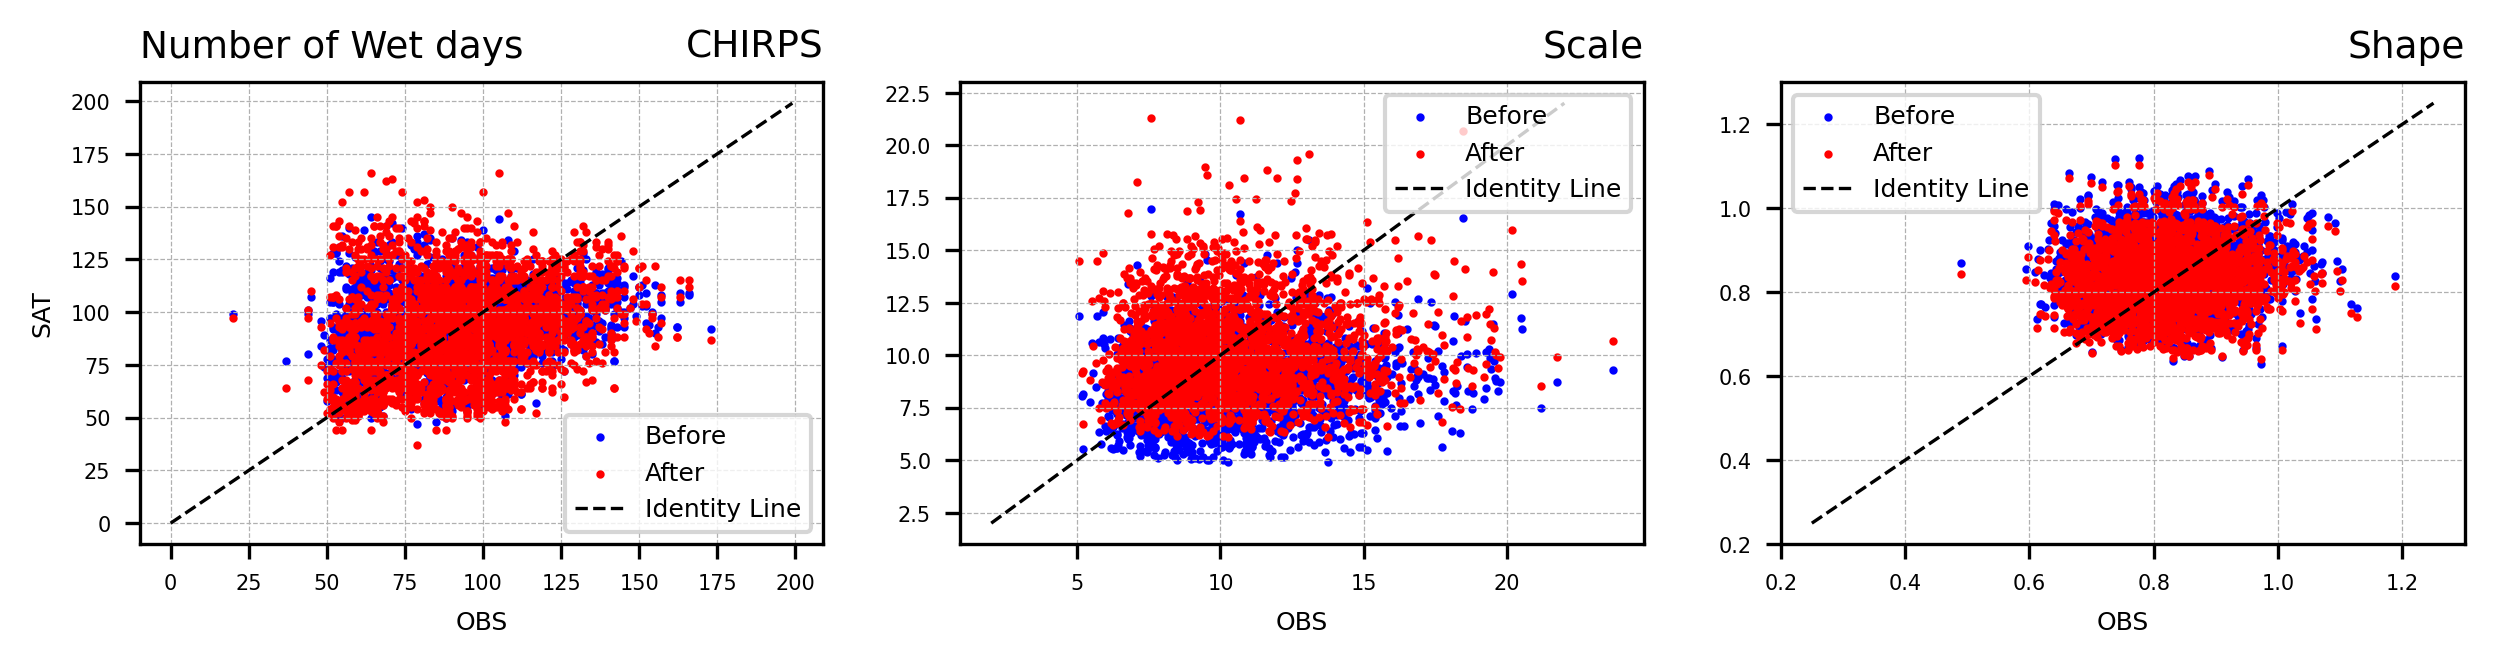

In [72]:
fig = plt.figure(figsize=(10,2),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(OBS_N_vals, CHIRPS_NYd_list,c='b',s=1,label='Before')
ax1.scatter(OBS_N_vals, CHIRPS_NYd_CDFt_list,c='r',s=1,label='After')

ax1.plot(REG_CHIRPS_N[0],REG_CHIRPS_N[1],color='b',linewidth=0.8,linestyle='--',zorder=10)
ax1.plot(REG_CHIRPS_N_CDFt[0],REG_CHIRPS_N_CDFt[1],color='r',linewidth=0.8,linestyle='--',zorder=10)

ax1.plot(np.arange(200),np.arange(200),'--k',linewidth=0.8,label='Identity Line')

plt.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('Number of Wet days',fontsize=9,loc='left')
ax1.set_title('CHIRPS',fontsize=9,loc='right')
ax1.set_ylabel('SAT',fontsize=6)
ax1.set_xlabel('OBS',fontsize=6)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.scatter(OBS_C_vals, CHIRPS_CYd_list,c='b',s=1,label='Before')
ax1.scatter(OBS_C_vals, CHIRPS_CYd_CDFt_list,c='r',s=1,label='After')

ax1.plot(np.arange(2,23),np.arange(2,23),'--k',linewidth=0.8,label='Identity Line')

plt.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('Scale',fontsize=9,loc='right')
ax1.set_xlabel('OBS',fontsize=6)

# ==============================================================================
ax1 = plt.subplot(gs[0, 2])
ax1.scatter(OBS_W_vals, CHIRPS_WYd_list,c='b',s=1,label='Before')
ax1.scatter(OBS_W_vals, CHIRPS_WYd_CDFt_list,c='r',s=1,label='After')

ax1.plot(np.arange(0.25,1.7),np.arange(0.25,1.7),'--k',linewidth=0.8,label='Identity Line')

plt.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('Shape',fontsize=9,loc='right')
ax1.set_xlabel('OBS',fontsize=6)

Text(0.5, 0, 'Relative Error')

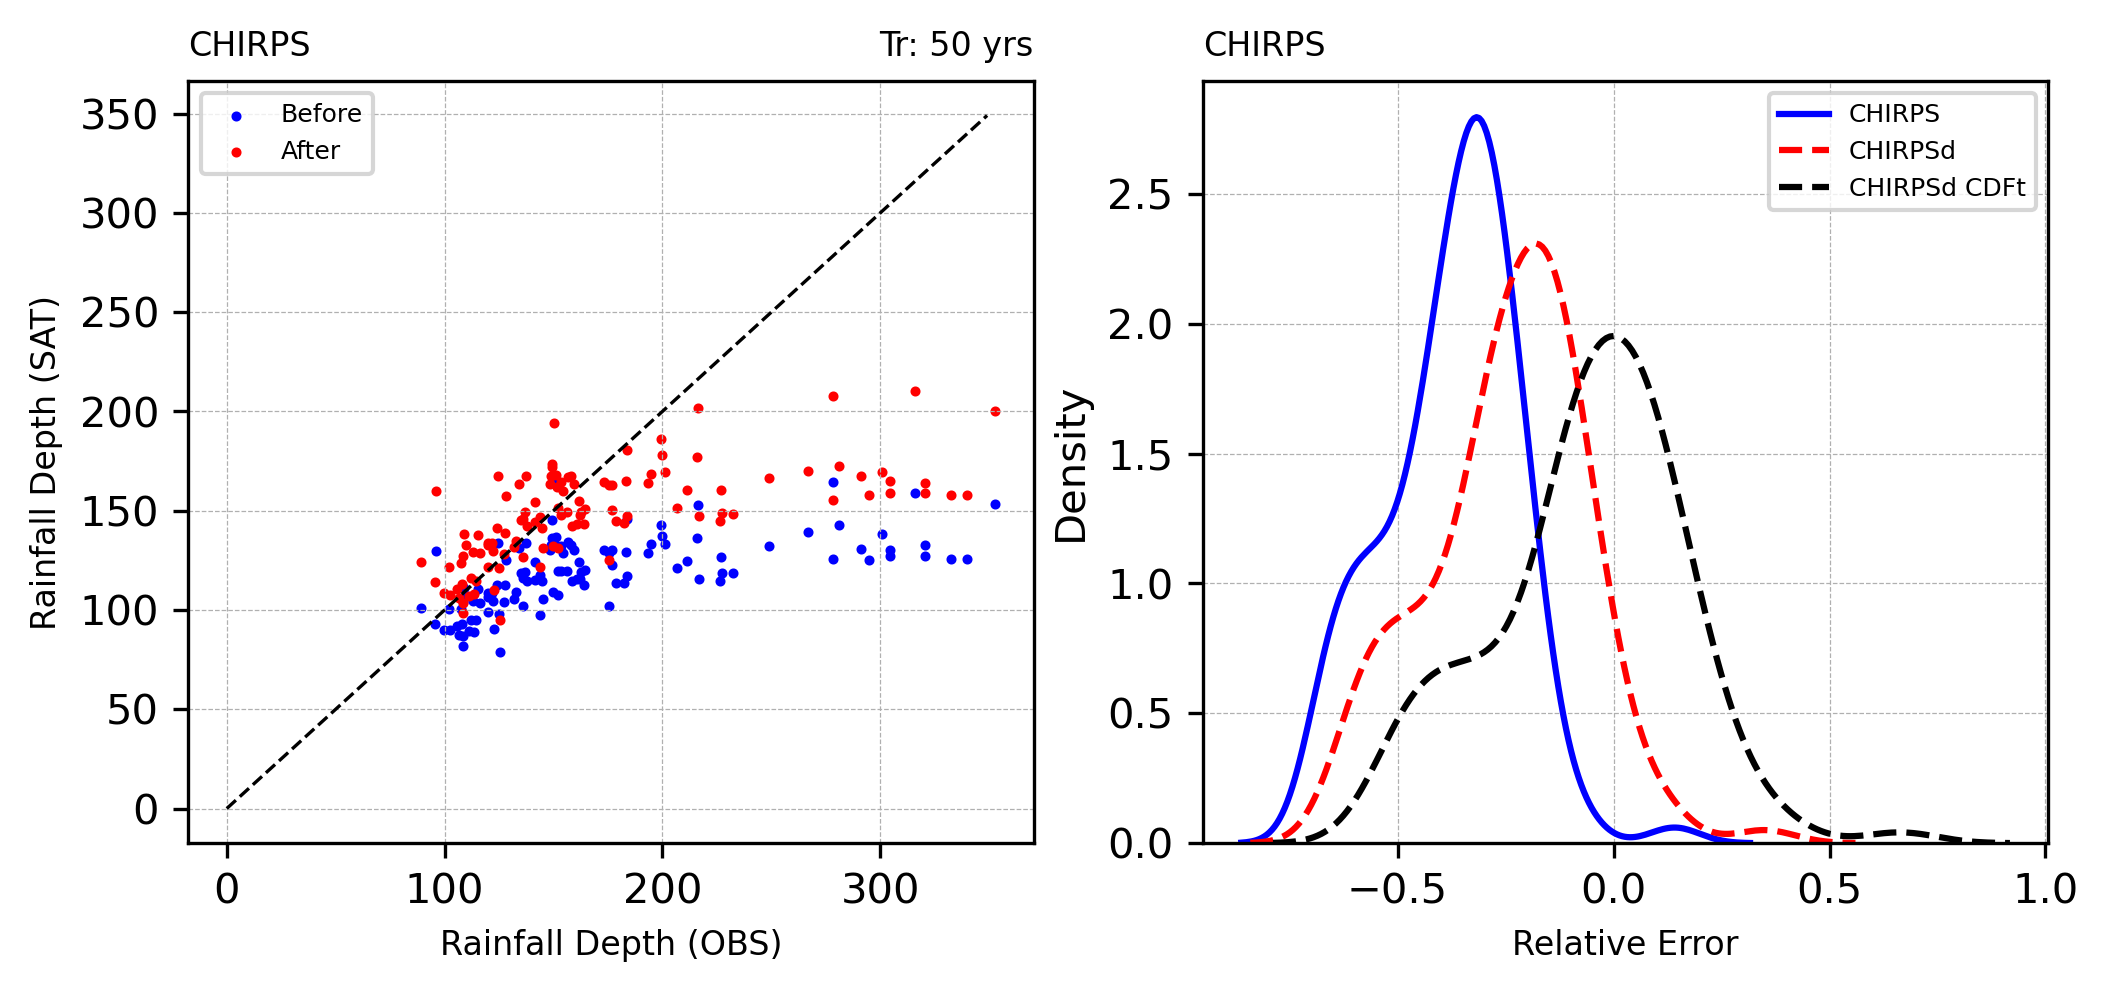

In [73]:
fig = plt.figure(figsize=(8,3.3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(SATELLITE_pd['OBS'],SATELLITE_pd['CHIRPSd'],c='b',s=2,label='Before')
ax1.scatter(SATELLITE_pd['OBS'],SATELLITE_pd['CHIRPS_Q50d_CDFt'],c='r',s=2,label='After')
ax1.plot(np.arange(350),np.arange(350),'--k',linewidth=0.8)

plt.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('CHIRPS',fontsize=8,loc='left')
ax1.set_title('Tr: 50 yrs',fontsize=8,loc='right')
ax1.set_xlabel('Rainfall Depth (OBS)',fontsize=8)
ax1.set_ylabel('Rainfall Depth (SAT)',fontsize=8)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
sns.kdeplot(CHIRPS_QEs,color='b',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CHIRPS')
sns.kdeplot(CHIRPS_QEd,color='r',linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CHIRPSd')
sns.kdeplot(CHIRPS_QEd_CDFt,color='k',linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CHIRPSd CDFt')

ax1.set_title('CHIRPS',fontsize=8,loc='left')
ax1.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlabel('Relative Error',fontsize=8)

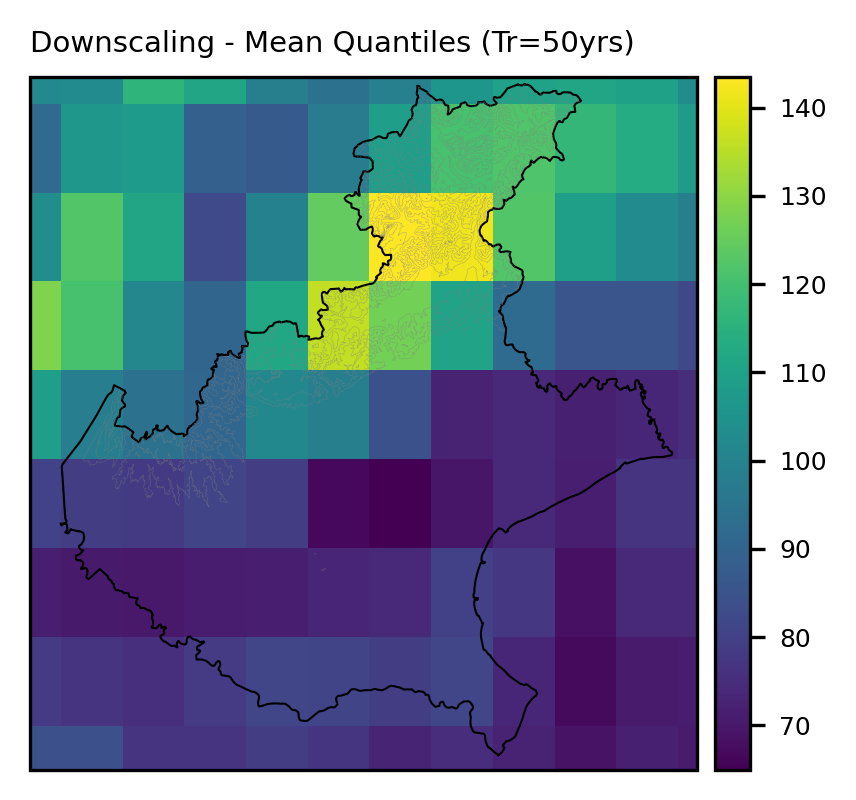

In [74]:
levels_obs = np.arange(50,510,10)
norm_obs = mcolors.BoundaryNorm(boundaries=levels_obs, ncolors=256)

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,3),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.75, 46.7],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
DEM.plot(facecolor='None',color='grey',alpha=0.6, ax=ax1, linewidth=0.1, zorder=10)

a1 = ax1.pcolormesh(lon2d_ERA5, lat2d_ERA5, np.nanmean(ERA5_NYd_CDFt,axis=0))

ax1.set_title(f'Downscaling - Mean Quantiles (Tr=50yrs)', fontsize=7, loc='left')

cbar = plt.colorbar(a1, ticks=None, fraction=0.053,pad=0.02)
cbar.ax.tick_params(labelsize=6)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

## 20 %

In [75]:
ERA5_NYd_list, ERA5_NYd_CDFt_list = [], []
ERA5_CYd_list, ERA5_CYd_CDFt_list = [], []
ERA5_WYd_list, ERA5_WYd_CDFt_list = [], []
ERA5_QYd_CDFt_list = []

IMERG_NYd_list, IMERG_NYd_CDFt_list = [], []
IMERG_CYd_list, IMERG_CYd_CDFt_list = [], []
IMERG_WYd_list, IMERG_WYd_CDFt_list = [], []
IMERG_QYd_CDFt_list = []

CMORPH_NYd_list, CMORPH_NYd_CDFt_list = [], []
CMORPH_CYd_list, CMORPH_CYd_CDFt_list = [], []
CMORPH_WYd_list, CMORPH_WYd_CDFt_list = [], []
CMORPH_QYd_CDFt_list = []

MSWEP_NYd_list, MSWEP_NYd_CDFt_list = [], []
MSWEP_CYd_list, MSWEP_CYd_CDFt_list = [], []
MSWEP_WYd_list, MSWEP_WYd_CDFt_list = [], []
MSWEP_QYd_CDFt_list = []

GSMaP_NYd_list, GSMaP_NYd_CDFt_list = [], []
GSMaP_CYd_list, GSMaP_CYd_CDFt_list = [], []
GSMaP_WYd_list, GSMaP_WYd_CDFt_list = [], []
GSMaP_QYd_CDFt_list = []

PERSIANN_NYd_list, PERSIANN_NYd_CDFt_list = [], []
PERSIANN_CYd_list, PERSIANN_CYd_CDFt_list = [], []
PERSIANN_WYd_list, PERSIANN_WYd_CDFt_list = [], []
PERSIANN_QYd_CDFt_list = []

CHIRPS_NYd_list, CHIRPS_NYd_CDFt_list = [], []
CHIRPS_CYd_list, CHIRPS_CYd_CDFt_list = [], []
CHIRPS_WYd_list, CHIRPS_WYd_CDFt_list = [], []
CHIRPS_QYd_CDFt_list = []

for nn in range(len(Q_20)):
    Q_OBS = Q_20['Q50'].values[nn]
    lat_obs = Q_20['Lat'].values[nn]
    lon_obs = Q_20['Lon'].values[nn]

    # =======================================================================
    # ERA5
    distances = ART_pre.haversine(lat2d_ERA5, lon2d_ERA5, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

    # Weibull Parameters
    ERA5_NYd_list.extend(NdERA5[:,min_index[0],min_index[1]])
    ERA5_CYd_list.extend(CdERA5[:,min_index[0],min_index[1]])
    ERA5_WYd_list.extend(WdERA5[:,min_index[0],min_index[1]])

    ERA5_NYd_CDFt_list.extend(ERA5_NYd_CDFt[:,min_index[0],min_index[1]])
    ERA5_CYd_CDFt_list.extend(ERA5_CYd_CDFt[:,min_index[0],min_index[1]])
    ERA5_WYd_CDFt_list.extend(ERA5_WYd_CDFt[:,min_index[0],min_index[1]])

    # Quantiles
    ERA5_QYd_CDFt_list.append(ERA5_QYd_CDFt[3,min_index[0],min_index[1]])

    # =======================================================================
    # IMERG
    distances = ART_pre.haversine(lat2d_IMERG, lon2d_IMERG, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

    # Weibull Parameters
    IMERG_NYd_list.extend(NdIMERG[:,min_index[0],min_index[1]])
    IMERG_CYd_list.extend(CdIMERG[:,min_index[0],min_index[1]])
    IMERG_WYd_list.extend(WdIMERG[:,min_index[0],min_index[1]])

    IMERG_NYd_CDFt_list.extend(IMERG_NYd_CDFt[:,min_index[0],min_index[1]])
    IMERG_CYd_CDFt_list.extend(IMERG_CYd_CDFt[:,min_index[0],min_index[1]])
    IMERG_WYd_CDFt_list.extend(IMERG_WYd_CDFt[:,min_index[0],min_index[1]])

    # Quantiles
    IMERG_QYd_CDFt_list.append(IMERG_QYd_CDFt[3,min_index[0],min_index[1]])

    # =======================================================================
    # CMORPH
    distances = ART_pre.haversine(lat2d_CMORPH, lon2d_CMORPH, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

    # Weibull Parameters
    CMORPH_NYd_list.extend(NdCMORPH[:,min_index[0],min_index[1]])
    CMORPH_CYd_list.extend(CdCMORPH[:,min_index[0],min_index[1]])
    CMORPH_WYd_list.extend(WdCMORPH[:,min_index[0],min_index[1]])

    CMORPH_NYd_CDFt_list.extend(CMORPH_NYd_CDFt[:,min_index[0],min_index[1]])
    CMORPH_CYd_CDFt_list.extend(CMORPH_CYd_CDFt[:,min_index[0],min_index[1]])
    CMORPH_WYd_CDFt_list.extend(CMORPH_WYd_CDFt[:,min_index[0],min_index[1]])

    # Quantiles
    CMORPH_QYd_CDFt_list.append(CMORPH_QYd_CDFt[3,min_index[0],min_index[1]])

    # =======================================================================
    # MSWEP
    distances = ART_pre.haversine(lat2d_MSWEP, lon2d_MSWEP, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

    # Weibull Parameters
    MSWEP_NYd_list.extend(NdMSWEP[:,min_index[0],min_index[1]])
    MSWEP_CYd_list.extend(CdMSWEP[:,min_index[0],min_index[1]])
    MSWEP_WYd_list.extend(WdMSWEP[:,min_index[0],min_index[1]])

    MSWEP_NYd_CDFt_list.extend(MSWEP_NYd_CDFt[:,min_index[0],min_index[1]])
    MSWEP_CYd_CDFt_list.extend(MSWEP_CYd_CDFt[:,min_index[0],min_index[1]])
    MSWEP_WYd_CDFt_list.extend(MSWEP_WYd_CDFt[:,min_index[0],min_index[1]])

    # Quantiles
    MSWEP_QYd_CDFt_list.append(MSWEP_QYd_CDFt[3,min_index[0],min_index[1]])

    # =======================================================================
    # GSMaP
    distances = ART_pre.haversine(lat2d_GSMaP, lon2d_GSMaP, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

    # Weibull Parameters
    GSMaP_NYd_list.extend(NdGSMAP[:,min_index[0],min_index[1]])
    GSMaP_CYd_list.extend(CdGSMAP[:,min_index[0],min_index[1]])
    GSMaP_WYd_list.extend(WdGSMAP[:,min_index[0],min_index[1]])

    GSMaP_NYd_CDFt_list.extend(GSMaP_NYd_CDFt[:,min_index[0],min_index[1]])
    GSMaP_CYd_CDFt_list.extend(GSMaP_CYd_CDFt[:,min_index[0],min_index[1]])
    GSMaP_WYd_CDFt_list.extend(GSMaP_WYd_CDFt[:,min_index[0],min_index[1]])

    # Quantiles
    GSMaP_QYd_CDFt_list.append(GSMaP_QYd_CDFt[3,min_index[0],min_index[1]])

    # =======================================================================
    # PERSIANN
    distances = ART_pre.haversine(lat2d_PERSIANN, lon2d_PERSIANN, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

    # Weibull Parameters
    PERSIANN_NYd_list.extend(NdPERSIANN[:,min_index[0],min_index[1]])
    PERSIANN_CYd_list.extend(CdPERSIANN[:,min_index[0],min_index[1]])
    PERSIANN_WYd_list.extend(WdPERSIANN[:,min_index[0],min_index[1]])

    PERSIANN_NYd_CDFt_list.extend(PERSIANN_NYd_CDFt[:,min_index[0],min_index[1]])
    PERSIANN_CYd_CDFt_list.extend(PERSIANN_CYd_CDFt[:,min_index[0],min_index[1]])
    PERSIANN_WYd_CDFt_list.extend(PERSIANN_WYd_CDFt[:,min_index[0],min_index[1]])

    # Quantiles
    PERSIANN_QYd_CDFt_list.append(PERSIANN_QYd_CDFt[3,min_index[0],min_index[1]])
    
    # =======================================================================
    # CHIRPS
    distances = ART_pre.haversine(lat2d_CHIRPS, lon2d_CHIRPS, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

    # Weibull Parameters
    CHIRPS_NYd_list.extend(NdCHIRPS[:,min_index[0],min_index[1]])
    CHIRPS_CYd_list.extend(CdCHIRPS[:,min_index[0],min_index[1]])
    CHIRPS_WYd_list.extend(WdCHIRPS[:,min_index[0],min_index[1]])

    CHIRPS_NYd_CDFt_list.extend(CHIRPS_NYd_CDFt[:,min_index[0],min_index[1]])
    CHIRPS_CYd_CDFt_list.extend(CHIRPS_CYd_CDFt[:,min_index[0],min_index[1]])
    CHIRPS_WYd_CDFt_list.extend(CHIRPS_WYd_CDFt[:,min_index[0],min_index[1]])

    # Quantiles
    CHIRPS_QYd_CDFt_list.append(CHIRPS_QYd_CDFt[3,min_index[0],min_index[1]])

Text(0.5, 0, 'Relative Error')

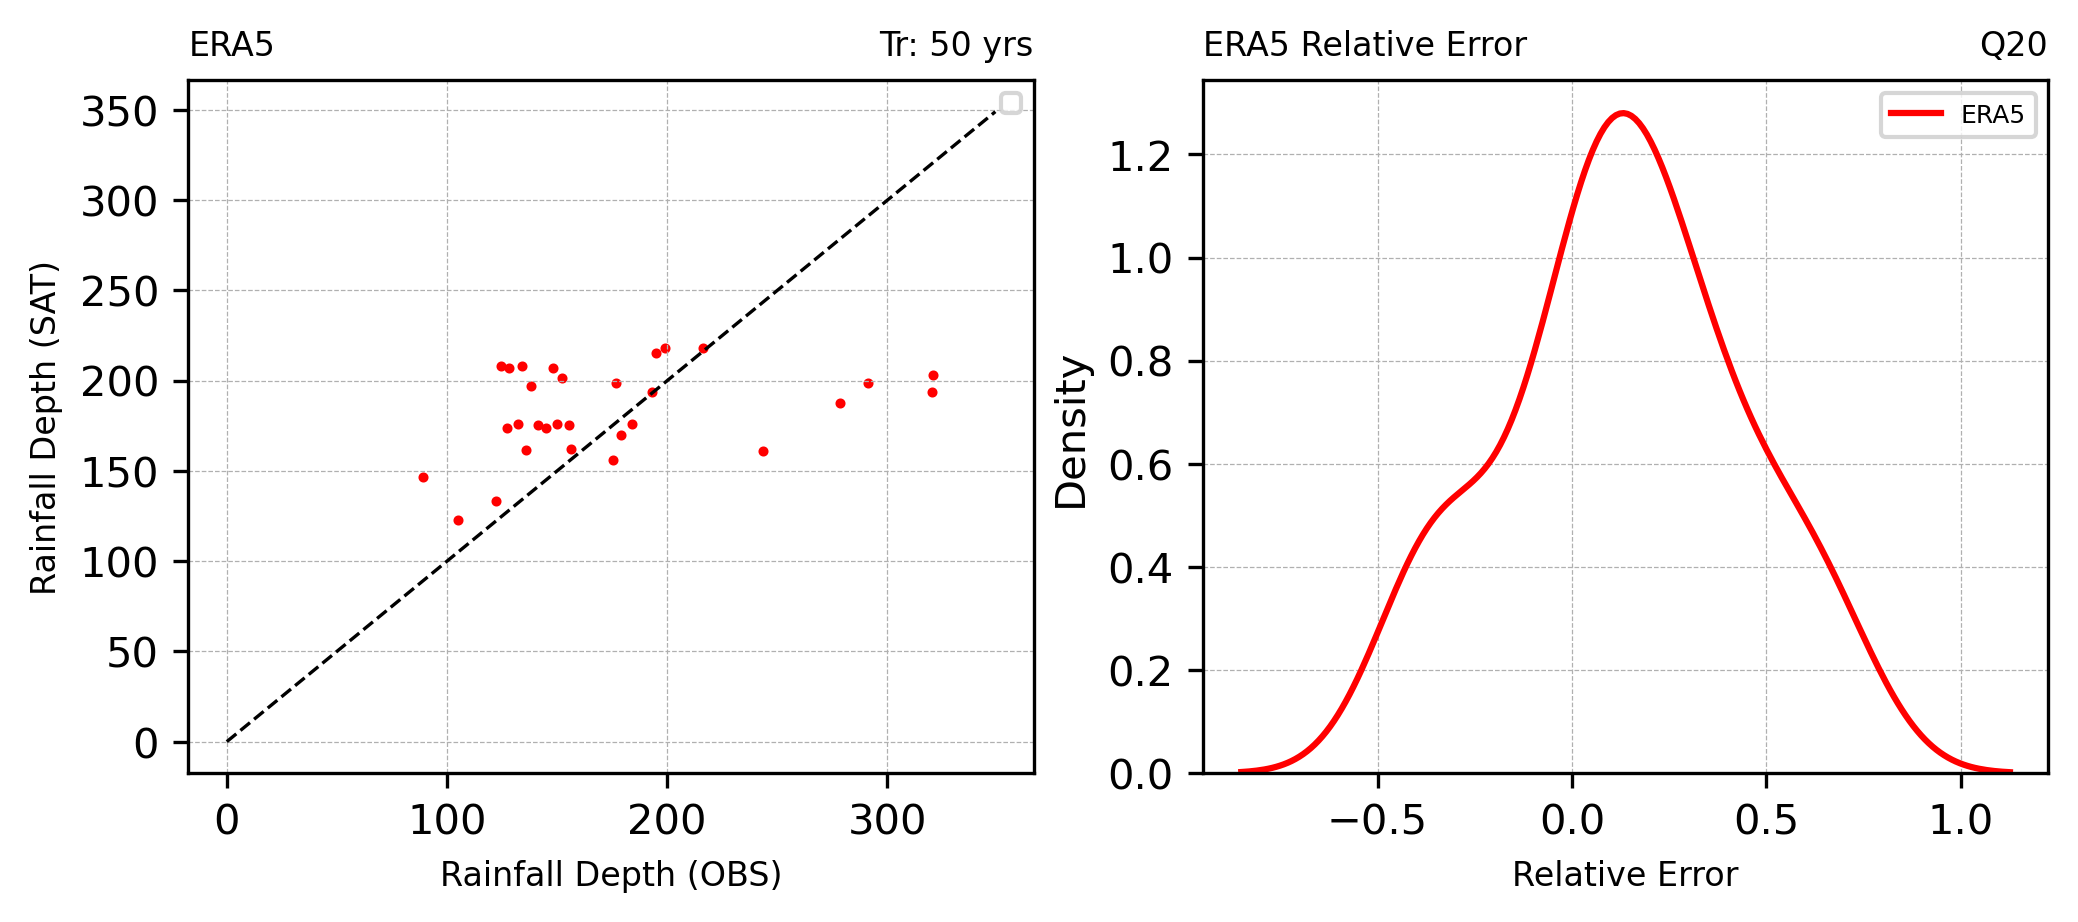

In [76]:
fig = plt.figure(figsize=(8,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(Q_20['Q50'],ERA5_QYd_CDFt_list,c='r',s=2)
ax1.plot(np.arange(350),np.arange(350),'--k',linewidth=0.8)

plt.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('ERA5',fontsize=8,loc='left')
ax1.set_title('Tr: 50 yrs',fontsize=8,loc='right')
ax1.set_xlabel('Rainfall Depth (OBS)',fontsize=8)
ax1.set_ylabel('Rainfall Depth (SAT)',fontsize=8)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
sns.kdeplot((ERA5_QYd_CDFt_list-Q_20['Q50'])/Q_20['Q50'],color='r',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ERA5')

ax1.set_title('ERA5 Relative Error',fontsize=8,loc='left')
ax1.set_title('Q20',fontsize=8,loc='right')
ax1.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlabel('Relative Error',fontsize=8)

Text(0.5, 0, 'Relative Error')

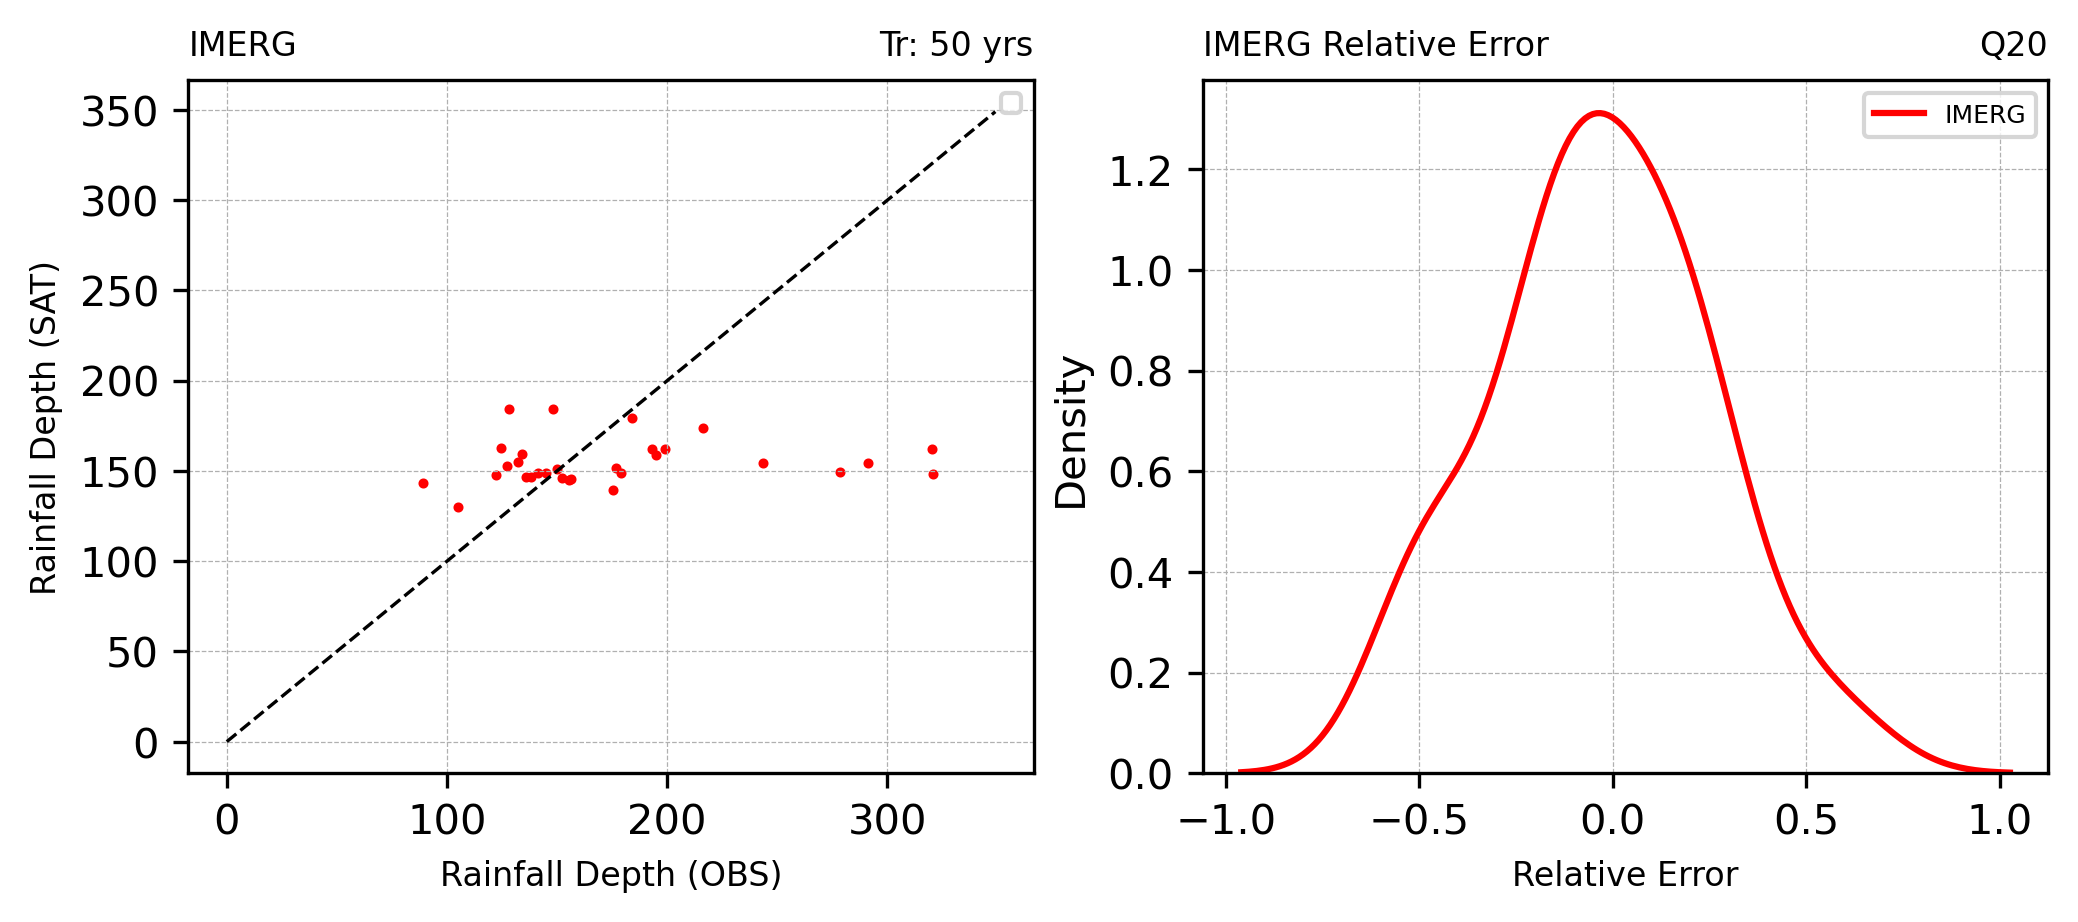

In [77]:
fig = plt.figure(figsize=(8,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(Q_20['Q50'],IMERG_QYd_CDFt_list,c='r',s=2)
ax1.plot(np.arange(350),np.arange(350),'--k',linewidth=0.8)

plt.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('IMERG',fontsize=8,loc='left')
ax1.set_title('Tr: 50 yrs',fontsize=8,loc='right')
ax1.set_xlabel('Rainfall Depth (OBS)',fontsize=8)
ax1.set_ylabel('Rainfall Depth (SAT)',fontsize=8)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
sns.kdeplot((IMERG_QYd_CDFt_list-Q_20['Q50'])/Q_20['Q50'],color='r',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'IMERG')

ax1.set_title('IMERG Relative Error',fontsize=8,loc='left')
ax1.set_title('Q20',fontsize=8,loc='right')
ax1.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlabel('Relative Error',fontsize=8)

Text(0.5, 0, 'Relative Error')

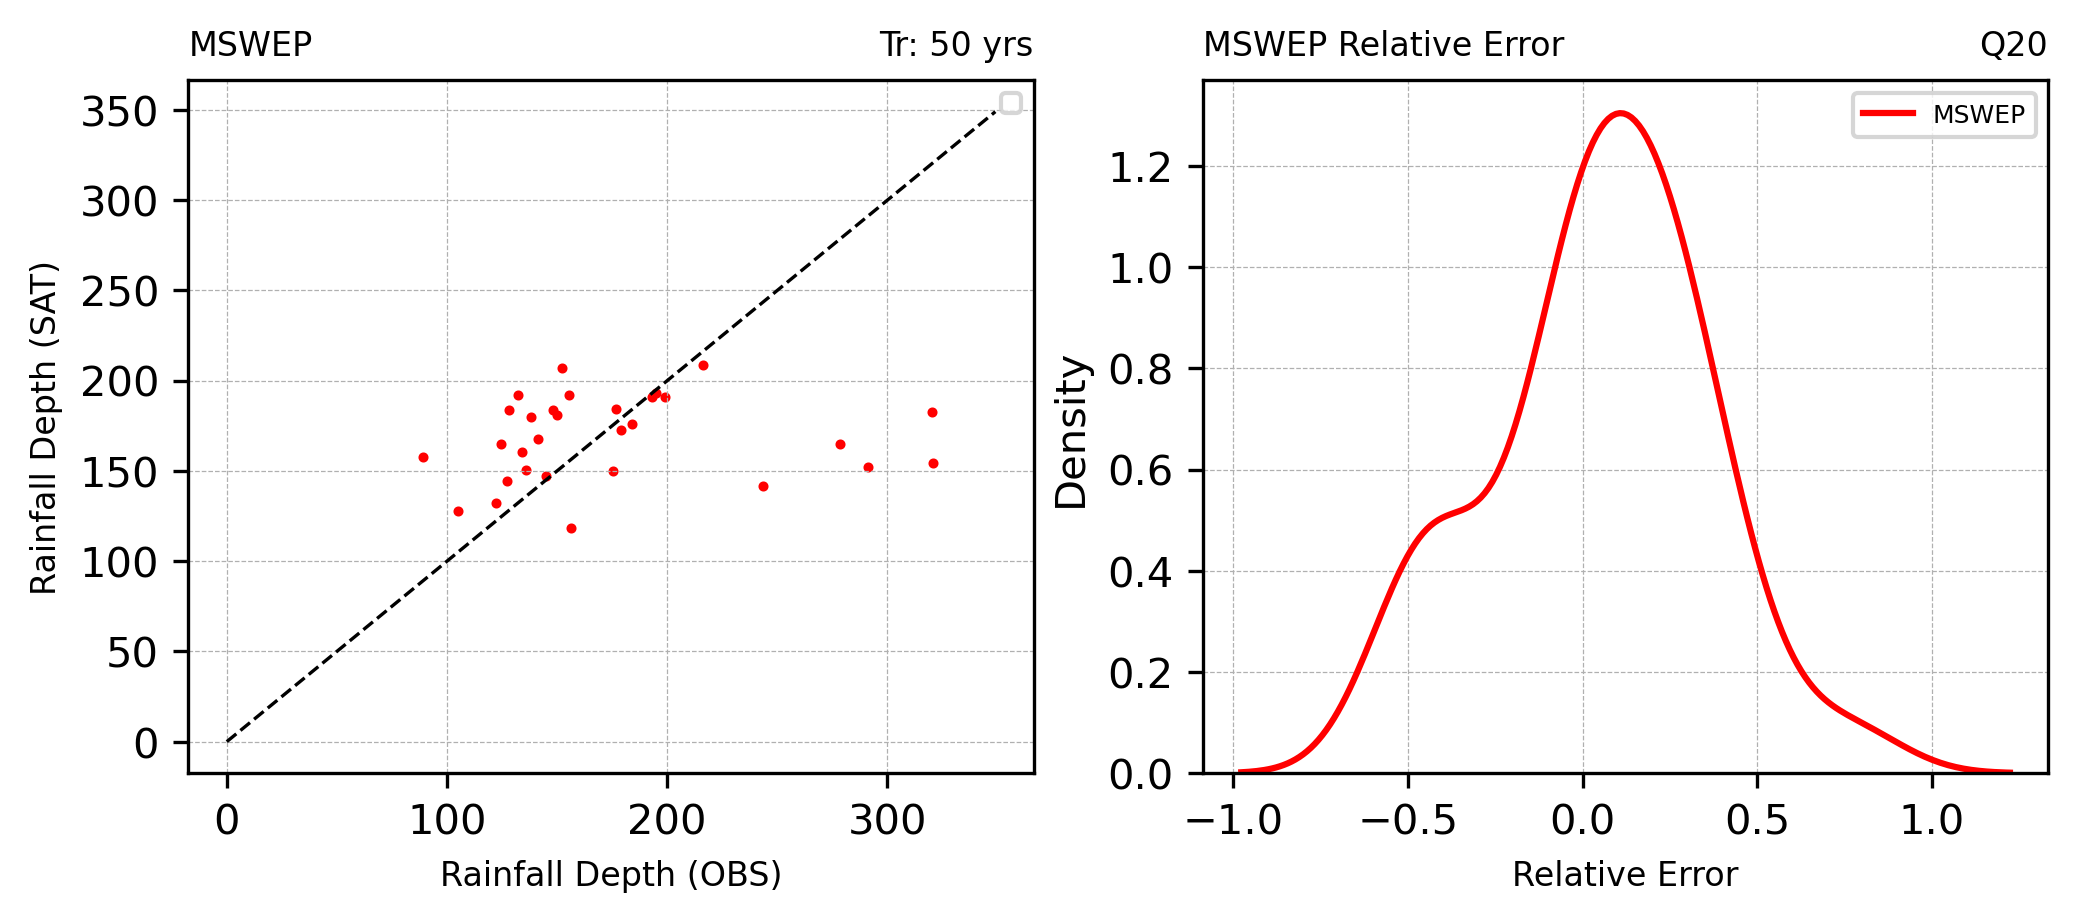

In [78]:
fig = plt.figure(figsize=(8,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(Q_20['Q50'],MSWEP_QYd_CDFt_list,c='r',s=2)
ax1.plot(np.arange(350),np.arange(350),'--k',linewidth=0.8)

plt.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('MSWEP',fontsize=8,loc='left')
ax1.set_title('Tr: 50 yrs',fontsize=8,loc='right')
ax1.set_xlabel('Rainfall Depth (OBS)',fontsize=8)
ax1.set_ylabel('Rainfall Depth (SAT)',fontsize=8)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
sns.kdeplot((MSWEP_QYd_CDFt_list-Q_20['Q50'])/Q_20['Q50'],color='r',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'MSWEP')

ax1.set_title('MSWEP Relative Error',fontsize=8,loc='left')
ax1.set_title('Q20',fontsize=8,loc='right')
ax1.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlabel('Relative Error',fontsize=8)

Text(0.5, 0, 'Relative Error')

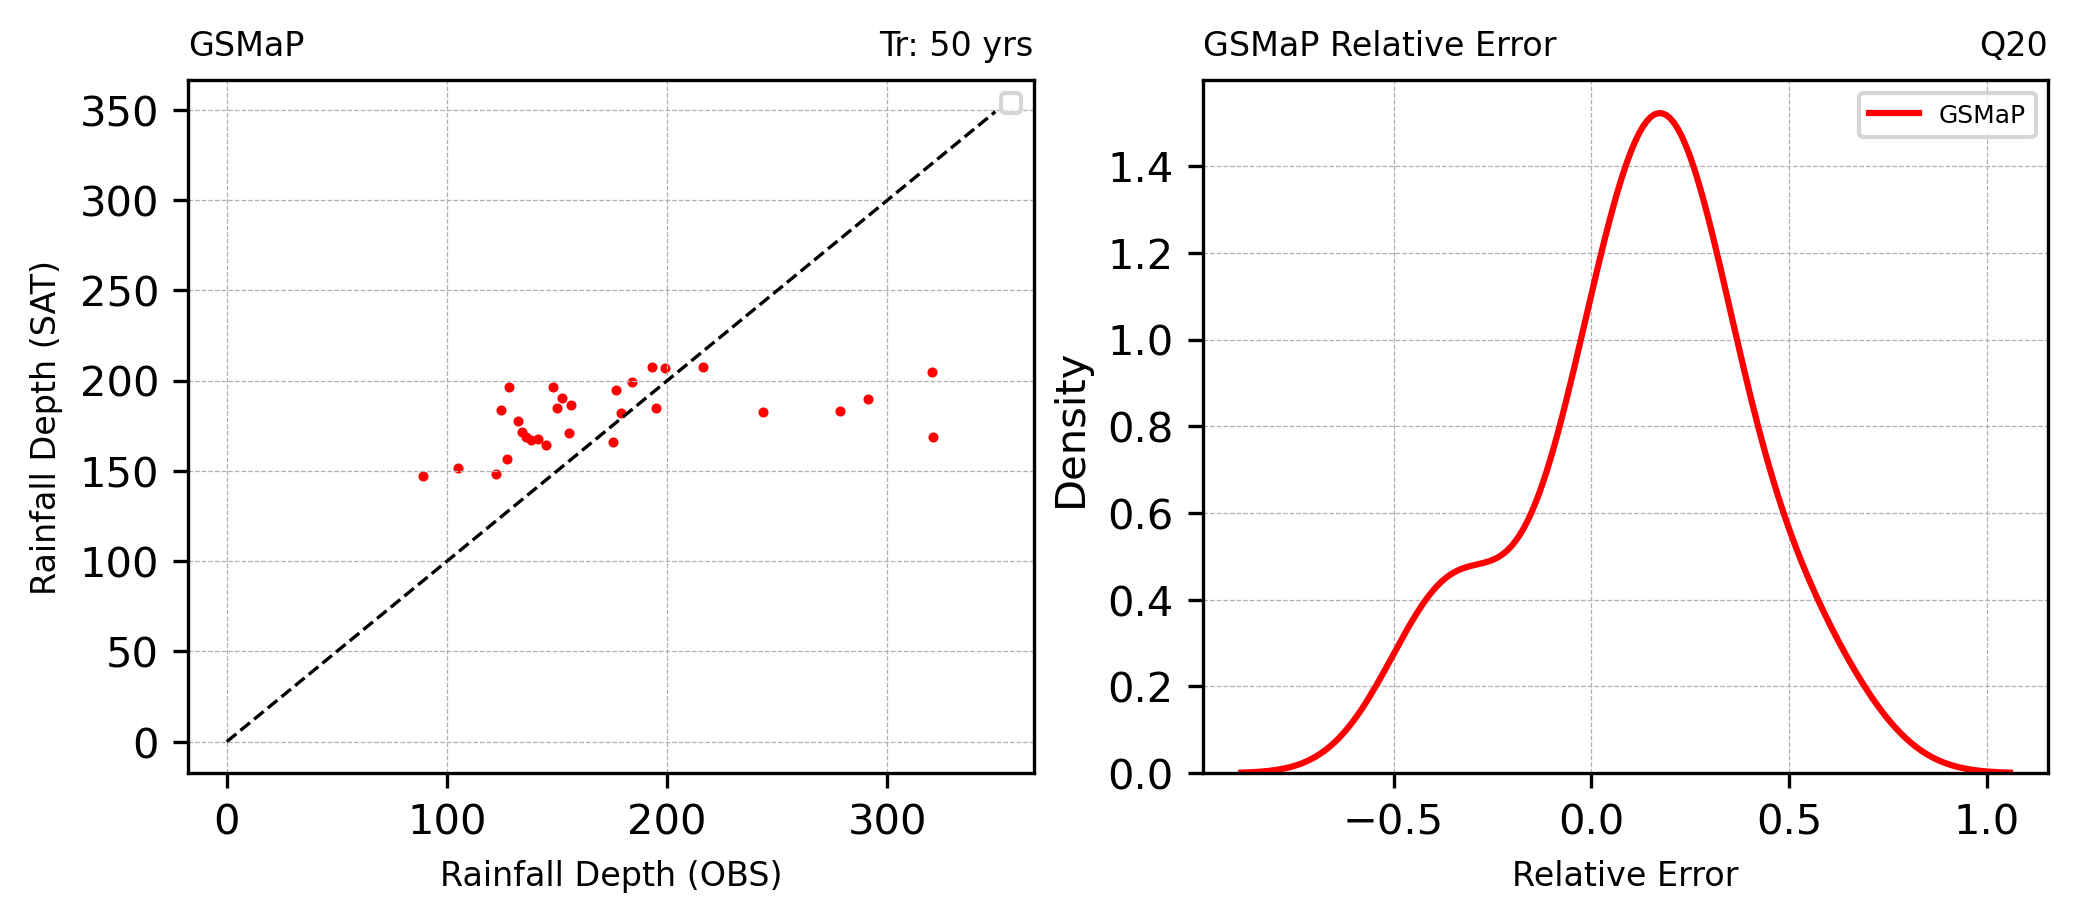

In [79]:
fig = plt.figure(figsize=(8,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(Q_20['Q50'],GSMaP_QYd_CDFt_list,c='r',s=2)
ax1.plot(np.arange(350),np.arange(350),'--k',linewidth=0.8)

plt.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('GSMaP',fontsize=8,loc='left')
ax1.set_title('Tr: 50 yrs',fontsize=8,loc='right')
ax1.set_xlabel('Rainfall Depth (OBS)',fontsize=8)
ax1.set_ylabel('Rainfall Depth (SAT)',fontsize=8)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
sns.kdeplot((GSMaP_QYd_CDFt_list-Q_20['Q50'])/Q_20['Q50'],color='r',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'GSMaP')

ax1.set_title('GSMaP Relative Error',fontsize=8,loc='left')
ax1.set_title('Q20',fontsize=8,loc='right')
ax1.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlabel('Relative Error',fontsize=8)

Text(0.5, 0, 'Relative Error')

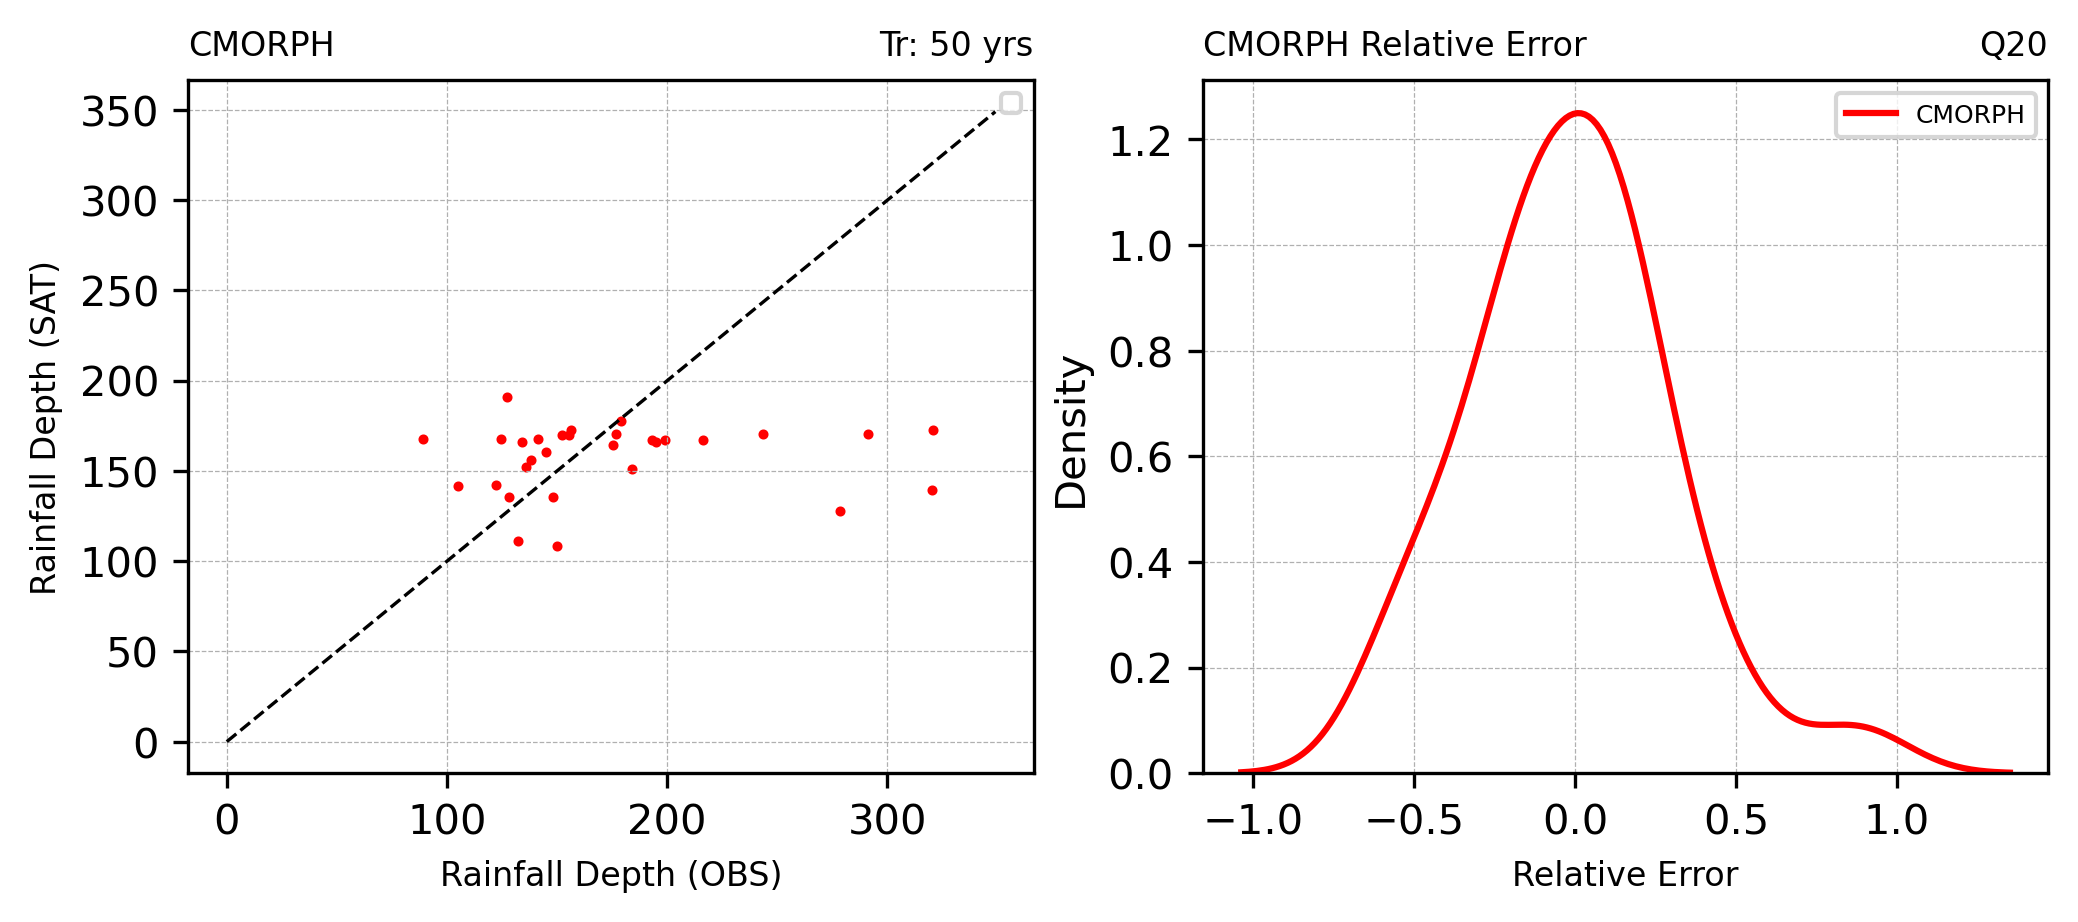

In [80]:
fig = plt.figure(figsize=(8,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(Q_20['Q50'],CMORPH_QYd_CDFt_list,c='r',s=2)
ax1.plot(np.arange(350),np.arange(350),'--k',linewidth=0.8)

plt.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('CMORPH',fontsize=8,loc='left')
ax1.set_title('Tr: 50 yrs',fontsize=8,loc='right')
ax1.set_xlabel('Rainfall Depth (OBS)',fontsize=8)
ax1.set_ylabel('Rainfall Depth (SAT)',fontsize=8)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
sns.kdeplot((CMORPH_QYd_CDFt_list-Q_20['Q50'])/Q_20['Q50'],color='r',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CMORPH')

ax1.set_title('CMORPH Relative Error',fontsize=8,loc='left')
ax1.set_title('Q20',fontsize=8,loc='right')
ax1.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlabel('Relative Error',fontsize=8)

Text(0.5, 0, 'Relative Error')

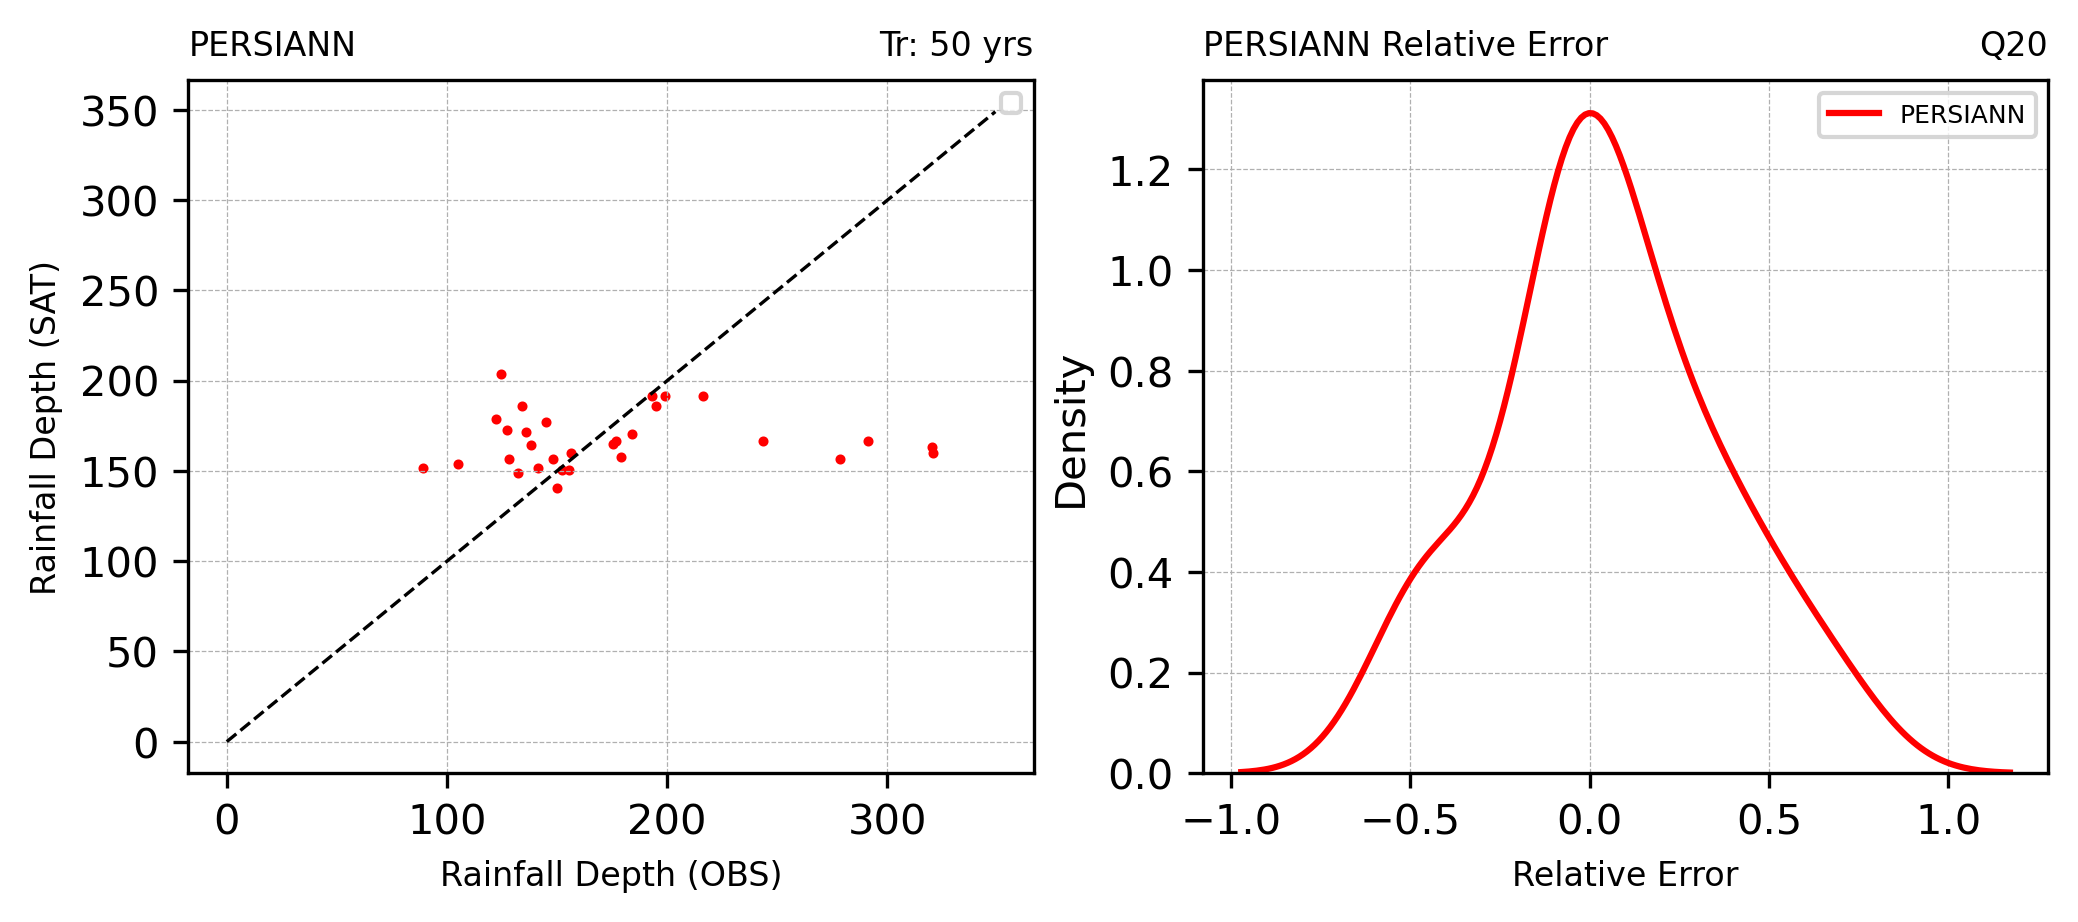

In [81]:
fig = plt.figure(figsize=(8,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(Q_20['Q50'],PERSIANN_QYd_CDFt_list,c='r',s=2)
ax1.plot(np.arange(350),np.arange(350),'--k',linewidth=0.8)

plt.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('PERSIANN',fontsize=8,loc='left')
ax1.set_title('Tr: 50 yrs',fontsize=8,loc='right')
ax1.set_xlabel('Rainfall Depth (OBS)',fontsize=8)
ax1.set_ylabel('Rainfall Depth (SAT)',fontsize=8)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
sns.kdeplot((PERSIANN_QYd_CDFt_list-Q_20['Q50'])/Q_20['Q50'],color='r',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'PERSIANN')

ax1.set_title('PERSIANN Relative Error',fontsize=8,loc='left')
ax1.set_title('Q20',fontsize=8,loc='right')
ax1.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlabel('Relative Error',fontsize=8)

Text(0.5, 0, 'Relative Error')

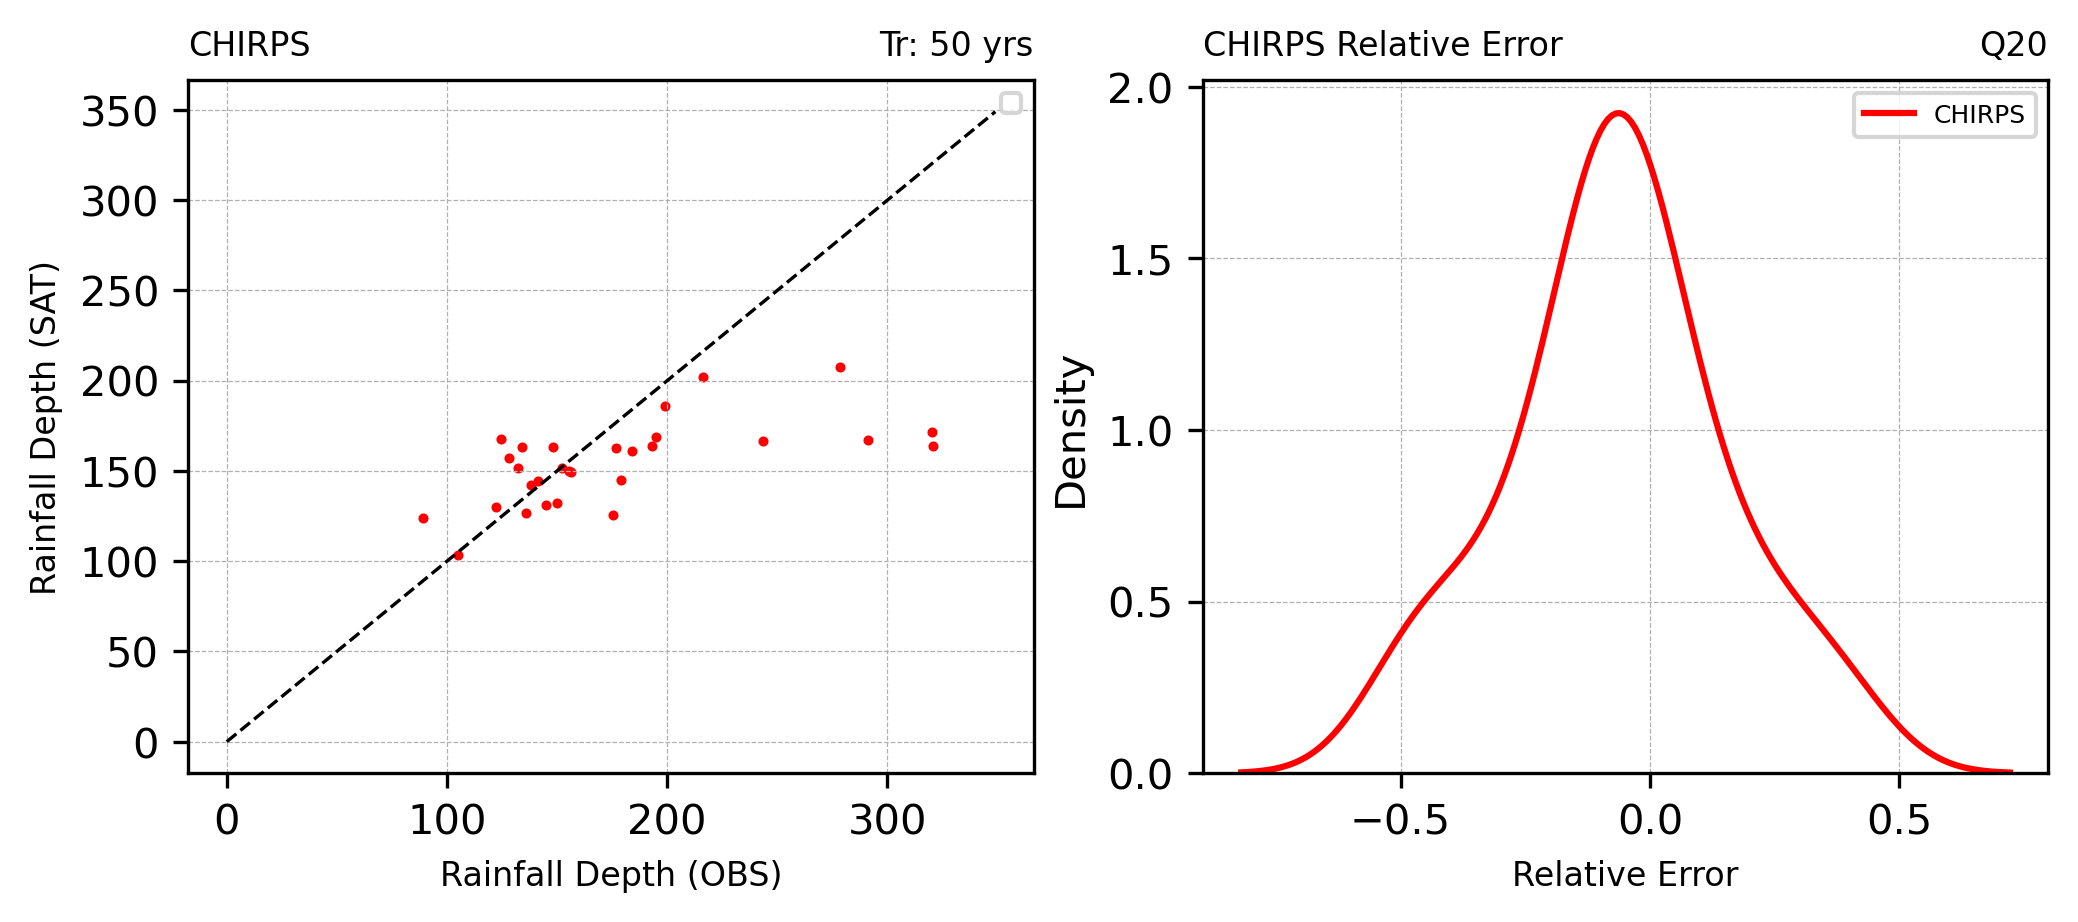

In [82]:
fig = plt.figure(figsize=(8,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(Q_20['Q50'],CHIRPS_QYd_CDFt_list,c='r',s=2)
ax1.plot(np.arange(350),np.arange(350),'--k',linewidth=0.8)

plt.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('CHIRPS',fontsize=8,loc='left')
ax1.set_title('Tr: 50 yrs',fontsize=8,loc='right')
ax1.set_xlabel('Rainfall Depth (OBS)',fontsize=8)
ax1.set_ylabel('Rainfall Depth (SAT)',fontsize=8)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
sns.kdeplot((CHIRPS_QYd_CDFt_list-Q_20['Q50'])/Q_20['Q50'],color='r',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CHIRPS')

ax1.set_title('CHIRPS Relative Error',fontsize=8,loc='left')
ax1.set_title('Q20',fontsize=8,loc='right')
ax1.legend(fontsize=6)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlabel('Relative Error',fontsize=8)

## RELATIVE ERROR FOR 20% USING RAW DATA

In [83]:
EQ_IMERG, EQ_CMORPH, EQ_MSWEP, EQ_ERA5, EQ_GSMaP, EQ_SM2RAIN, EQ_PERSIANN, EQ_CHIRPS = [], [], [], [], [], [], [],[]
EQd_IMERG, EQd_CMORPH, EQd_MSWEP, EQd_ERA5, EQd_GSMaP, EQd_SM2RAIN, EQd_PERSIANN, EQd_CHIRPS = [], [], [], [], [], [], [],[]
EQ_ESEMBLE, Q_SAT_list, EQd_ESEMBLE = [], [], []

for nn in range(len(Q_20)):
    Q_OBS = Q_20[Q_index].values[nn]
    lat_obs = Q_20['Lat'].values[nn]
    lon_obs = Q_20['Lon'].values[nn]
    elv_obs = Q_20['Elv'].values[nn]

    # ==============================================================================
    # IMERG
    distances = ART_pre.haversine(lat2d_IMERG, lon2d_IMERG, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    
    IMERG_Q = QIMERG[Tr_index,min_index[0],min_index[1]]
    EQ = (IMERG_Q - Q_OBS)/Q_OBS
    EQ_IMERG.append(float(EQ))
    
    IMERG_Qd = QdIMERG[Tr_index,min_index[0],min_index[1]]
    EQ = (IMERG_Qd - Q_OBS)/Q_OBS
    EQd_IMERG.append(float(EQ))

    # ==============================================================================
    # CMORPH
    distances = ART_pre.haversine(lat2d_CMORPH, lon2d_CMORPH, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    
    CMORPH_Q = QCMORPH[Tr_index,min_index[0],min_index[1]]
    EQ = (CMORPH_Q - Q_OBS)/Q_OBS
    EQ_CMORPH.append(float(EQ))

    CMORPH_Qd = QdCMORPH[Tr_index,min_index[0],min_index[1]]
    EQ = (CMORPH_Qd - Q_OBS)/Q_OBS
    EQd_CMORPH.append(float(EQ))

    # ==============================================================================
    # MSWEP
    distances = ART_pre.haversine(lat2d_MSWEP, lon2d_MSWEP, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    
    MSWEP_Q = QMSWEP[Tr_index,min_index[0],min_index[1]]
    EQ = (MSWEP_Q - Q_OBS)/Q_OBS
    EQ_MSWEP.append(float(EQ))
    
    MSWEP_Qd = QdMSWEP[Tr_index,min_index[0],min_index[1]]
    EQ = (MSWEP_Qd - Q_OBS)/Q_OBS
    EQd_MSWEP.append(float(EQ))

    # ==============================================================================
    # ERA5
    distances = ART_pre.haversine(lat2d_ERA5, lon2d_ERA5, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    
    ERA5_Q = QERA5[Tr_index,min_index[0],min_index[1]]
    EQ = (ERA5_Q - Q_OBS)/Q_OBS
    EQ_ERA5.append(float(EQ))
    
    ERA5_Qd = QdERA5[Tr_index,min_index[0],min_index[1]]
    EQ = (ERA5_Qd - Q_OBS)/Q_OBS
    EQd_ERA5.append(float(EQ))

    # ==============================================================================
    # GSMaP
    distances = ART_pre.haversine(lat2d_GSMaP, lon2d_GSMaP, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    
    GSMaP_Q = QGSMaP[Tr_index,min_index[0],min_index[1]]
    EQ = (GSMaP_Q - Q_OBS)/Q_OBS
    EQ_GSMaP.append(float(EQ))
    
    GSMaP_Qd = QdGSMaP[Tr_index,min_index[0],min_index[1]]
    EQ = (GSMaP_Qd - Q_OBS)/Q_OBS
    EQd_GSMaP.append(float(EQ))

    # # ==============================================================================
    # # SM2RAIN
    # distances = ART_pre.haversine(lat_SM2RAIN, lon_SM2RAIN, lat_obs, lon_obs)
    # min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    
    # SM2RAIN_Q = QSM2RAIN[Tr_index,min_index[0],min_index[1]]
    # EQ = (SM2RAIN_Q - Q_OBS)/Q_OBS
    # EQ_SM2RAIN.append(float(EQ))
    
    # SM2RAIN_Qd = QdSM2RAIN[Tr_index,min_index[0],min_index[1]]
    # EQ = (SM2RAIN_Qd - Q_OBS)/Q_OBS
    # EQd_SM2RAIN.append(float(EQ))

    # ==============================================================================
    # PERSIANN
    distances = ART_pre.haversine(lat2d_PERSIANN, lon2d_PERSIANN, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    
    PERSIANN_Q = QPERSIANN[Tr_index,min_index[0],min_index[1]]
    EQ = (PERSIANN_Q - Q_OBS)/Q_OBS
    EQ_PERSIANN.append(float(EQ))
    
    PERSIANN_Qd = QdPERSIANN[Tr_index,min_index[0],min_index[1]]
    EQ = (PERSIANN_Qd - Q_OBS)/Q_OBS
    EQd_PERSIANN.append(float(EQ))

    # ==============================================================================
    # CHIRPS
    distances = ART_pre.haversine(lat2d_CHIRPS, lon2d_CHIRPS, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    
    CHIRPS_Q = QCHIRPS[Tr_index,min_index[0],min_index[1]]
    EQ = (CHIRPS_Q - Q_OBS)/Q_OBS
    EQ_CHIRPS.append(float(EQ))
    
    CHIRPS_Qd = QdCHIRPS[Tr_index,min_index[0],min_index[1]]
    EQ = (CHIRPS_Qd - Q_OBS)/Q_OBS
    EQd_CHIRPS.append(float(EQ))

    # ==============================================================================
    SAT_ENSEMBLE_Q = np.nanmean(
                        [
                        IMERG_Q,
                        CMORPH_Q,
                        MSWEP_Q,
                        ERA5_Q,
                        GSMaP_Q,
                        # SM2RAIN_Qd,
                        # PERSIANN_Qd
                        CHIRPS_Q
                        ],axis=0)
    EQ_ESEMBLE_ = (SAT_ENSEMBLE_Q - Q_OBS)/Q_OBS
    EQ_ESEMBLE.append(EQ_ESEMBLE_)
    
    SAT_ENSEMBLE_Qd = np.nanmean(
                        [
                        IMERG_Qd,
                        CMORPH_Qd,
                        MSWEP_Qd,
                        ERA5_Qd,
                        GSMaP_Qd,
                        # SM2RAIN_Qd,
                        # PERSIANN_Qd
                        CHIRPS_Qd
                        ],axis=0)
    EQd_ESEMBLE_ = (SAT_ENSEMBLE_Qd - Q_OBS)/Q_OBS
    EQd_ESEMBLE.append(EQd_ESEMBLE_)

    Q_SAT_list.append({
        'Lat': lat_obs,
        'Lon': lon_obs,
        'Elv':elv_obs,
        'OBS': Q_OBS,
        'IMERG': IMERG_Q,
        'IMERGd': IMERG_Qd,
        'CMORPH': CMORPH_Q,
        'CMORPHd': CMORPH_Qd,
        'MSWEP': MSWEP_Q,
        'MSWEPd': MSWEP_Qd,
        'ERA5': ERA5_Q,
        'ERA5d': ERA5_Qd,
        'GSMaP': GSMaP_Q,
        'GSMaPd': GSMaP_Qd,
        # 'SM2RAIN': SM2RAIN_Q,
        # 'SM2RAINd': SM2RAIN_Qd,
        'PERSIANN':PERSIANN_Q,
        'PERSIANNd':PERSIANN_Qd,
        'CHIRPS':CHIRPS_Q,
        'CHIRPSd':CHIRPS_Qd,
        'ENSEMBLE': SAT_ENSEMBLE_Q,
        'ENSEMBLEd': SAT_ENSEMBLE_Qd
    })

SATELLITE_pd = pd.DataFrame(Q_SAT_list)

In [84]:
E20_ERA5=(ERA5_QYd_CDFt_list-Q_20['Q50'])/Q_20['Q50']
E20_IMERG=(IMERG_QYd_CDFt_list-Q_20['Q50'])/Q_20['Q50']
E20_MSWEP=(MSWEP_QYd_CDFt_list-Q_20['Q50'])/Q_20['Q50']
E20_GSMaP=(GSMaP_QYd_CDFt_list-Q_20['Q50'])/Q_20['Q50']
E20_CMOPRH=(CMORPH_QYd_CDFt_list-Q_20['Q50'])/Q_20['Q50']
# E20_PERSIANN=(PERSIANN_QYd_CDFt_list-Q_20['Q50'])/Q_20['Q50']
E20_CHIRPS=(CHIRPS_QYd_CDFt_list-Q_20['Q50'])/Q_20['Q50']

E20_MEAN = np.nanmean([E20_ERA5,E20_IMERG,E20_MSWEP,E20_GSMaP,E20_CMOPRH,E20_CHIRPS],axis=0)

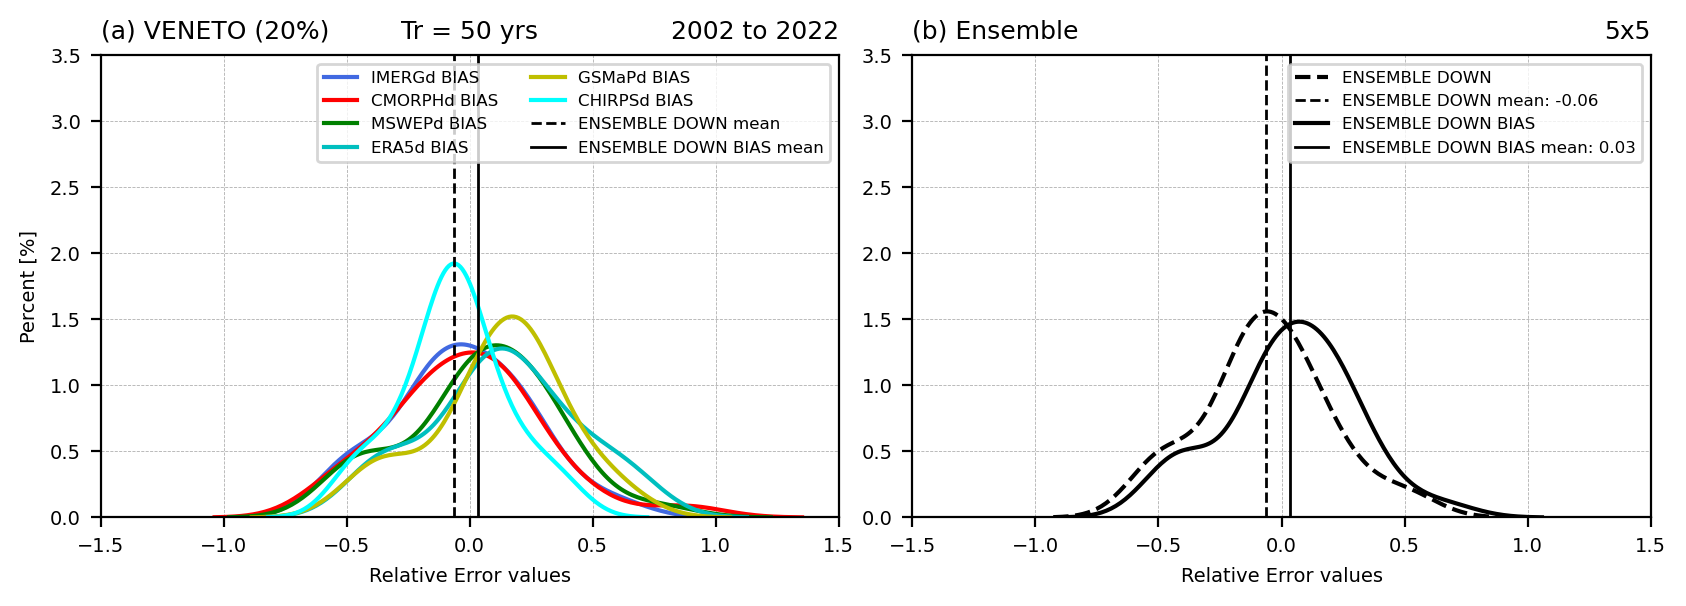

In [85]:
fig = plt.figure(figsize=(10,3),dpi=200)
gs = gridspec.GridSpec(1,2)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])
sns.kdeplot(E20_IMERG,color=colors[0],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'IMERGd BIAS')
sns.kdeplot(E20_CMOPRH,color=colors[1],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CMORPHd BIAS')
sns.kdeplot(E20_MSWEP,color=colors[2],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'MSWEPd BIAS')
sns.kdeplot(E20_ERA5,color=colors[3],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ERA5d BIAS')
sns.kdeplot(E20_GSMaP,color=colors[4],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'GSMaPd BIAS')
# sns.kdeplot(E20_PERSIANN,color=colors[5],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'PERSIANN')
sns.kdeplot(E20_CHIRPS,color=colors[7],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CHIRPSd BIAS')

ax1.axvline(np.mean(EQd_ESEMBLE),color='k',linestyle='--',linewidth=1, label=f'ENSEMBLE DOWN mean')
ax1.axvline(np.mean(E20_MEAN),color='k',linestyle='-',linewidth=1, label=f'ENSEMBLE DOWN BIAS mean')

ax1.set_ylabel('Percent [%]',fontsize=7)
ax1.set_xlabel('Relative Error values',fontsize=7)
ax1.legend(fontsize=6, loc=0, ncol=2)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,3.5)
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_title(f'(a) {area} (20%)', fontsize=9, loc='left')
ax1.set_title(f'Tr = 50 yrs',fontsize=9, loc='Center')
ax1.set_title(f'{yy_s} to {yy_e}',fontsize=9, loc='right')

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 1])

sns.kdeplot(EQd_ESEMBLE,color='k', linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLE DOWN')
ax1.axvline(np.mean(EQd_ESEMBLE),color='k',linestyle='--',linewidth=1, label=f'ENSEMBLE DOWN mean: {np.round(np.nanmean(np.mean(EQd_ESEMBLE)),2)}')

sns.kdeplot(E20_MEAN,color='k',linestyle='-',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLE DOWN BIAS')
ax1.axvline(np.mean(E20_MEAN),color='k',linestyle='-',linewidth=1, label=f'ENSEMBLE DOWN BIAS mean: {np.round(np.nanmean(np.mean(E20_MEAN)),2)}')

ax1.legend(fontsize=6, loc=0, ncol=1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,3.5)
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_ylabel('')
ax1.set_xlabel('Relative Error values',fontsize=7) 
ax1.set_title(f'(b) Ensemble', fontsize=9, loc='left')
# ax1.set_title(f'ACF: {method}', fontsize=9, loc='center')
ax1.set_title(f'{NEIBHR}x{NEIBHR}', fontsize=9, loc='right')

# =========================================================================================================================
plt.subplots_adjust(wspace=0.1, hspace=0.1)
ax1.set_facecolor('white')
fig.patch.set_alpha(0)

salida = os.path.join('/','home','arturo','Pictures','ERRORS',f'RE_sedd_{seed}_VAL_20.png')
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

In [86]:
# Export Quantiles to verify the difference with differents seeds
Qdf_20 = pd.DataFrame({
                        'IMERG20Qs':E20_IMERG,
                        'CMORPH20Qs':E20_CMOPRH,
                        'MSWEP20Qs':E20_MSWEP,
                        'ERA520Qs':E20_ERA5,
                        'GSMaP20Qs':E20_GSMaP,
                        'CHIRPS20Qs':E20_CHIRPS,
                        'ENSEMBLE20Qd':EQd_ESEMBLE, 'ENSEMBLE20Qd_BIAS':E20_MEAN})
salida = os.path.join('/','home','arturo','Pictures','ERRORS','csv',f'Q20_seed_{seed}.csv')
Qdf_20.to_csv(salida,header=True)

In [87]:
# fig = plt.figure(figsize=(6,4.5),dpi=300)
# gs = gridspec.GridSpec(2,3)

# # =================================================================
# ax1 = plt.subplot(gs[0, 0])

# ax1.tick_params(axis='both', which='major', labelsize=5)
# ax1.legend(fontsize=5,loc=2)
# ax1.grid(linewidth=0.3,linestyle='--')

# ax1.set_title(f"(a) IMERG", fontsize=6, loc='left',pad=3)
# ax1.set_title(f"{method}", fontsize=6, loc='right',pad=3)

# # =================================================================
# ax1 = plt.subplot(gs[0, 1])

# ax1.tick_params(axis='both', which='major', labelsize=5)
# ax1.legend(fontsize=5,loc=2)
# ax1.grid(linewidth=0.3,linestyle='--')

# ax1.set_title(f"(b) MSWEP", fontsize=6, loc='left',pad=3)
# ax1.set_title(f"{method}", fontsize=6, loc='right',pad=3)

# # =================================================================
# ax1 = plt.subplot(gs[0, 2])

# ax1.tick_params(axis='both', which='major', labelsize=5)
# ax1.legend(fontsize=5,loc=2)
# ax1.grid(linewidth=0.3,linestyle='--')

# ax1.set_title(f"(c) CMORPH", fontsize=6, loc='left',pad=3)
# ax1.set_title(f"{method}", fontsize=6, loc='right',pad=3)

# # =================================================================
# ax1 = plt.subplot(gs[1, 0])
# ax1.scatter(SATELLITE_pd['OBS'], SATELLITE_pd['ERA5_Q50d'],c='b',s=1,label='Before')
# ax1.scatter(SATELLITE_pd['OBS'], ERA5_QYd_CDFt_list,c='r',s=1,label='After')

# # ax1.plot(REG_ERA51[0],REG_ERA51[1],color='b',linewidth=0.6,linestyle='--')
# # ax1.plot(REG_ERA52[0],REG_ERA52[1],color='r',linewidth=0.6,linestyle='--')

# ax1.tick_params(axis='both', which='major', labelsize=5)
# ax1.legend(fontsize=5,loc=2)
# ax1.grid(linewidth=0.3,linestyle='--')

# ax1.set_title(f"(d) ERA5", fontsize=6, loc='left',pad=3)
# ax1.set_title(f"{method}", fontsize=6, loc='right',pad=3)

# # =================================================================
# ax1 = plt.subplot(gs[1, 1])

# ax1.tick_params(axis='both', which='major', labelsize=5)
# ax1.legend(fontsize=5,loc=2)
# ax1.grid(linewidth=0.3,linestyle='--')

# ax1.set_title(f"(e) GSMaP", fontsize=6, loc='left',pad=3)
# ax1.set_title(f"{method}", fontsize=6, loc='right',pad=3)

# # =================================================================
# ax1 = plt.subplot(gs[1, 2])


# ax1.tick_params(axis='both', which='major', labelsize=5)
# ax1.legend(fontsize=5,loc=2)
# ax1.grid(linewidth=0.3,linestyle='--')

# ax1.set_title(f"(f) PERSIANN", fontsize=6, loc='left',pad=3)
# ax1.set_title(f"{method}", fontsize=6, loc='right',pad=3)

# salida = os.path.join('..','figures','QERROR',f'Relative_Error_{method}_{yy_s}_{yy_e}_Scatter_Q80.png')
# print(f'Export figure to: {salida}')
# # plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

In [88]:
playsound("../sound/HOMER_DOH.mp3")

In [89]:
# Stop Notebook
sys.exit("🛑 The execution of the cell was stopped")

SystemExit: 🛑 The execution of the cell was stopped

## QUANTILES MAP CORRECTED AND UNCORRECTED

In [ ]:
Qdfinal = np.zeros([len(lats_IMERG),len(lons_IMERG)])
Qdfinal_BIAS = np.zeros([len(lats_IMERG),len(lons_IMERG)])
for la in range(len(lats_IMERG)):
    for lo in range(len(lons_IMERG)):
        lat_sat = lats_IMERG[la]
        lon_sat = lons_IMERG[lo]
        
        # ==============================================================================
        # CMORPH
        distances = ART_pre.haversine(lat2d_CMORPH, lon2d_CMORPH, lat_sat, lon_sat)
        min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
        QdCMORPH_tmp = QdCMORPH[Tr_index,min_index[0],min_index[1]]
        QdCMORPH_tmp_bias = CMORPH_QYd_CDFt[Tr_index,min_index[0],min_index[1]]

        # ==============================================================================
        # MSWEP
        distances = ART_pre.haversine(lat2d_MSWEP, lon2d_MSWEP, lat_sat, lon_sat)
        min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
        QdMSWEP_tmp = QdMSWEP[Tr_index,min_index[0],min_index[1]]
        QdMSWEP_tmp_bias = MSWEP_QYd_CDFt[Tr_index,min_index[0],min_index[1]]

        # ==============================================================================
        # ERA5
        distances = ART_pre.haversine(lat2d_ERA5, lon2d_ERA5, lat_sat, lon_sat)
        min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
        QdERA5_tmp = QdERA5[Tr_index,min_index[0],min_index[1]]
        QdERA5_tmp_bias = ERA5_QYd_CDFt[Tr_index,min_index[0],min_index[1]]

        # ==============================================================================
        # GSMaP
        distances = ART_pre.haversine(lat2d_GSMaP, lon2d_GSMaP, lat_sat, lon_sat)
        min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
        QdGSMaP_tmp = QdGSMaP[Tr_index,min_index[0],min_index[1]]
        QdGSMaP_tmp_bias = GSMaP_QYd_CDFt[Tr_index,min_index[0],min_index[1]]

        # ==============================================================================
        # CHIRPS
        distances = ART_pre.haversine(lat2d_CHIRPS, lon2d_CHIRPS, lat_sat, lon_sat)
        min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
        QdCHIRPS_tmp = QdCHIRPS[Tr_index,min_index[0],min_index[1]]
        QdCHIRPS_tmp_bias = CHIRPS_QYd_CDFt[Tr_index,min_index[0],min_index[1]]

        Qdfinal_ = np.nanmean([QdIMERG[Tr_index,la,lo],QdCMORPH_tmp,QdMSWEP_tmp,QdERA5_tmp,QdGSMaP_tmp,QdCHIRPS_tmp])
        Qdfinal[la,lo] = Qdfinal_

        Qdfinal_BIAS_ = np.nanmean([IMERG_QYd_CDFt[Tr_index,la,lo],QdCMORPH_tmp_bias,QdMSWEP_tmp_bias,QdERA5_tmp_bias,QdGSMaP_tmp_bias,QdCHIRPS_tmp_bias])
        Qdfinal_BIAS[la,lo] = Qdfinal_BIAS_

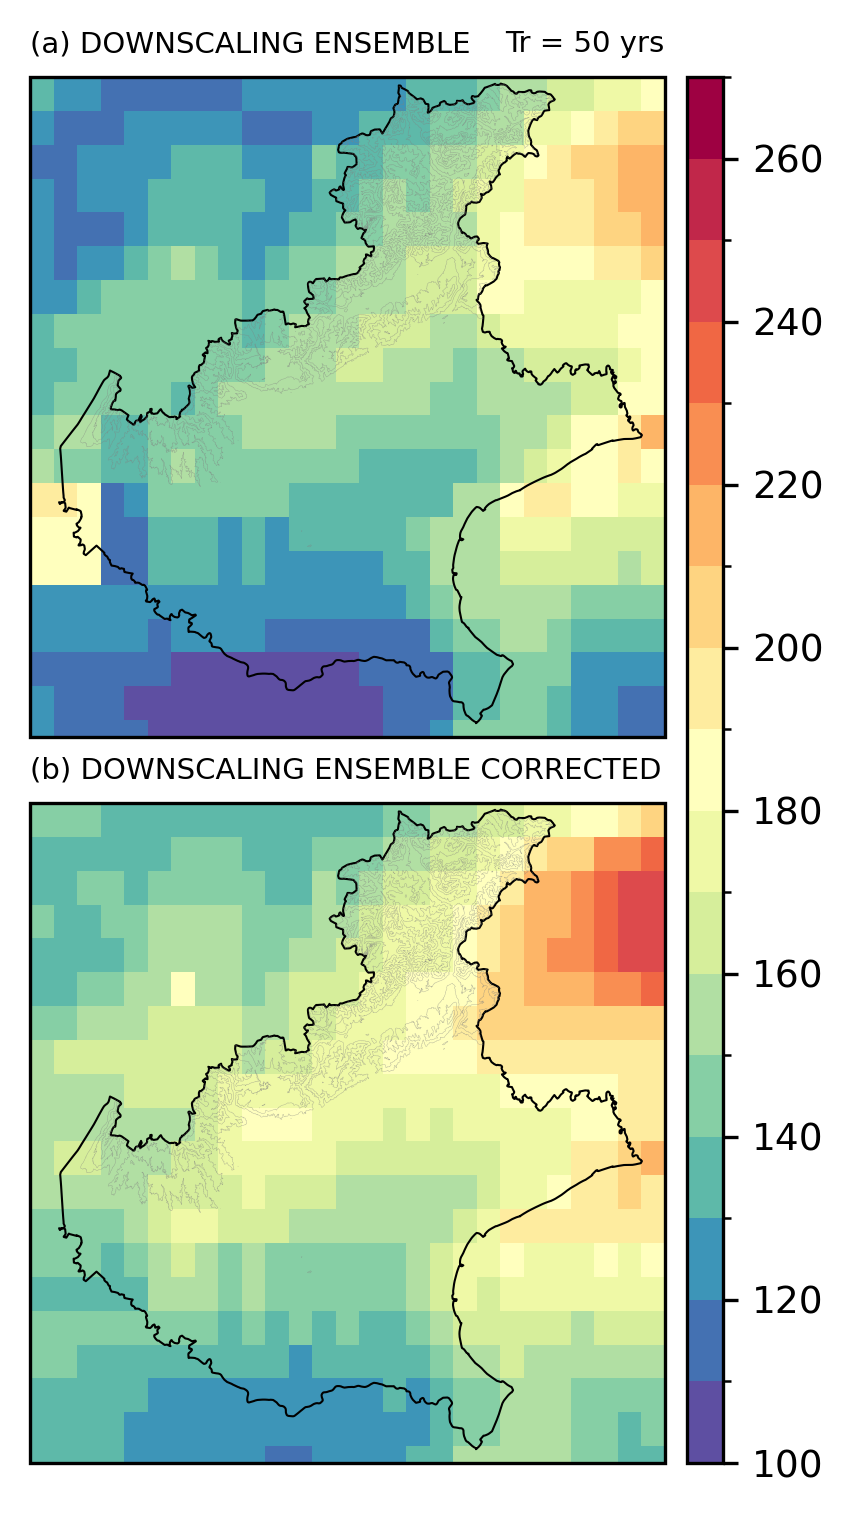

In [ ]:
Q_levels = np.arange(100,280,10)
Q_norm = mcolors.BoundaryNorm(boundaries=Q_levels, ncolors=256)

cmap = plt.cm.Spectral_r

fig = plt.figure(figsize=(3,6),dpi=300)
gs = gridspec.GridSpec(2,1)

# ======================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.75, 46.7],crs=proj)
a1 = ax1.pcolormesh(lon2d_IMERG, lat2d_IMERG, Qdfinal, cmap=cmap, norm=Q_norm)

VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
DEM.plot(facecolor='None',color='grey',alpha=0.6, ax=ax1, linewidth=0.1, zorder=10)

ax1.set_title(f'(a) DOWNSCALING ENSEMBLE', fontsize=7, loc='left')
ax1.set_title(f'Tr = 50 yrs', fontsize=7, loc='right')

# ======================================================================
ax1 = plt.subplot(gs[1, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.75, 46.7],crs=proj)
a1 = ax1.pcolormesh(lon2d_IMERG, lat2d_IMERG, Qdfinal_BIAS, cmap=cmap, norm=Q_norm)

VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
DEM.plot(facecolor='None',color='grey',alpha=0.6, ax=ax1, linewidth=0.1, zorder=10)

ax1.set_title(f'(b) DOWNSCALING ENSEMBLE CORRECTED', fontsize=7, loc='left')

# ======================================================================
cbar_ax = fig.add_axes([0.89, 0.11, 0.04, 0.77])#0.89
cbar = plt.colorbar(a1, cax=cbar_ax, orientation='vertical')
cbar.ax.tick_params(labelsize=9)

# ======================================================================
plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)


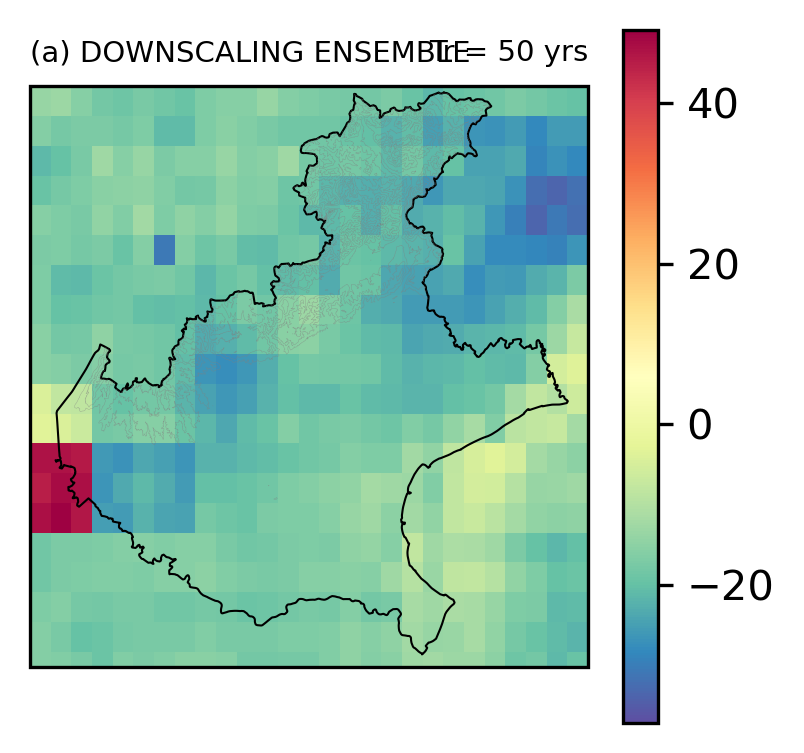

In [ ]:
Q_levels = np.arange(100,280,10)
Q_norm = mcolors.BoundaryNorm(boundaries=Q_levels, ncolors=256)

cmap = plt.cm.Spectral_r

fig = plt.figure(figsize=(3,3),dpi=300)
gs = gridspec.GridSpec(1,1)

# ======================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.75, 46.7],crs=proj)
a1 = ax1.pcolormesh(lon2d_IMERG, lat2d_IMERG, Qdfinal-Qdfinal_BIAS, cmap=cmap)

VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
DEM.plot(facecolor='None',color='grey',alpha=0.6, ax=ax1, linewidth=0.1, zorder=10)

ax1.set_title(f'(a) DOWNSCALING ENSEMBLE', fontsize=7, loc='left')
ax1.set_title(f'Tr = 50 yrs', fontsize=7, loc='right')

plt.colorbar(a1)

# ======================================================================
plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)


In [ ]:
# Stop Notebook
sys.exit("🛑 The execution of the cell was stopped")

## Read the dictionaries with Quantiles Relatives Error for differents seeds

In [90]:
list_files = glob.glob(os.path.join('/','home','arturo','Pictures','ERRORS','csv',f'Q80*.csv'))
list_files = sorted(list_files)
list_len = len(list_files)

print(f'Number of files: {list_len}')

IMERG_80QEs, IMERG_80QEd = [], []
CMORPH_80QEs, CMORPH_80QEd = [], []
Qd80_seeds, Qd80_seeds_DOWN = [], []
MSWEP_80QEs, MSWEP_80QEd = [], []
ERA5_80QEs, ERA5_80QEd = [], []
GSMaP_80QEs, GSMaP_80QEd = [], []
CHIRPS_80QEs, CHIRPS_80QEd = [], []

for nn in range(2):
    data_ = pd.read_csv(list_files[nn])

    # IMERG
    Qd_ = data_['IMERG80Qs'].values
    QdBIAS_ = data_['IMERG80Qd'].values
    IMERG_80QEs.extend(Qd_)
    IMERG_80QEd.extend(QdBIAS_)

    # CMORPH
    Qd_ = data_['CMORPH80Qs'].values
    QdBIAS_ = data_['CMORPH80Qd'].values
    CMORPH_80QEs.extend(Qd_)
    CMORPH_80QEd.extend(QdBIAS_)

    # MSWEP
    Qd_ = data_['MSWEP80Qs'].values
    QdBIAS_ = data_['MSWEP80Qd'].values
    MSWEP_80QEs.extend(Qd_)
    MSWEP_80QEd.extend(QdBIAS_)

    # ERA5
    Qd_ = data_['ERA580Qs'].values
    QdBIAS_ = data_['ERA580Qd'].values
    ERA5_80QEs.extend(Qd_)
    ERA5_80QEd.extend(QdBIAS_)

    # GSMaP
    Qd_ = data_['GSMaP80Qs'].values
    QdBIAS_ = data_['GSMaP80Qd'].values
    GSMaP_80QEs.extend(Qd_)
    GSMaP_80QEd.extend(QdBIAS_)

    # CHIRPS
    Qd_ = data_['CHIRPS80Qs'].values
    QdBIAS_ = data_['CHIRPS80Qd'].values
    CHIRPS_80QEs.extend(Qd_)
    CHIRPS_80QEd.extend(QdBIAS_)

    # ENSEMBLE
    Qd_ = data_['ENSEMBLE80Qs'].values
    QdBIAS_ = data_['ENSEMBLE80Qd'].values
    Qd80_seeds.extend(Qd_)
    Qd80_seeds_DOWN.extend(QdBIAS_)

Number of files: 20


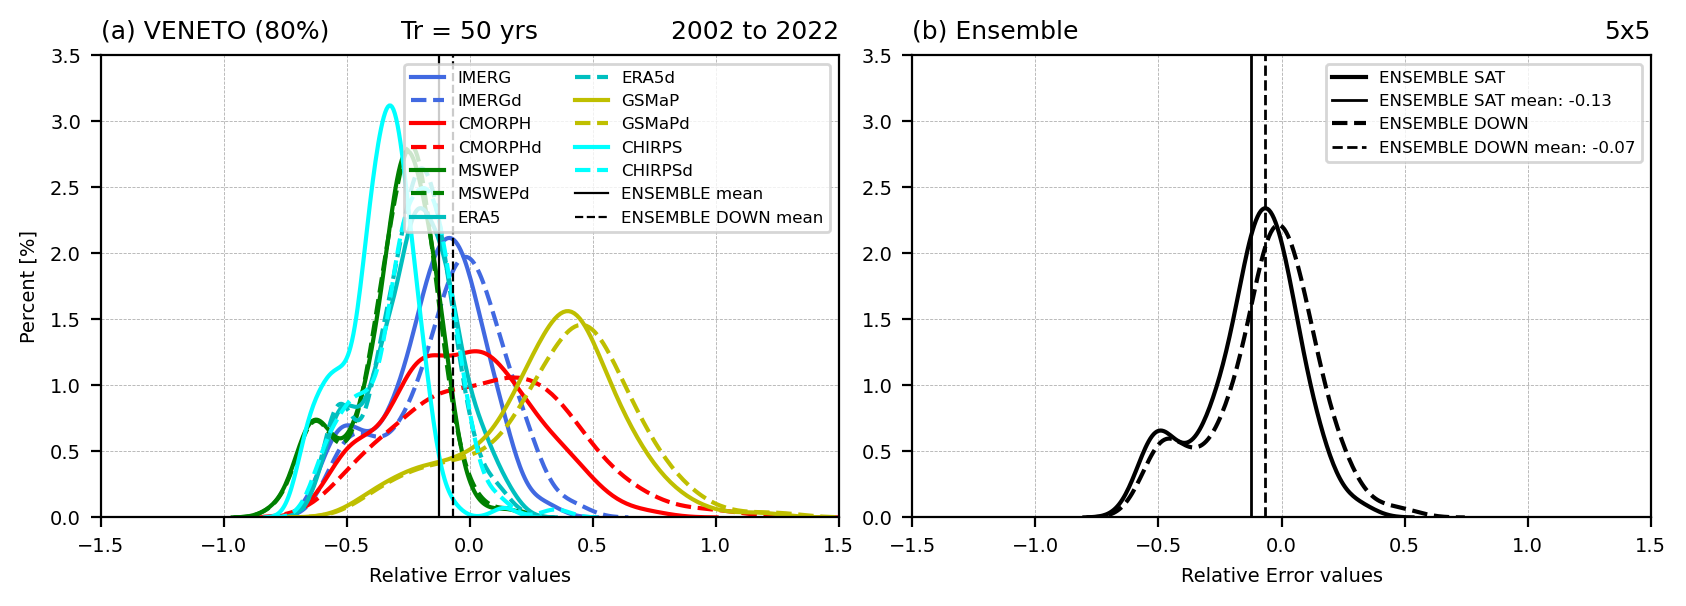

In [91]:
fig = plt.figure(figsize=(10,3),dpi=200)
gs = gridspec.GridSpec(1,2)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])

sns.kdeplot(IMERG_80QEs,color=colors[0],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'IMERG')
sns.kdeplot(IMERG_80QEd,color=colors[0], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'IMERGd')

sns.kdeplot(CMORPH_80QEs,color=colors[1],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CMORPH')
sns.kdeplot(CMORPH_80QEd,color=colors[1], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CMORPHd')

sns.kdeplot(MSWEP_80QEs,color=colors[2],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'MSWEP')
sns.kdeplot(MSWEP_80QEd,color=colors[2], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'MSWEPd')

sns.kdeplot(ERA5_80QEs,color=colors[3],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ERA5')
sns.kdeplot(ERA5_80QEd,color=colors[3], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ERA5d')

sns.kdeplot(GSMaP_80QEs,color=colors[4],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'GSMaP')
sns.kdeplot(GSMaP_80QEd,color=colors[4], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'GSMaPd')

sns.kdeplot(CHIRPS_80QEs,color=colors[7],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CHIRPS')
sns.kdeplot(CHIRPS_80QEd,color=colors[7], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CHIRPSd')

ax1.axvline(np.mean(Qd80_seeds),color='k',linestyle='-',linewidth=0.8, label='ENSEMBLE mean')
ax1.axvline(np.mean(Qd80_seeds_DOWN),color='k',linestyle='--',linewidth=0.8, label='ENSEMBLE DOWN mean')

ax1.set_ylabel('Percent [%]',fontsize=7)
ax1.set_xlabel('Relative Error values',fontsize=7)
ax1.legend(fontsize=6, loc=0, ncol=2)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,3.5)
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_title(f'(a) {area} (80%)', fontsize=9, loc='left')
ax1.set_title(f'Tr = 50 yrs',fontsize=9, loc='Center')
ax1.set_title(f'{yy_s} to {yy_e}',fontsize=9, loc='right')

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 1])

sns.kdeplot(Qd80_seeds,color='k',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLE SAT')
ax1.axvline(np.mean(Qd80_seeds),color='k',linestyle='-',linewidth=1, label=f'ENSEMBLE SAT mean: {np.round(np.nanmean(np.mean(Qd80_seeds)),2)}')

sns.kdeplot(Qd80_seeds_DOWN,color='k', linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLE DOWN')
ax1.axvline(np.mean(Qd80_seeds_DOWN),color='k',linestyle='--',linewidth=1, label=f'ENSEMBLE DOWN mean: {np.round(np.nanmean(np.mean(Qd80_seeds_DOWN)),2)}')

ax1.legend(fontsize=6, loc=0, ncol=1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,3.5)
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_ylabel('')
ax1.set_xlabel('Relative Error values',fontsize=7) 
ax1.set_title(f'(b) Ensemble', fontsize=9, loc='left')
# ax1.set_title(f'ACF: {method}', fontsize=9, loc='center')
ax1.set_title(f'{NEIBHR}x{NEIBHR}', fontsize=9, loc='right')

# =========================================================================================================================
plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)


In [100]:
list_files = glob.glob(os.path.join('/','home','arturo','Pictures','ERRORS','csv',f'Q20*.csv'))
list_files = sorted(list_files)
list_len = len(list_files)

print(f'Number of files: {list_len}')

IMERG_20QEd, CMORPH_20QEd, ERA5_20QEd, MSWEP_20QEd, GSMaP_20QEd, CHIRPS_20QEd = [], [], [], [], [], []
Qd20_seeds, Qd20_seeds_BIAS = [], []
for nn in range(list_len):
    data_ = pd.read_csv(list_files[nn])

    # IMERG
    QdBIAS_ = data_['IMERG20Qs'].values
    IMERG_20QEd.extend(QdBIAS_)

    # CMORPH
    Qd_ = data_['CMORPH20Qs'].values
    CMORPH_20QEd.extend(Qd_)

    # ERA5
    Qd_ = data_['ERA520Qs'].values
    ERA5_20QEd.extend(Qd_)

    # MSWEP
    Qd_ = data_['MSWEP20Qs'].values
    MSWEP_20QEd.extend(Qd_)

    # GSMaP
    Qd_ = data_['GSMaP20Qs'].values
    GSMaP_20QEd.extend(Qd_)

    # CHIRPS
    Qd_ = data_['CHIRPS20Qs'].values
    CHIRPS_20QEd.extend(Qd_)

    # ENSEMBLE
    Qd_ = data_['ENSEMBLE20Qd'].values
    QdBIAS_ = data_['ENSEMBLE20Qd_BIAS'].values
    Qd20_seeds.extend(Qd_)
    Qd20_seeds_BIAS.extend(QdBIAS_)

Number of files: 20


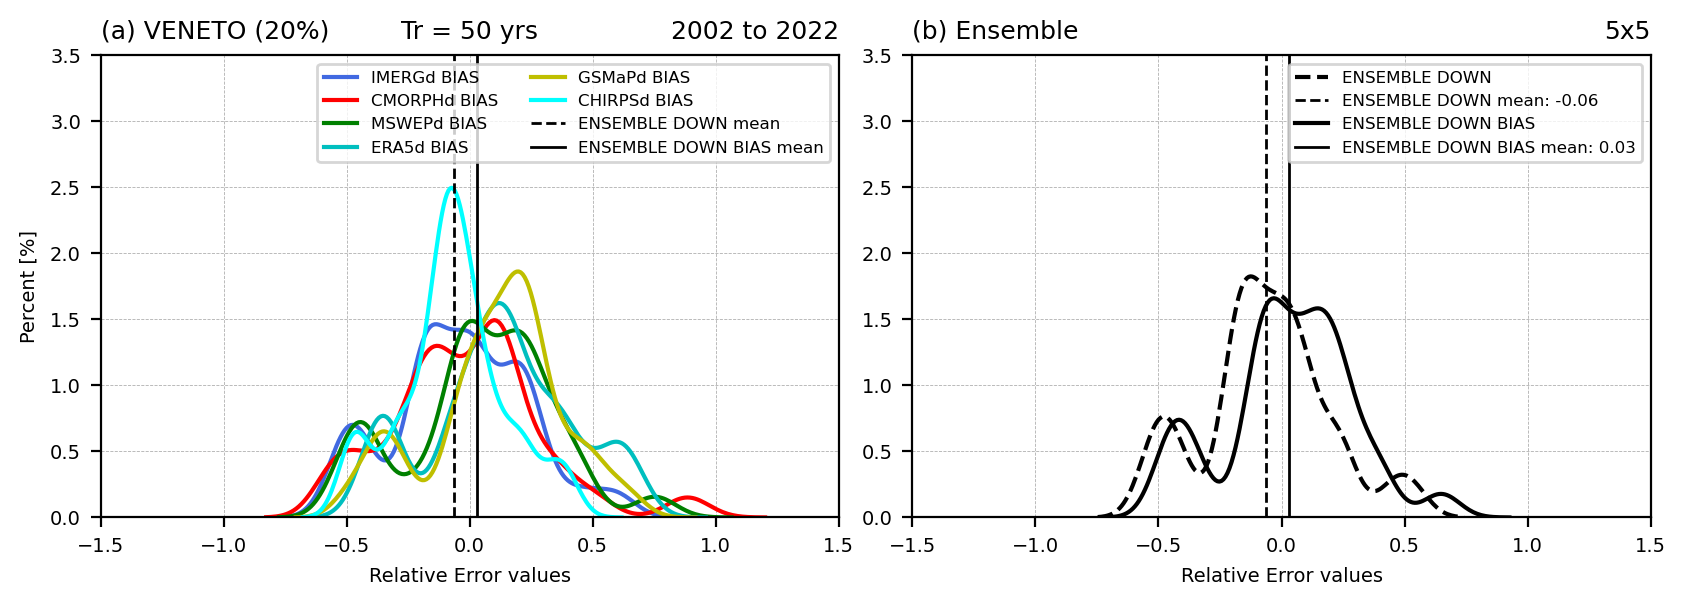

In [101]:
fig = plt.figure(figsize=(10,3),dpi=200)
gs = gridspec.GridSpec(1,2)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])
sns.kdeplot(IMERG_20QEd,color=colors[0],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'IMERGd BIAS')
sns.kdeplot(CMORPH_20QEd,color=colors[1],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CMORPHd BIAS')
sns.kdeplot(MSWEP_20QEd,color=colors[2],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'MSWEPd BIAS')
sns.kdeplot(ERA5_20QEd,color=colors[3],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ERA5d BIAS')
sns.kdeplot(GSMaP_20QEd,color=colors[4],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'GSMaPd BIAS')
sns.kdeplot(CHIRPS_20QEd,color=colors[7],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CHIRPSd BIAS')

ax1.axvline(np.mean(Qd20_seeds),color='k',linestyle='--',linewidth=1, label=f'ENSEMBLE DOWN mean')
ax1.axvline(np.mean(Qd20_seeds_BIAS),color='k',linestyle='-',linewidth=1, label=f'ENSEMBLE DOWN BIAS mean')

ax1.set_ylabel('Percent [%]',fontsize=7)
ax1.set_xlabel('Relative Error values',fontsize=7)
ax1.legend(fontsize=6, loc=0, ncol=2)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,3.5)
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_title(f'(a) {area} (20%)', fontsize=9, loc='left')
ax1.set_title(f'Tr = 50 yrs',fontsize=9, loc='Center')
ax1.set_title(f'{yy_s} to {yy_e}',fontsize=9, loc='right')

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 1])

sns.kdeplot(Qd20_seeds,color='k', linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLE DOWN')
ax1.axvline(np.mean(Qd20_seeds),color='k',linestyle='--',linewidth=1, label=f'ENSEMBLE DOWN mean: {np.round(np.nanmean(np.mean(Qd20_seeds)),2)}')

sns.kdeplot(Qd20_seeds_BIAS,color='k',linestyle='-',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLE DOWN BIAS')
ax1.axvline(np.mean(Qd20_seeds_BIAS),color='k',linestyle='-',linewidth=1, label=f'ENSEMBLE DOWN BIAS mean: {np.round(np.nanmean(np.mean(Qd20_seeds_BIAS)),2)}')

ax1.legend(fontsize=6, loc=0, ncol=1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,3.5)
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_ylabel('')
ax1.set_xlabel('Relative Error values',fontsize=7) 
ax1.set_title(f'(b) Ensemble', fontsize=9, loc='left')
# ax1.set_title(f'ACF: {method}', fontsize=9, loc='center')
ax1.set_title(f'{NEIBHR}x{NEIBHR}', fontsize=9, loc='right')

# =========================================================================================================================
plt.subplots_adjust(wspace=0.1, hspace=0.1)
ax1.set_facecolor('white')
fig.patch.set_alpha(0)


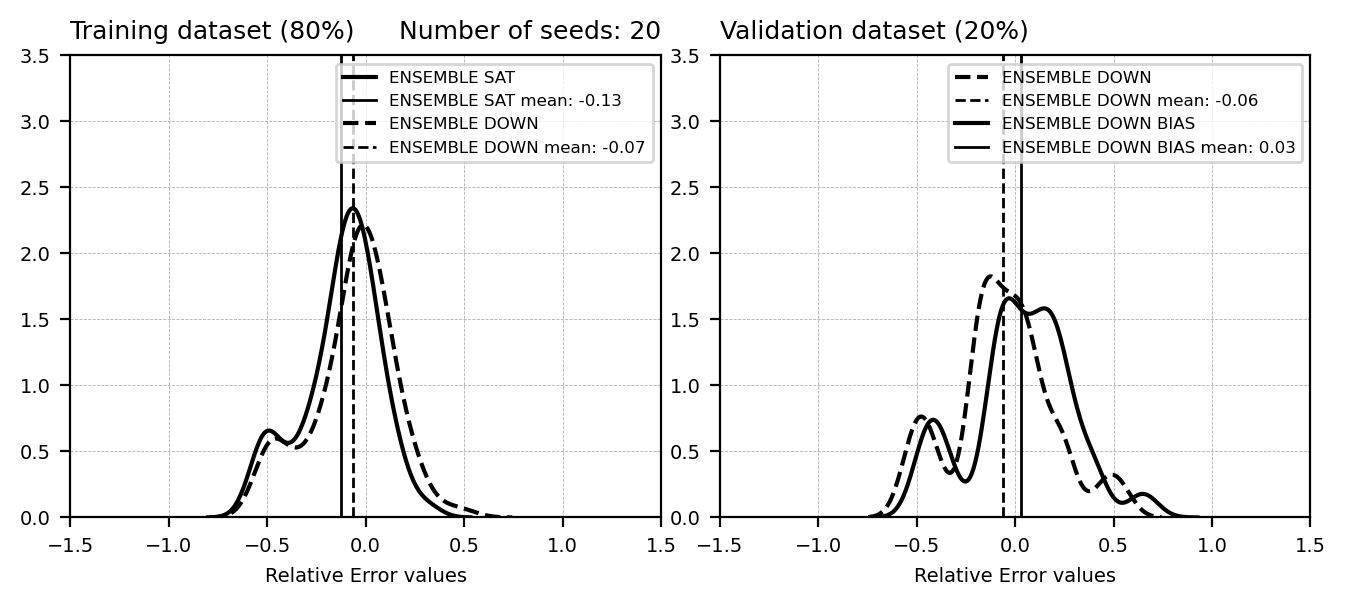

In [110]:
fig = plt.figure(figsize=(8,3),dpi=200)
gs = gridspec.GridSpec(1,2)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])
sns.kdeplot(Qd80_seeds,color='k', linestyle='-',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLE SAT')
ax1.axvline(np.mean(Qd80_seeds),color='k',linestyle='-',linewidth=1, label=f'ENSEMBLE SAT mean: {np.round(np.nanmean(np.mean(Qd80_seeds)),2)}')

sns.kdeplot(Qd80_seeds_DOWN,color='k',linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLE DOWN')
ax1.axvline(np.mean(Qd80_seeds_DOWN),color='k',linestyle='--',linewidth=1, label=f'ENSEMBLE DOWN mean: {np.round(np.nanmean(np.mean(Qd80_seeds_DOWN)),2)}')

ax1.legend(fontsize=6, loc=0, ncol=1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,3.5)
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_ylabel('')
ax1.set_xlabel('Relative Error values',fontsize=7) 
ax1.set_title(f'Number of seeds: {list_len}', fontsize=9, loc='right')
ax1.set_title(f'Training dataset (80%)', fontsize=9, loc='left')

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 1])
sns.kdeplot(Qd20_seeds,color='k', linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLE DOWN')
ax1.axvline(np.mean(Qd20_seeds),color='k',linestyle='--',linewidth=1, label=f'ENSEMBLE DOWN mean: {np.round(np.nanmean(np.mean(Qd20_seeds)),2)}')

sns.kdeplot(Qd20_seeds_BIAS,color='k',linestyle='-',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLE DOWN BIAS')
ax1.axvline(np.mean(Qd20_seeds_BIAS),color='k',linestyle='-',linewidth=1, label=f'ENSEMBLE DOWN BIAS mean: {np.round(np.nanmean(np.mean(Qd20_seeds_BIAS)),2)}')

ax1.legend(fontsize=6, loc=0, ncol=1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,3.5)
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_ylabel('')
ax1.set_xlabel('Relative Error values',fontsize=7) 
ax1.set_title(f'Validation dataset (20%)', fontsize=9, loc='left')

# =========================================================================================================================
plt.subplots_adjust(wspace=0.1, hspace=0.1)
ax1.set_facecolor('white')
fig.patch.set_alpha(0)

<Axes: ylabel='Density'>

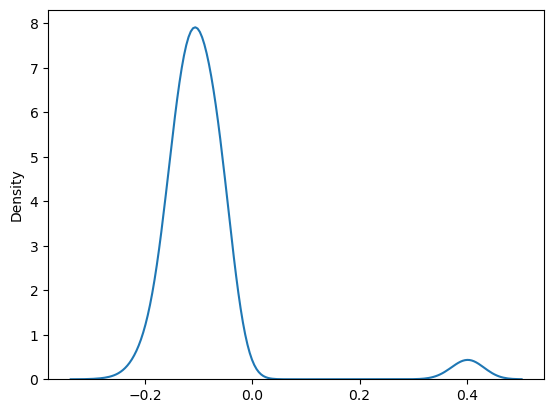

In [113]:
sns.kdeplot(np.array(Qd20_seeds) - np.array(Qd20_seeds_BIAS))